In [ ]:
# !pip install torch==2.3.0 torchvision==0.18.0 torchaudio==2.3.0 --index-url https://download.pytorch.org/whl/cu121
# !pip install  dgl -f https://data.dgl.ai/wheels/torch-2.3/cu121/repo.html
# !pip install seaborn

Versión de DGL: 2.4.0+cu121
Versión de PyTorch: 2.3.0+cu121


In [1]:
# Reload modulos automaticamente
%load_ext autoreload
%autoreload 2

from modules.gnn_models import GCN, GraphSAGE, GAT
from modules.graph import Graph, create_files
from modules.gnn import GNN
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.metrics import roc_auc_score
import torch.nn.functional as F
import numpy as np

# from modules.gnn import GNN
# from modules.models import  ModelGraphSAGE, GraphSAGE, GCN, ModelGCN, ModelSAGESample #ModelGraphSAGE,GraphSAGE, GCN,ModelSAGESample,SAGE, ModelGCN
# from modules.predictors import DotPredictor, MLPPredictor, MLPPredictorEmbeddings
# from modules.graph_from_api import Graph_API
# from dgl.sampling import pack_traces

# import torch.nn.functional as F
# from torch.optim import Adam
# from torch.optim import SparseAdam
import itertools
import dgl
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.metrics import (
    confusion_matrix,              # ya lo estabas usando
    accuracy_score,
    precision_recall_fscore_support,
    classification_report
)
# from utils import *
# from modules.graph import Graph
# import numpy as np
import os
# import fnmatch
# import tqdm
# import networkx as nx

# import dgl.function as fn
# from dgl.nn import DeepWalk
# from torch.utils.data import DataLoader

# from sklearn.linear_model import LogisticRegression
# from gensim.models import Word2Vec
# from sklearn.model_selection import train_test_split
# from bgp2vec.bgp2vec import BGP2VEC


print("Versión de DGL:", dgl.__version__)
print("Versión de PyTorch:", torch.__version__)

/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Versión de DGL: 2.4.0+cu121
Versión de PyTorch: 2.3.0+cu121


In [2]:
TOR_LABELS_DICT = {'P2P':0, 'C2P': 1,'P2C': 2}



In [3]:
# Definimos las rutas de los archivos
BASE_PROJECT_PATH = os.getcwd() + "/data/"
RELATIONSHIPS_FILE  = BASE_PROJECT_PATH + "CAIDA_AS_Relationships/Serial_1/20220701.as-rel.txt.bz2"
FEATURES_FILE = BASE_PROJECT_PATH + "/node_feature_mio.csv" #"/node_features.csv" 
rib_path = BASE_PROJECT_PATH + 'sanitized_rib.txt'
MES = 'febrero'
dataset_graph_path = BASE_PROJECT_PATH + f'dgl_graph/{MES}/'
MAX_NUM_ROUTES = 1000000

In [4]:
def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Matriz de confusión',
                          fname=None,
                          cmap=plt.cm.Blues,
                          save=False):
    """
    Esta función imprime y grafica la matriz de confusión.
    La normalización puede aplicarse configurando `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusión normalizada")
    else:
        print('Matriz de confusión sin normalizar')

    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Etiqueta real')
    plt.xlabel('Etiqueta predicha')
    plt.tight_layout()
    
    if save and fname is not None:
        plt.savefig(f"{fname}.png", dpi=300, bbox_inches='tight')
    plt.show()

def plot_confusion_matrix_2(cm,
                            classes,
                            normalize=False,
                            title='Matriz de confusión',
                            fname=None,
                            cmap=plt.cm.Blues,
                            save=False):
    """
    Dibuja la matriz de confusión.
    Si `normalize=True`, muestra los valores en **porcentaje (%)**.
    """
    if normalize:
        cm = cm.astype(float) / cm.sum(axis=1, keepdims=True) * 100  # → %
        print("Matriz de confusión normalizada (%)")
        fmt  = ".1f"   # un decimal
        suffix = "%"   # añade símbolo %
    else:
        print("Matriz de confusión sin normalizar")
        fmt  = "d"
        suffix = ""

    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title); plt.colorbar()
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes, rotation=45)
    plt.yticks(ticks, classes)

    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i,
                     f"{format(cm[i, j], fmt)}{suffix}",
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel("Etiqueta real")
    plt.xlabel("Etiqueta predicha")
    plt.tight_layout()

    if save and fname:
        plt.savefig(f"{fname}.png", dpi=300, bbox_inches="tight")
    plt.show()



## Creacion Grafo 
Creamos un grafo nx y dgl, ademas de los archivos edges.csv y nodes.csv a partir de archivos ribs previamente creados o de archivo CAIDA AS Relationships.

Crear esos archivos una unica vez con create_graph() una ves ya creados los archivos edges.csv y nodes.csv puedo ocupar directamente la funcion 

Se le puede indicar el maximo de bgp paths que se quiere (hehco para cuando se leen ribs no de caida) 

### CASO 1: RIBs
* Creacion de grafo a partir de paths recolectados de las RIBs por BGPStream
* Por ahora le asignamos a todos los nodos embeddings iniciales de de dimension 32 parte con puros 1s todos


In [ ]:
ls /media/valentina/KINGSTON/TESIS/data/RIBs/sanitized_rib_febrero_2024

rib_abril_2024.txt*            sanitized_rib_enero_2024.txt*
rib_enero_2024.txt*            sanitized_rib_febrero_2024.txt*
rib_marzo_2024.txt*            sanitized_rib_marzo_2024.txt*
sanitized_rib_abril_2024.txt*


In [5]:
# Informacion del analisis para la configuracion
MES = 'febrero'
ANO = '2024'

In [6]:
# Ruta a la data base del proyecto
BASE_PROJECT_PATH = os.getcwd() + "/data/"

# Ruta memoria externa con los datos
DATA_PATH = '/media/valentina/KINGSTON/TESIS/data/'

# Archivo etiqueta las relaciones
LABEL_EDGES_FILE = 'data/' + 'CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2'

# Archivo con RIBs
RIB_FILE = DATA_PATH + f'RIBs/sanitized_rib_{MES}_{ANO}.txt'

# Ruta donde se guardaran los grafo DGL
OUTPUT_DIR = BASE_PROJECT_PATH +  f'dgl_graph/{MES}/'

In [7]:
# Ruta a la data base del proyecto
BASE_PROJECT_PATH = os.getcwd() + "/data/"

# Ruta memoria externa con los datos
DATA_PATH = '/media/valentina/KINGSTON/TESIS/data/'

# Archivo etiqueta las relaciones
LABEL_EDGES_FILE = DATA_PATH + 'CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2'

# Archivo con RIBs
RIB_FILE = DATA_PATH + f'RIBs/sanitized_rib_{MES}_{ANO}.txt'

# Ruta donde se guardaran los grafo DGL
OUTPUT_DIR = BASE_PROJECT_PATH +  f'dgl_graph/{MES}/'
# Definimos las listas de features

# features_file = 'node_degrees' #'' # 'node_degrees' # las features que se le agregaran seran 
# features_file = base_path + "/node_features.csv"
FEATURES_FILE = BASE_PROJECT_PATH + "/node_features_mio_febrero.csv"
# FEATURES_FILE = 'node_features_mio_febrero.csv'
attr = 'node_features_mio_febrero.csv' # 'mio_attr' # 'degree' # 'node_features_mio_febrero.csv'
rib_path = BASE_PROJECT_PATH + 'sanitized_rib_febrero_2024.txt'
MAX_NUM_ROUTES = 1000000
label_edges_file = BASE_PROJECT_PATH + 'edges_labels.csv'
graph_case1 = create_files(
            output_dir = OUTPUT_DIR,
            rib_file = RIB_FILE, 
            features_file = FEATURES_FILE, 
            from_caida = False, 
            label_edges_file = LABEL_EDGES_FILE,
            remove_degree=3,
            debug=True,
            max_paths = MAX_NUM_ROUTES)

print('[NX Graph]',graph_case1.nx_graph)

[CARPETA CREADA]:  /home/valentina/Desktop/GIT/TrabajoTesis/data/dgl_graph/febrero/
[Creando topologia desde /media/valentina/KINGSTON/TESIS/data/RIBs/sanitized_rib_febrero_2024.txt]


FileNotFoundError: [Errno 2] No such file or directory: '/media/valentina/KINGSTON/TESIS/data/RIBs/sanitized_rib_febrero_2024.txt'

## Entrenamiento

### CASO 1: 
* Encoder : GNN -> (GCN , GraphSAGE, GAT)
* Decoder : DotProduct

In [4]:

# DATA_PATH = '/media/valentina/KINGSTON/TESIS'
RELATIONSHIPS_FILE = '/home/valentina/Desktop/GIT/TrabajoTesis/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2'
# rib_path = '/media/valentina/KINGSTON/TESIS/data/RIBs/sanitized_rib_febrero_2024.txt'

# # Grafo Internet con Grado
# INTERNETGRAPH_FILE ='/media/valentina/KINGSTON/TESIS/nternetGraphs2024Degree/'

# # Grafo Internet con datos 2022
# INTERNETGRAPH_FILE ='/media/valentina/KINGSTON/TESIS/InternetGNNData2022/'

# Grafo Internet con PeeringDB
# INTERNETGRAPH_FILE = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024'

# Grafo Internet con PeeringDB completo de febrero
INTERNETGRAPH_FILE = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024/febrero'



In [13]:
ls /home/valentina/Desktop/GIT/TrabajoTesis/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2

/home/valentina/Desktop/GIT/TrabajoTesis/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2


### Nuevo Caso

In [6]:
gnn = GNN(debug=True)
gnn.load_dataset(
    data_path="/media/valentina/KINGSTON/TESIS/InternetGraphs2024/febrero",
    index_graph=1,            # grafo de febrero
    caida_path='/home/valentina/Desktop/GIT/TrabajoTesis/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2',
    simplify=True,            # ⇐ hazlo sólo una vez
)


[load_dataset] Leyendo CSV …
Done loading data from cached files.
[load_dataset] Grafo Graph(num_nodes=42683, num_edges=157675438,
      ndata_schemes={'feat': Scheme(shape=(68,), dtype=torch.float32)}
      edata_schemes={})
[load_dataset] Simplificando  …
[load_dataset] Etiquetando CAIDA → /home/valentina/Desktop/GIT/TrabajoTesis/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2


Etiquetando CAIDA: 488952it [00:00, 510042.95it/s]


[CAIDA] Añadidas 977288 aristas que faltaban
[CAIDA] Conteo final de etiquetas 0/1/2/-1 → Counter({-1: 699046, 0: 668732, 2: 154411, 1: 154411})
[load_dataset] etiquetas 0/1/2/-1 → Counter({-1: 699046, 0: 668732, 2: 154411, 1: 154411})


In [7]:
gnn.dgl_graph

Graph(num_nodes=401308, num_edges=1676600,
      ndata_schemes={'feat': Scheme(shape=(68,), dtype=torch.float32)}
      edata_schemes={False: Scheme(shape=(), dtype=torch.int64), 'Relationship': Scheme(shape=(), dtype=torch.int8)})

In [15]:
gnn.split_edges_no_leak()

[split] train=222  val=26  test=18  clases={2: 87, 1: 87, 0: 48}


In [12]:
ls /media/valentina/KINGSTON/TESIS/InternetGraphs2024/

ls: cannot access '/media/valentina/KINGSTON/TESIS/InternetGraphs2024/': No such file or directory


In [8]:
# Creo instancia de la clase GNN
# INTERNETGRAPH_FILE = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024' TODO: Revisar porque no funciona
# INTERNETGRAPH_FILE = BASE_PROJECT_PATH +  f'dgl_graph/{MES}/'
RELATIONSHIPS_FILE = '/home/valentina/Desktop/GIT/TrabajoTesis/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2'
INTERNETGRAPH_FILE = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024/febrero'

gnn = GNN(debug=True)

# Cargo dataset y etiqueto sgun archivo de relaciones
gnn.load_dataset(
    data_path=INTERNETGRAPH_FILE,  # Grafo internet no etiquetado
    force_reload=True,
    index_graph = 1,  # Indice del grafo a cargar febrero
    caida_path=RELATIONSHIPS_FILE  # Archivo CAIDA AS Relationships
)

# gnn.split_edges_no_leak(train_ratio=0.8, val_ratio=0.1, seed=42)


[load_dataset] Leyendo CSV …
Done saving data into cached files.
[load_dataset] Grafo Graph(num_nodes=42683, num_edges=157675438,
      ndata_schemes={'feat': Scheme(shape=(68,), dtype=torch.float32)}
      edata_schemes={})
[load_dataset] Etiquetando CAIDA → /home/valentina/Desktop/GIT/TrabajoTesis/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2


Etiquetando CAIDA: 488952it [00:01, 480949.26it/s]


[CAIDA] Añadidas 977288 aristas que faltaban
[CAIDA] Conteo final de etiquetas 0/1/2/-1 → Counter({-1: 157675172, 0: 668732, 2: 154411, 1: 154411})
[load_dataset] etiquetas 0/1/2/-1 → Counter({-1: 157675172, 0: 668732, 2: 154411, 1: 154411})


In [9]:
# Comprobar cantidad aristas con y sin etiqueta

print('[GRAFO]',gnn.dgl_graph)

rel = gnn.dgl_graph.edata['Relationship']
# print("Etiquetas:", (rel >= 0).sum().item(), "con etiqueta  |",
#                     (rel < 0).sum().item(),  "sin etiqueta")
print("Etiquetas:", Counter(rel.tolist()))

[GRAFO] Graph(num_nodes=401308, num_edges=158652726,
      ndata_schemes={'feat': Scheme(shape=(68,), dtype=torch.float32)}
      edata_schemes={'Relationship': Scheme(shape=(), dtype=torch.int8)})
Etiquetas: Counter({-1: 157675172, 0: 668732, 2: 154411, 1: 154411})


In [ ]:
# --- 1.  datos base -------------------------------------------------
in_feats       = gnn.dgl_graph.ndata['feat'].shape[1]
hidden_feats   = 32
out_feats      = 16
out_feats_mlp  = 3                  # 3 clases
device         = "cuda" if torch.cuda.is_available() else "cpu"


# pesos por clase (opcional, para desbalance)
from collections import Counter
cnt = Counter(labels_train.tolist())
tot = sum(cnt.values())
class_w = torch.tensor([tot / cnt[c] for c in (0, 1, 2)],
                       dtype=torch.float32, device=device)

# --- 2.  bucle sobre arquitecturas ---------------------------------
for model_name, Model in models.items():
    print(f"─── Training: {model_name} ───")

    model = Model(
        in_feats=in_feats,
        hidden_feats=hidden_feats,
        out_feats=out_feats,
        out_feats_mlp=out_feats_mlp
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

    # --- 3.  entrenamiento ----------------------------------------
    for epoch in range(50):
        model.train()

        # 3.1  message-passing con TODO el grafo
        h = model.encode(gnn.dgl_graph.to(device),
                         gnn.dgl_graph.ndata['feat'].to(device))

        # 3.2  logits SOLO sobre las aristas etiquetadas
        logits = model.decodeMLP(gnn.train_pos_g.to(device), h)
        labels = gnn.train_pos_g.edata["Relationship"].to(torch.int64)
        
        loss = F.cross_entropy(logits, labels,
                         weight=class_w,
                         ignore_index=-1)  

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            pred = logits.argmax(1)
            acc  = (pred == labels_train).float().mean().item()
            print(f"Epoch {epoch:02d} | loss {loss.item():.4f} | acc {acc:.4f}")

    # --- 4.  evaluación en test -----------------------------------
    model.eval()
    with torch.no_grad():
        h_test = model.encode(gnn.train_g.to(device),
                              gnn.train_g.ndata['feat'].to(device))
        
        logits_test = model.decodeMLP(gnn.test_pos_g.to(device), h_test)

        y_pred = logits_test.argmax(1).cpu()
        y_true = gnn.test_pos_g.edata['Relationship'].to(torch.int64).cpu()

        # 3)  filtra posibles -1 (por si se coló alguno)
        mask   = y_true >= 0
        y_true = y_true[mask].numpy()
        y_pred = y_pred[mask].numpy()

        # 4)  matriz de confusión y reporte
        conf = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
        report = classification_report(
        y_true, y_pred, digits=4, labels=[0, 1, 2],
        target_names=["P2P (0)", "C2P (1)", "P2C (2)"]
        )

        print("\nConfusion matrix:")
        print(confusion_matrix(y_true, y_pred))
        print("\nClassification report:")
        print(classification_report(y_true, y_pred, digits=4))

        # 5)  gráfico
        plt.figure(figsize=(5, 4))
        sns.heatmap(conf, annot=True, fmt='d', cmap='Blues',
                    xticklabels=["P2P", "C2P", "P2C"],
                    yticklabels=["P2P", "C2P", "P2C"])
        plt.xlabel('Predicción')
        plt.ylabel('Etiqueta real')
        plt.title('Matriz de confusión (test)')
        plt.tight_layout()
        plt.show()

        print("\nClassification report\n")
        print(report)
    


AttributeError: 'GNN' object has no attribute 'train_pos_g'

### Nuevo: 
Entreno con todo el grafo y (incluso aristas -1) , la peridda y las metricas solo usan las etiquetas etiquetadas, divididas eb train val test y nose generan negativos

In [16]:
# Creo instancia de la clase GNN
# INTERNETGRAPH_FILE = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024' TODO: Revisar porque no funciona
INTERNETGRAPH_FILE = BASE_PROJECT_PATH +  f'dgl_graph/{MES}/'

gnn = GNN(debug=True)

# Cargo dataset y etiqueto sgun archivo de relaciones
gnn.load_dataset(
    data_path=INTERNETGRAPH_FILE,  # Grafo internet no etiquetado
    force_reload=True,
    caida_path=RELATIONSHIPS_FILE  # Archivo CAIDA AS Relationships
)

gnn.split_edges_keep_full_graph(train_ratio=0.8, val_ratio=0.1, seed=42)


Done saving data into cached files.
[CAIDA] enlaces reconocidos = 977,554
[CAIDA] etiquetas asignadas: Counter({1: 67817, 0: 56259, 2: 182})
[load_dataset] Conteo etiquetas 0/1/2/-1 → Counter({1: 67817, 0: 56259, 2: 182})
[split] train=99420  val=12402  test=12436  clases={0: 45012, 1: 54270, 2: 138}


In [17]:
# Comprobar cantidad aristas con y sin etiqueta

print('[GRAFO]',gnn.dgl_graph)

rel = gnn.dgl_graph.edata['Relationship']
# print("Etiquetas:", (rel >= 0).sum().item(), "con etiqueta  |",
#                     (rel < 0).sum().item(),  "sin etiqueta")
print("Etiquetas:", Counter(rel.tolist()))

[GRAFO] Graph(num_nodes=25077, num_edges=124258,
      ndata_schemes={'feat': Scheme(shape=(67,), dtype=torch.float32)}
      edata_schemes={'Relationship': Scheme(shape=(), dtype=torch.int64)})
Etiquetas: Counter({1: 67817, 0: 56259, 2: 182})


In [18]:
# --- 1.  datos base -------------------------------------------------
in_feats       = gnn.full_g.ndata['feat'].shape[1]
hidden_feats   = 32
out_feats      = 16
out_feats_mlp  = 3                      # 3 clases
device         = "cuda" if torch.cuda.is_available() else "cpu"

# etiquetas SOLO de las aristas con 0/1/2 (train)
labels_train = gnn.train_pos_g.edata['Relationship'].to(torch.int64).to(device)

# pesos por clase (opcional)
from collections import Counter
cnt = Counter(labels_train.tolist())          # ej. {0:318, 1:29, 2:29}
tot = sum(cnt.values())
class_w = torch.tensor([tot/cnt[c] for c in (0,1,2)],
                       dtype=torch.float32, device=device)

# --- 2.  bucle sobre arquitecturas ---------------------------------
for model_name, Model in models.items():
    print(f"─── Training: {model_name} ───")

    model = Model(
        in_feats=in_feats,
        hidden_feats=hidden_feats,
        out_feats=out_feats,
        out_feats_mlp=out_feats_mlp
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # --- 3.  entrenamiento ----------------------------------------
    for epoch in range(50):
        model.train()

        # 3.1  message-passing con TODO el grafo completo
        h = model.encode(
            gnn.full_g.to(device),
            gnn.full_g.ndata['feat'].to(device)
        )

        # 3.2  logits y pérdida SOLO sobre aristas 0/1/2 de train
        logits = model.decodeMLP(gnn.train_pos_g.to(device), h)
        loss   = F.cross_entropy(logits, labels_train, weight=class_w)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            acc = (logits.argmax(1) == labels_train).float().mean().item()
            print(f"Epoch {epoch:02d} | loss {loss.item():.4f} | acc {acc:.4f}")

    # --- 4.  evaluación -------------------------------------------
    model.eval()
    with torch.no_grad():
        # embeddings con el grafo completo
        h_all = model.encode(
            gnn.full_g.to(device),
            gnn.full_g.ndata['feat'].to(device)
        )

        def eval_split(split_g, name):
            logits = model.decodeMLP(split_g.to(device), h_all)
            y_pred = logits.argmax(1).cpu()
            y_true = split_g.edata['Relationship'].cpu()

            print(f"\n{name.upper()}  —  report")
            print(classification_report(
                y_true, y_pred, labels=[0,1,2],
                target_names=["P2P", "C2P", "P2C"],
                digits=4
            ))

            cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
            plt.figure(figsize=(4.5,4))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=["P2P","C2P","P2C"],
                        yticklabels=["P2P","C2P","P2C"])
            plt.title(f"Matriz de confusión – {name}")
            plt.xlabel("Predicción"); plt.ylabel("Real")
            plt.tight_layout(); plt.show()

        eval_split(gnn.val_pos_g,  "validación")
        eval_split(gnn.test_pos_g, "test")


AttributeError: 'GNN' object has no attribute 'full_g'

### Caso Base 0

* Con mis attr 


In [5]:
models = {
    'GCN': GCN,
    'GraphSAGE': GraphSAGE,
    'GAT': GAT,
}

In [6]:
RELATIONSHIPS_FILE = '/home/valentina/Desktop/GIT/TrabajoTesis/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2'
INTERNETGRAPH_FILE = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024/febrero'

gnn = GNN(debug=True)

# Cargo dataset y etiqueto sgun archivo de relaciones
gnn.load_dataset(
    data_path=INTERNETGRAPH_FILE,  # Grafo internet no etiquetado
    force_reload=True,
    index_graph = 1,  # Indice del grafo a cargar febrero
    simplify=True,            # ⇐ hazlo sólo una vez
    caida_path=RELATIONSHIPS_FILE  # Archivo CAIDA AS Relationships
)

gnn.split_edges_classification(train_size=0.5, seed=42)

# 2 min

[load_dataset] Leyendo CSV …
Done saving data into cached files.
[load_dataset] Grafo Graph(num_nodes=42683, num_edges=157675438,
      ndata_schemes={'feat': Scheme(shape=(68,), dtype=torch.float32)}
      edata_schemes={})
[load_dataset] Simplificando  …
[load_dataset] Etiquetando CAIDA → /home/valentina/Desktop/GIT/TrabajoTesis/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2


Etiquetando CAIDA: 488952it [00:01, 470328.39it/s]


[CAIDA] Añadidas 977288 aristas que faltaban
[CAIDA] Conteo final de etiquetas 0/1/2/-1 → Counter({-1: 699046, 0: 668732, 2: 154411, 1: 154411})
[load_dataset] etiquetas 0/1/2/-1 → Counter({-1: 699046, 0: 668732, 2: 154411, 1: 154411})
[split] train=488776  test=488778
  clases train: {0: 334418, 2: 77179, 1: 77179}


In [7]:
# Comprobar cantidad aristas con y sin etiqueta
from collections import Counter

print('[GRAFO]',gnn.dgl_graph)

rel = gnn.dgl_graph.edata['Relationship']
print("Etiquetas:", (rel >= 0).sum().item(), "con etiqueta  |",
                    (rel < 0).sum().item(),  "sin etiqueta")

print("Etiquetas:", Counter(rel.tolist()))

[GRAFO] Graph(num_nodes=401308, num_edges=1676600,
      ndata_schemes={'feat': Scheme(shape=(68,), dtype=torch.float32)}
      edata_schemes={False: Scheme(shape=(), dtype=torch.int64), 'Relationship': Scheme(shape=(), dtype=torch.int8), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool)})
Etiquetas: 977554 con etiqueta  | 699046 sin etiqueta
Etiquetas: Counter({-1: 699046, 0: 668732, 2: 154411, 1: 154411})


#### Encoder : decodeBilinear


=== Training GCN (Bilinear) ===
ep01  loss_tr 1.1252 acc_tr 13.98% | loss_te 1.0714 acc_te 57.72%
ep10  loss_tr 0.7788 acc_tr 68.40% | loss_te 0.7564 acc_te 69.03%
ep20  loss_tr 0.6269 acc_tr 71.30% | loss_te 0.6264 acc_te 71.34%
ep30  loss_tr 0.5733 acc_tr 72.48% | loss_te 0.5628 acc_te 72.96%
ep40  loss_tr 0.5023 acc_tr 75.37% | loss_te 0.4913 acc_te 75.02%
ep50  loss_tr 0.4196 acc_tr 85.40% | loss_te 0.4291 acc_te 83.22%
ep60  loss_tr 0.4219 acc_tr 89.43% | loss_te 0.4028 acc_te 89.98%
ep70  loss_tr 0.3598 acc_tr 90.02% | loss_te 0.3677 acc_te 90.26%
ep80  loss_tr 0.3405 acc_tr 90.43% | loss_te 0.3392 acc_te 90.51%
ep90  loss_tr 0.3260 acc_tr 90.68% | loss_te 0.3206 acc_te 90.83%
ep100  loss_tr 0.3116 acc_tr 90.89% | loss_te 0.3092 acc_te 90.98%
Matriz de confusión sin normalizar


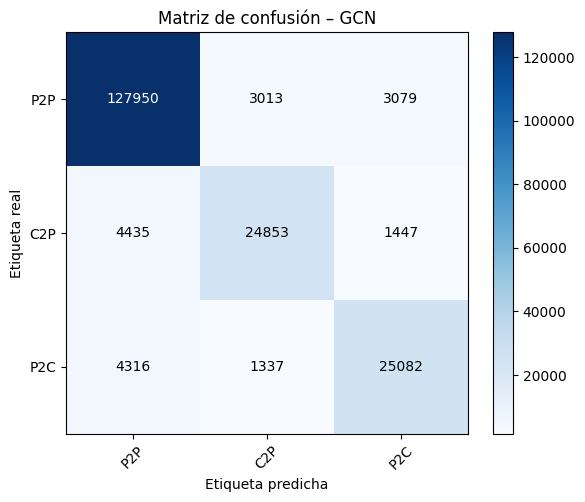

Matriz de confusión normalizada (%)


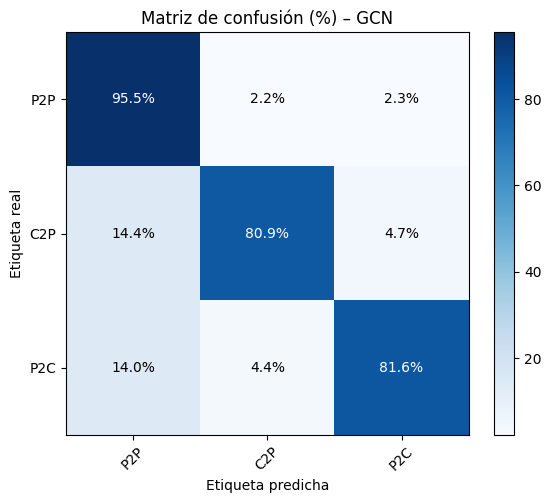

              precision    recall  f1-score   support

           0     0.9360    0.9546    0.9452    134042
           1     0.8510    0.8086    0.8293     30735
           2     0.8471    0.8161    0.8313     30735

    accuracy                         0.9098    195512
   macro avg     0.8781    0.8597    0.8686    195512
weighted avg     0.9087    0.9098    0.9091    195512



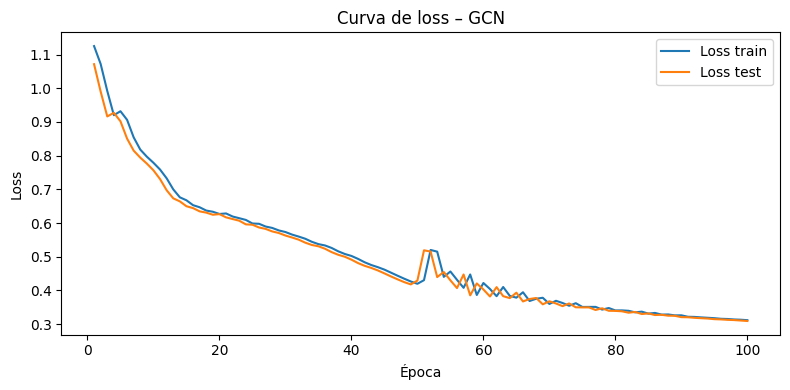

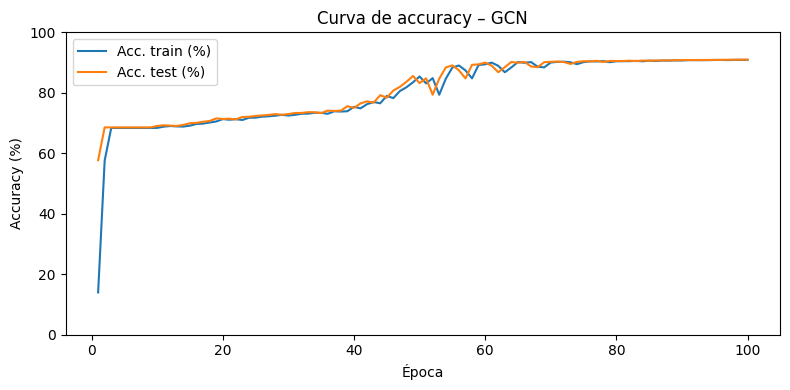


=== Training GraphSAGE (Bilinear) ===
ep01  loss_tr 1.5611 acc_tr 20.19% | loss_te 1.0667 acc_te 63.58%
ep10  loss_tr 0.6924 acc_tr 74.66% | loss_te 0.6710 acc_te 76.05%
ep20  loss_tr 0.5766 acc_tr 79.06% | loss_te 0.5646 acc_te 79.36%
ep30  loss_tr 0.4874 acc_tr 81.35% | loss_te 0.4806 acc_te 81.60%
ep40  loss_tr 0.4175 acc_tr 85.84% | loss_te 0.4130 acc_te 86.17%
ep50  loss_tr 0.3684 acc_tr 88.15% | loss_te 0.3674 acc_te 88.10%
ep60  loss_tr 0.3416 acc_tr 88.77% | loss_te 0.3415 acc_te 88.74%
ep70  loss_tr 0.3201 acc_tr 89.31% | loss_te 0.3199 acc_te 89.27%
ep80  loss_tr 0.3041 acc_tr 89.70% | loss_te 0.3047 acc_te 89.66%
ep90  loss_tr 0.2968 acc_tr 89.67% | loss_te 0.2929 acc_te 89.89%
ep100  loss_tr 0.2861 acc_tr 89.92% | loss_te 0.2877 acc_te 90.18%
Matriz de confusión sin normalizar


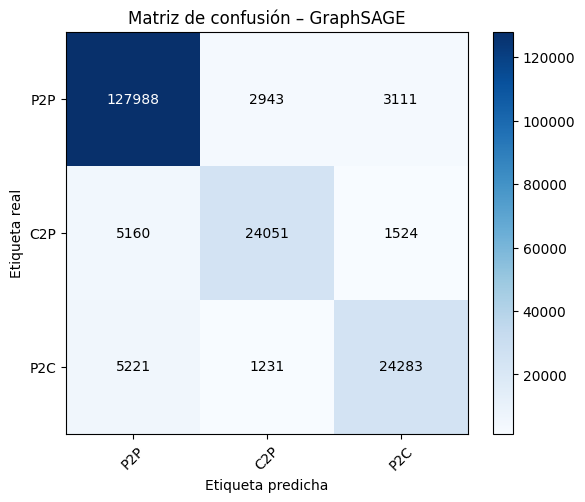

Matriz de confusión normalizada (%)


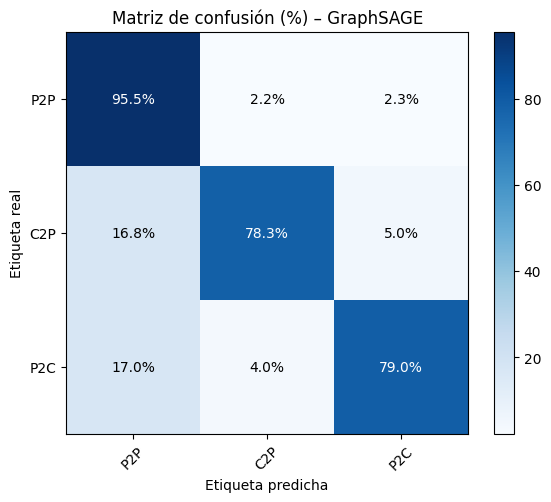

              precision    recall  f1-score   support

           0     0.9250    0.9548    0.9397    134042
           1     0.8521    0.7825    0.8158     30735
           2     0.8397    0.7901    0.8141     30735

    accuracy                         0.9018    195512
   macro avg     0.8723    0.8425    0.8566    195512
weighted avg     0.9001    0.9018    0.9005    195512



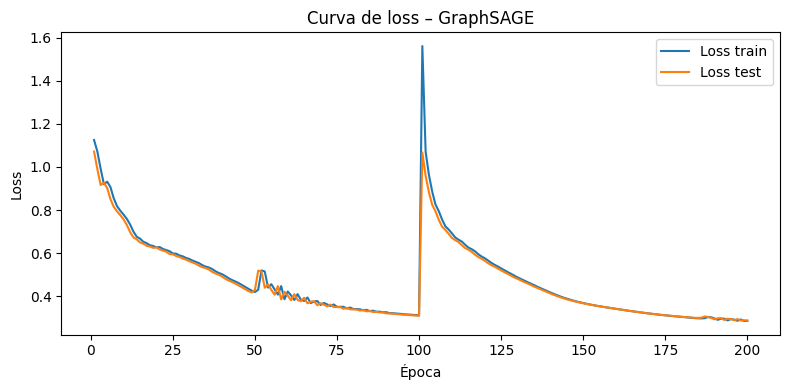

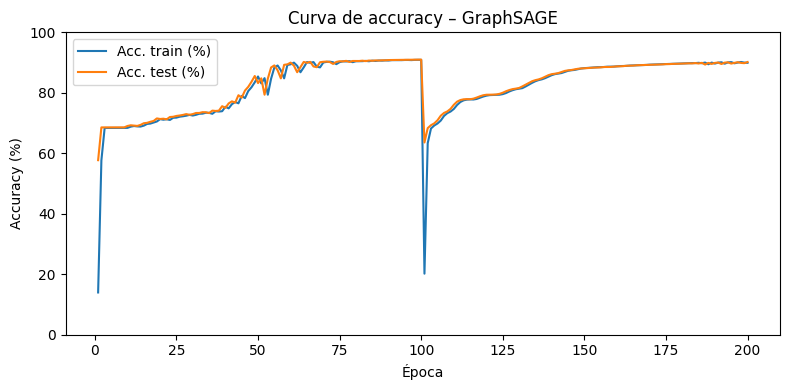


=== Training GAT (Bilinear) ===
ep01  loss_tr 1.1099 acc_tr 14.23% | loss_te 1.0519 acc_te 68.63%
ep10  loss_tr 0.6901 acc_tr 72.08% | loss_te 0.6703 acc_te 73.55%
ep20  loss_tr 0.5424 acc_tr 78.44% | loss_te 0.5283 acc_te 78.86%
ep30  loss_tr 0.4823 acc_tr 80.97% | loss_te 0.4785 acc_te 81.29%
ep40  loss_tr 0.4279 acc_tr 82.45% | loss_te 0.4236 acc_te 82.55%
ep50  loss_tr 0.3804 acc_tr 84.93% | loss_te 0.3769 acc_te 85.23%
ep60  loss_tr 0.3408 acc_tr 87.51% | loss_te 0.3379 acc_te 87.62%
ep70  loss_tr 0.3112 acc_tr 88.88% | loss_te 0.3080 acc_te 89.18%
ep80  loss_tr 0.2907 acc_tr 89.59% | loss_te 0.2905 acc_te 89.74%
ep90  loss_tr 0.2776 acc_tr 89.94% | loss_te 0.2776 acc_te 90.11%
ep100  loss_tr 0.2677 acc_tr 90.32% | loss_te 0.2681 acc_te 90.53%
Matriz de confusión sin normalizar


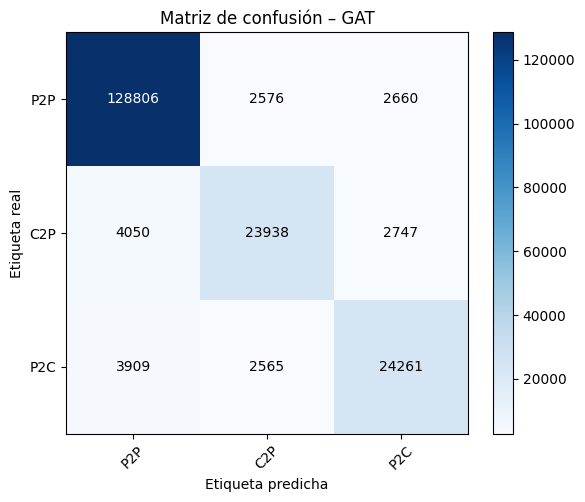

Matriz de confusión normalizada (%)


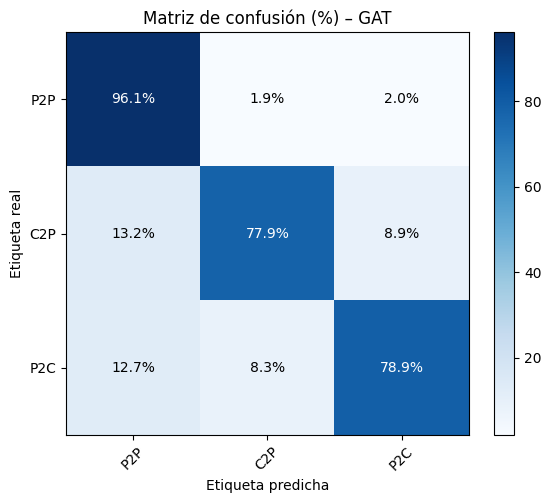

              precision    recall  f1-score   support

           0     0.9418    0.9609    0.9513    134042
           1     0.8232    0.7789    0.8004     30735
           2     0.8177    0.7894    0.8033     30735

    accuracy                         0.9053    195512
   macro avg     0.8609    0.8430    0.8517    195512
weighted avg     0.9037    0.9053    0.9043    195512



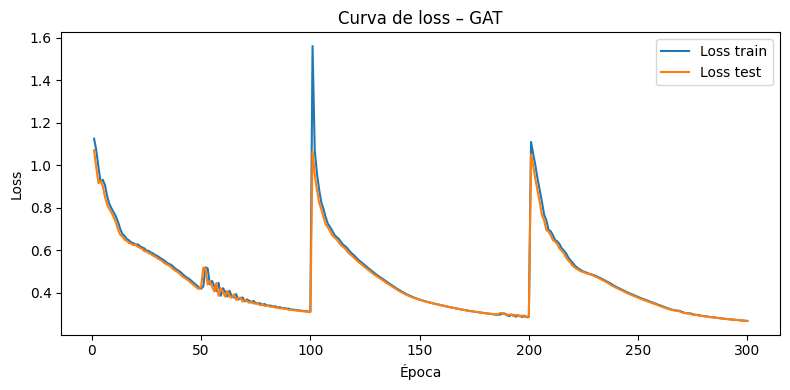

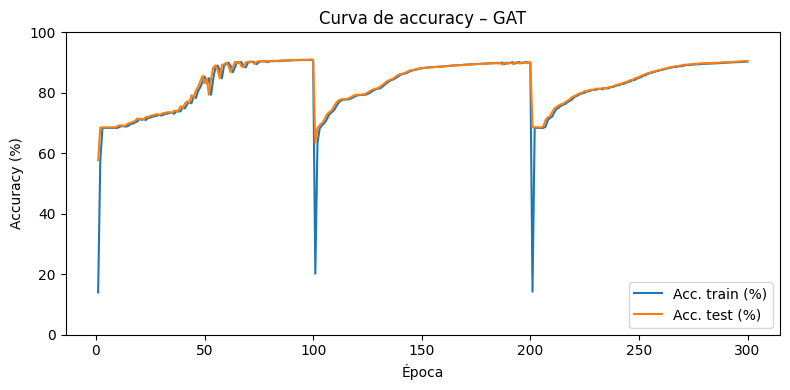

In [ ]:
import torch, itertools, torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt

# ─── parámetros básicos ─────────────────────────────────────────────
in_feats      = gnn.dgl_graph.ndata["feat"].shape[1]
hidden_feats  = 32
emb_dim       = 16
n_classes     = 3
epochs        = 100
lr            = 1e-2
device        = "cuda" if torch.cuda.is_available() else "cpu"

# ─── datos y máscaras ───────────────────────────────────────────────
g       = gnn.dgl_graph.to(device)
feat    = g.ndata["feat"].to(device)
labels  = g.edata["Relationship"].long().to(device)

train_m = g.edata["train_mask"].to(device)
test_m  = g.edata["test_mask"].to(device)

# ─── entrenamiento ─────────────────────────────────────────────────
import torch, torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix


for name, Model in models.items():
    print(f"\n=== Training {name} (Bilinear) ===")

    history = {"loss_tr": [], "acc_tr": [], "loss_te": [], "acc_te": []}


    model = Model(in_feats, hidden_feats, emb_dim, out_feats_mlp=n_classes).to(device)
    opt   = torch.optim.Adam(model.parameters(), lr=lr)

    best_loss, patience, wait = 1e9, 8, 0          # early-stopping

    for epoch in range(1, epochs + 1):
        # ---------- train ----------
        model.train()
        h      = model.encode(g, feat)
        logits = model.decodeBilinear(g, h)         # (E, 3)

        loss   = F.cross_entropy(logits[train_m], labels[train_m])
        opt.zero_grad(); loss.backward(); opt.step()

        with torch.no_grad():
            preds_tr = logits[train_m].argmax(1)
            acc_tr   = (preds_tr == labels[train_m]).float().mean().item()

        # ---------- test ----------
        model.eval()
        with torch.no_grad():
            logits_ = model.decodeBilinear(g, model.encode(g, feat))
            loss_te = F.cross_entropy(logits_[test_m], labels[test_m])
            preds_t = logits_[test_m].argmax(1)
            acc_t   = (preds_t == labels[test_m]).float().mean().item()

        # guarda históricos
        history["loss_tr"].append(loss.item())
        history["acc_tr"].append(acc_tr*100)
        history["loss_te"].append(loss_te.item())
        history["acc_te"].append(acc_t*100)

        # early stopping
        if loss_te < best_loss - 1e-4:
            best_loss, wait = loss_te, 0
            best_w = model.state_dict()
        else:
            wait += 1
            if wait >= patience:
                print(f"🛑  Early stop en epoch {epoch}")
                break

        if epoch % 10 == 0 or epoch == 1:
            print(f"ep{epoch:02d}  loss_tr {loss:.4f} acc_tr {acc_tr:.2%} | "
                  f"loss_te {loss_te:.4f} acc_te {acc_t:.2%}")

    # ---------- matriz de confusión final ----------
    model.load_state_dict(best_w)
    with torch.no_grad():
        logits_best = model.decodeBilinear(g, model.encode(g, feat))
        preds_best  = logits_best[test_m].argmax(1).cpu()
        truth       = labels[test_m].cpu()

    cm = confusion_matrix(truth, preds_best)
    plot_confusion_matrix_2(cm, classes=["P2P","C2P","P2C"],
                            normalize=False,
                            title=f"Matriz de confusión – {name}")
    plot_confusion_matrix_2(cm, classes=["P2P","C2P","P2C"],
                            normalize=True,
                            title=f"Matriz de confusión (%) – {name}")

    print(classification_report(truth, preds_best, digits=4))

    # ─── gráficas de Loss y Accuracy ───────────────────────────────────
    import matplotlib.pyplot as plt
    epoch_axis = range(1, len(history["loss_tr"]) + 1)

    plt.figure(figsize=(8,4))
    plt.plot(epoch_axis, history["loss_tr"],  label="Loss train")
    plt.plot(epoch_axis, history["loss_te"],  label="Loss test")
    plt.xlabel("Época"); plt.ylabel("Loss"); plt.title(f"Curva de loss – {name}")
    plt.legend(); plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8,4))
    plt.plot(epoch_axis, history["acc_tr"],  label="Acc. train (%)")
    plt.plot(epoch_axis, history["acc_te"],  label="Acc. test (%)")
    plt.xlabel("Época"); plt.ylabel("Accuracy (%)"); plt.title(f"Curva de accuracy – {name}")
    plt.ylim(0, 100); plt.legend(); plt.tight_layout()
    plt.show()


    # Compute confusion matrix
    # # Guaradar el modelo
    # torch.save(model.state_dict(), f'data/model_emb_{model_name}.pth')

    # # Guardar los embeddings
    # torch.save(h, f"data/embeddings_ribs_DP_{model_name}.pt")


     
    


Viendo estos resultados igual me hace pensar que hay algun information leak , por el garfico de loss y accuracy que tenemos  ya que el test y y validacion son muy iguales y no suce de un sobreajuste donde se van deferiendo los puntajes despues de cierto punto.

Ademas si corremos esto en 50 epoch en muhco mas malo que en 100 epochs .... OBSERVAR

#### Encoder : MLP


=== Training GCN ===
ep01 | loss_tr 1.1591 acc_tr 15.79% | loss_te 1.0968 acc_te 18.15%
ep10 | loss_tr 0.7190 acc_tr 68.42% | loss_te 0.6881 acc_te 69.06%
ep20 | loss_tr 0.6706 acc_tr 66.85% | loss_te 0.6528 acc_te 70.13%
ep30 | loss_tr 0.6404 acc_tr 69.28% | loss_te 0.6426 acc_te 68.63%
ep40 | loss_tr 0.6174 acc_tr 71.16% | loss_te 0.6152 acc_te 71.48%
ep50 | loss_tr 0.5814 acc_tr 73.18% | loss_te 0.5770 acc_te 73.20%
ep60 | loss_tr 0.5352 acc_tr 75.34% | loss_te 0.5293 acc_te 75.70%
ep70 | loss_tr 0.4635 acc_tr 78.99% | loss_te 0.4543 acc_te 79.46%
ep80 | loss_tr 0.4149 acc_tr 85.71% | loss_te 0.3929 acc_te 87.77%
ep90 | loss_tr 0.3653 acc_tr 88.64% | loss_te 0.3624 acc_te 88.66%
ep100 | loss_tr 0.3429 acc_tr 89.17% | loss_te 0.3431 acc_te 88.82%
Matriz de confusión sin normalizar


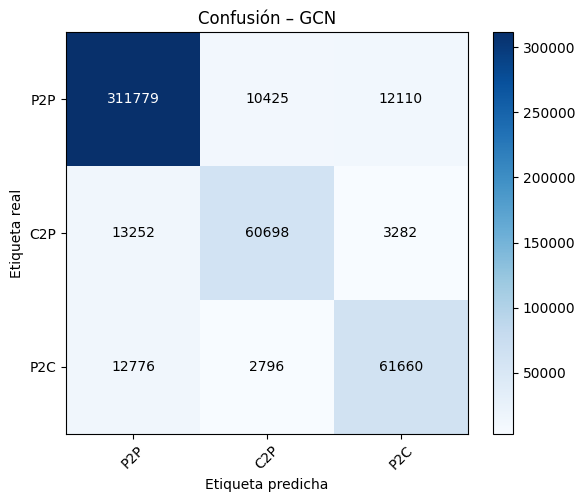

Matriz de confusión normalizada (%)


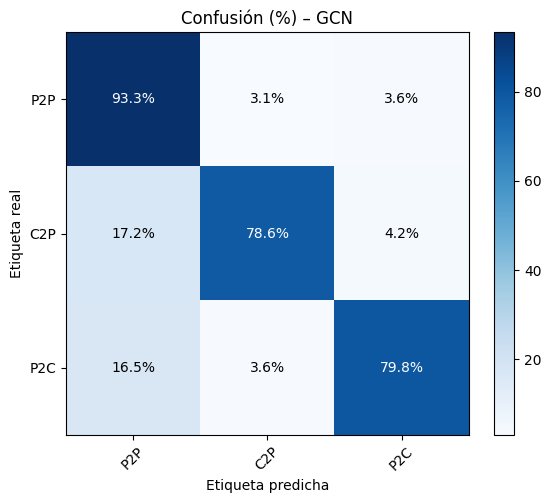

              precision    recall  f1-score   support

           0     0.9230    0.9326    0.9277    334314
           1     0.8211    0.7859    0.8031     77232
           2     0.8002    0.7984    0.7993     77232

    accuracy                         0.8882    488778
   macro avg     0.8481    0.8390    0.8434    488778
weighted avg     0.8875    0.8882    0.8878    488778



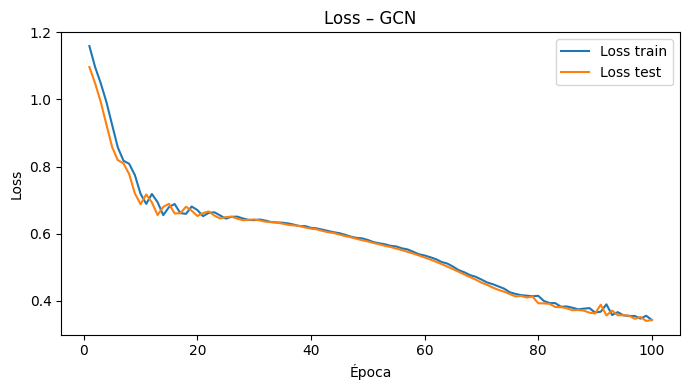

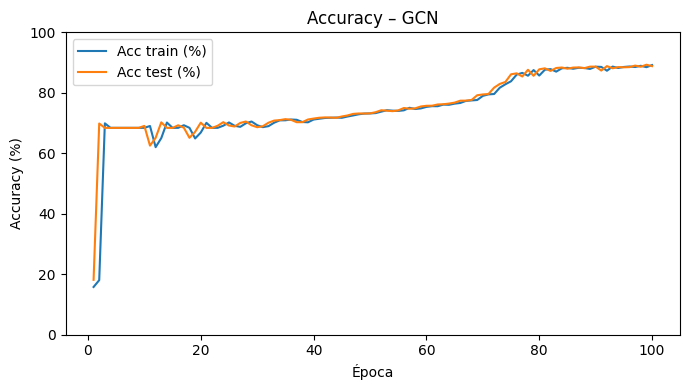


=== Training GraphSAGE ===
ep01 | loss_tr 1.0692 acc_tr 64.24% | loss_te 1.0172 acc_te 68.40%
ep10 | loss_tr 0.8363 acc_tr 68.42% | loss_te 0.8273 acc_te 68.40%
ep20 | loss_tr 0.6963 acc_tr 75.99% | loss_te 0.6734 acc_te 76.49%
ep30 | loss_tr 0.6027 acc_tr 78.43% | loss_te 0.5834 acc_te 78.88%
ep40 | loss_tr 0.5289 acc_tr 80.32% | loss_te 0.5060 acc_te 81.13%
ep50 | loss_tr 0.4786 acc_tr 82.28% | loss_te 0.4607 acc_te 82.69%
ep60 | loss_tr 0.4417 acc_tr 83.78% | loss_te 0.4206 acc_te 84.46%
ep70 | loss_tr 0.3999 acc_tr 86.25% | loss_te 0.3636 acc_te 87.62%
ep80 | loss_tr 0.3494 acc_tr 87.85% | loss_te 0.3233 acc_te 88.73%
ep90 | loss_tr 0.3290 acc_tr 88.31% | loss_te 0.3033 acc_te 89.12%
ep100 | loss_tr 0.3126 acc_tr 88.94% | loss_te 0.2860 acc_te 89.67%
Matriz de confusión sin normalizar


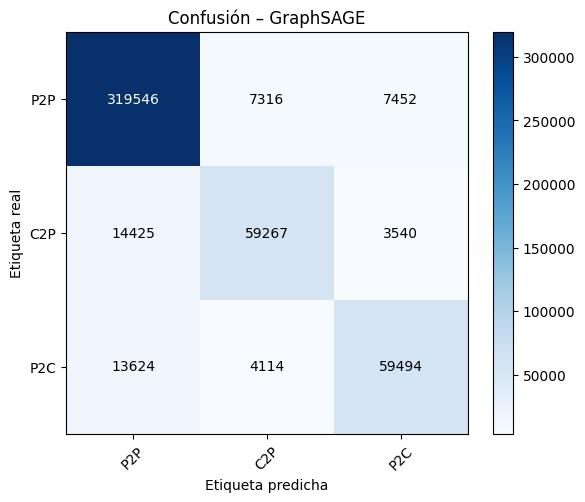

Matriz de confusión normalizada (%)


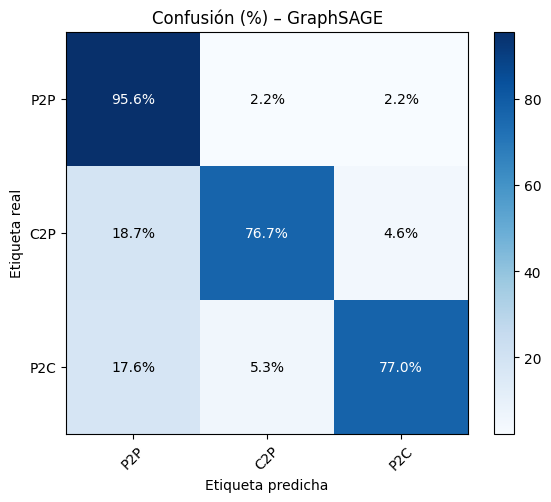

              precision    recall  f1-score   support

           0     0.9193    0.9558    0.9372    334314
           1     0.8383    0.7674    0.8013     77232
           2     0.8441    0.7703    0.8055     77232

    accuracy                         0.8967    488778
   macro avg     0.8672    0.8312    0.8480    488778
weighted avg     0.8946    0.8967    0.8949    488778



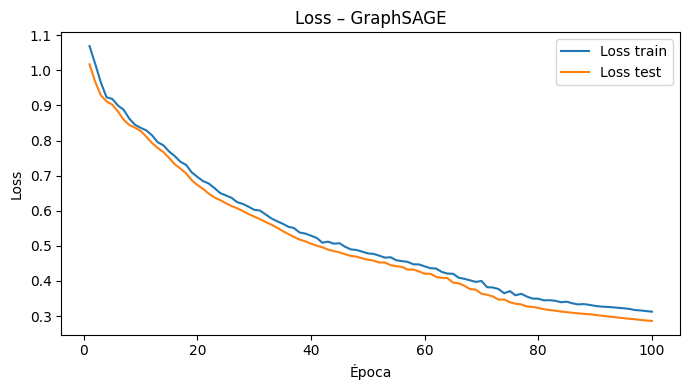

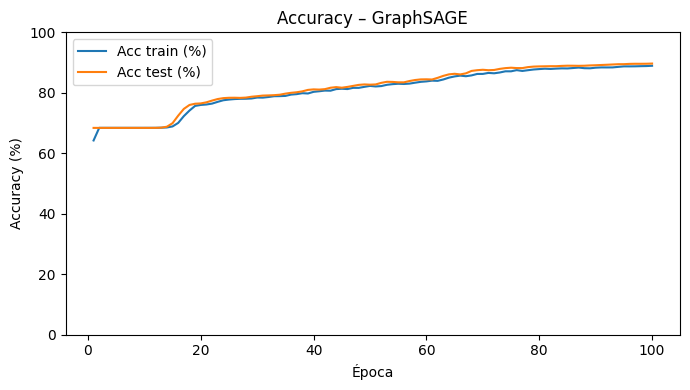


=== Training GAT ===
ep01 | loss_tr 1.1824 acc_tr 15.51% | loss_te 1.1384 acc_te 15.80%
ep10 | loss_tr 0.8359 acc_tr 68.42% | loss_te 0.8058 acc_te 68.40%
ep20 | loss_tr 0.7442 acc_tr 68.46% | loss_te 0.7274 acc_te 68.54%
ep30 | loss_tr 0.5804 acc_tr 74.40% | loss_te 0.5743 acc_te 74.99%


In [ ]:
import torch, torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# ─── parámetros globales ────────────────────────────────────────────
in_feats  = gnn.dgl_graph.ndata["feat"].shape[1]
device    = "cuda" if torch.cuda.is_available() else "cpu"
epochs    = 100
lr        = 1e-2
patience  = 8           # early-stopping
n_classes = 3

# ─── datos y máscaras ───────────────────────────────────────────────
g       = gnn.dgl_graph.to(device)
feat    = g.ndata["feat"].to(device)
labels  = g.edata["Relationship"].long().to(device)
train_m = g.edata["train_mask"].to(device)
test_m  = g.edata["test_mask"].to(device)

for name, Model in models.items():
    print(f"\n=== Training {name} ===")

    model = Model(in_feats, 32, 16, out_feats_mlp=n_classes).to(device)
    opt   = torch.optim.Adam(model.parameters() , lr=lr)

    # histórico por modelo
    hist = {"loss_tr": [], "acc_tr": [], "loss_te": [], "acc_te": []}
    best_loss, wait = 1e9, 0

    for ep in range(1, epochs + 1):
        # ---------- train ----------
        model.train()
        h      = model.encode(g, feat)
        logits = model.decodeMLP(g, h)                  # (E, 3)

        loss   = F.cross_entropy(logits[train_m], labels[train_m])
        
        opt.zero_grad()
        loss.backward() 
        opt.step()

        with torch.no_grad():
            preds_tr = logits[train_m].argmax(1)
            acc_tr   = (preds_tr == labels[train_m]).float().mean().item()

        # ---------- test ----------
        model.eval()
        with torch.no_grad():
            logits_t = model.decodeMLP(g, model.encode(g, feat))
            loss_te  = F.cross_entropy(logits_t[test_m], labels[test_m])
            preds_t  = logits_t[test_m].argmax(1)
            acc_t    = (preds_t == labels[test_m]).float().mean().item()

        # guarda histórico
        hist["loss_tr"].append(loss.item())
        hist["acc_tr"].append(acc_tr * 100)
        hist["loss_te"].append(loss_te.item())
        hist["acc_te"].append(acc_t * 100)

        # early-stopping
        if loss_te < best_loss - 1e-4:
            best_loss, wait = loss_te, 0
            best_w = model.state_dict()
        else:
            wait += 1
            if wait >= patience:
                print(f"🛑  Early stop en época {ep}")
                break

        if ep % 10 == 0 or ep == 1:
            print(f"ep{ep:02d} | loss_tr {loss:.4f} acc_tr {acc_tr:.2%} | "
                  f"loss_te {loss_te:.4f} acc_te {acc_t:.2%}")

    # ---------- evaluación final ----------
    model.load_state_dict(best_w)
    with torch.no_grad():
        logits_best = model.decodeMLP(g, model.encode(g, feat))
        preds_best  = logits_best[test_m].argmax(1).cpu()
        truth       = labels[test_m].cpu()

    cm = confusion_matrix(truth, preds_best)
    plot_confusion_matrix_2(cm, ["P2P","C2P","P2C"], False,
                            title=f"Confusión – {name}")
    plot_confusion_matrix_2(cm, ["P2P","C2P","P2C"], True,
                            title=f"Confusión (%) – {name}")

    print(classification_report(truth, preds_best, digits=4))

    # ---------- curvas de entrenamiento ----------
    epochs_done = range(1, len(hist["loss_tr"]) + 1)

    plt.figure(figsize=(7,4))
    plt.plot(epochs_done, hist["loss_tr"], label="Loss train")
    plt.plot(epochs_done, hist["loss_te"], label="Loss test")
    plt.xlabel("Época"); plt.ylabel("Loss"); plt.title(f"Loss – {name}")
    plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(epochs_done, hist["acc_tr"], label="Acc train (%)")
    plt.plot(epochs_done, hist["acc_te"], label="Acc test (%)")
    plt.xlabel("Época"); plt.ylabel("Accuracy (%)"); plt.ylim(0,100)
    plt.title(f"Accuracy – {name}")
    plt.legend(); plt.tight_layout(); plt.show()



In [ ]:

for split, m in zip(["train", "test"], [train_m, test_m]):
    num = int(m.sum())
    clases = torch.bincount(labels[m], minlength=3).tolist()
    print(f"{split:<5}: {num:>7}  →  P2P={clases[0]}  C2P={clases[1]}  P2C={clases[2]}")


train:  782042  →  P2P=534690  C2P=123676  P2C=123676
test :  195512  →  P2P=134042  C2P=30735  P2C=30735


### CASO 1

* Con mis attr

En este caso el split si es leaky, es decir ambas aritas de un mismo par de nodos pueden estar separadas en el split quedar una en el test y otro en train.

In [5]:
models = {
    'GCN': GCN,
    'GraphSAGE': GraphSAGE,
    'GAT': GAT,
}

In [ ]:
RELATIONSHIPS_FILE = '/home/valentina/Desktop/GIT/TrabajoTesis/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2'
INTERNETGRAPH_FILE = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024/febrero'

gnn = GNN(debug=True)

# Cargo dataset y etiqueto sgun archivo de relaciones
gnn.load_dataset(
    data_path=INTERNETGRAPH_FILE,  # Grafo internet no etiquetado
    force_reload=True,
    index_graph = 1,  # Indice del grafo a cargar febrero
    simplify=True,            # ⇐ hazlo sólo una vez
    caida_path=RELATIONSHIPS_FILE  # Archivo CAIDA AS Relationships
)

gnn.split_edges_classification_leaky(train_size=0.5, seed=42)

[load_dataset] Leyendo CSV …
Done saving data into cached files.
[load_dataset] Grafo Graph(num_nodes=42683, num_edges=157675438,
      ndata_schemes={'feat': Scheme(shape=(68,), dtype=torch.float32)}
      edata_schemes={})
[load_dataset] Simplificando  …
[load_dataset] Etiquetando CAIDA → /home/valentina/Desktop/GIT/TrabajoTesis/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2


Etiquetando CAIDA: 488952it [00:01, 467145.55it/s]


[CAIDA] Añadidas 977288 aristas que faltaban
[CAIDA] Conteo final de etiquetas 0/1/2/-1 → Counter({-1: 699046, 0: 668732, 2: 154411, 1: 154411})
[load_dataset] etiquetas 0/1/2/-1 → Counter({-1: 699046, 0: 668732, 2: 154411, 1: 154411})
[split_leaky] train=782,043  test=195,511
  clases train 0/1/2 → {0: 535022, 2: 123462, 1: 123559}
  clases test  0/1/2 → {0: 133710, 1: 30852, 2: 30949}


#### Encoder: Bilinear


=== Training GCN (Bilinear) ===
ep01  loss_tr 1.1563 acc_tr 16.00% | loss_te 1.0663 acc_te 68.22%
ep10  loss_tr 0.7845 acc_tr 68.09% | loss_te 0.7518 acc_te 68.02%
ep20  loss_tr 0.6308 acc_tr 69.32% | loss_te 0.6089 acc_te 71.29%
ep30  loss_tr 0.5729 acc_tr 72.87% | loss_te 0.5666 acc_te 72.99%
ep40  loss_tr 0.5311 acc_tr 74.41% | loss_te 0.5271 acc_te 74.64%
ep50  loss_tr 0.4813 acc_tr 76.88% | loss_te 0.4760 acc_te 77.13%
ep60  loss_tr 0.4437 acc_tr 80.06% | loss_te 0.4261 acc_te 84.67%
ep70  loss_tr 0.3911 acc_tr 88.45% | loss_te 0.3961 acc_te 89.37%
ep80  loss_tr 0.3721 acc_tr 89.90% | loss_te 0.3695 acc_te 89.19%
ep90  loss_tr 0.3487 acc_tr 89.96% | loss_te 0.3432 acc_te 90.29%
ep100  loss_tr 0.3304 acc_tr 90.66% | loss_te 0.3263 acc_te 90.82%
Matriz de confusión sin normalizar


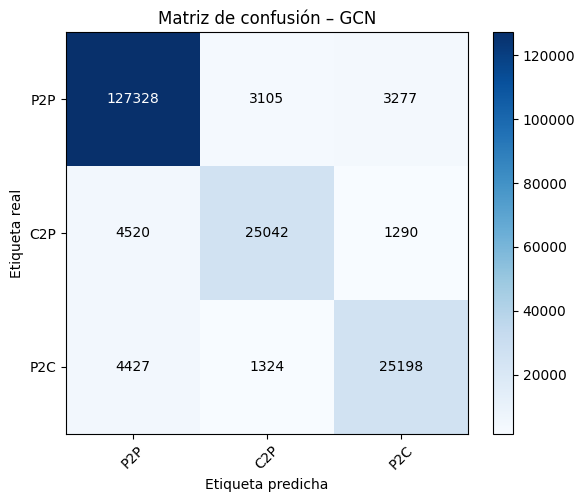

Matriz de confusión normalizada (%)


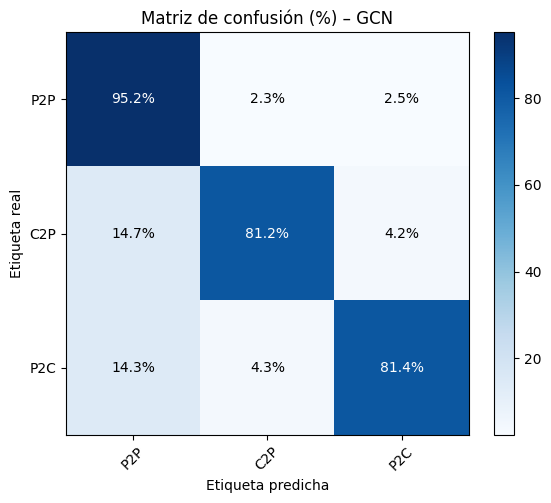

              precision    recall  f1-score   support

           0     0.9343    0.9523    0.9432    133710
           1     0.8497    0.8117    0.8303     30852
           2     0.8466    0.8142    0.8301     30949

    accuracy                         0.9082    195511
   macro avg     0.8769    0.8594    0.8678    195511
weighted avg     0.9071    0.9082    0.9075    195511



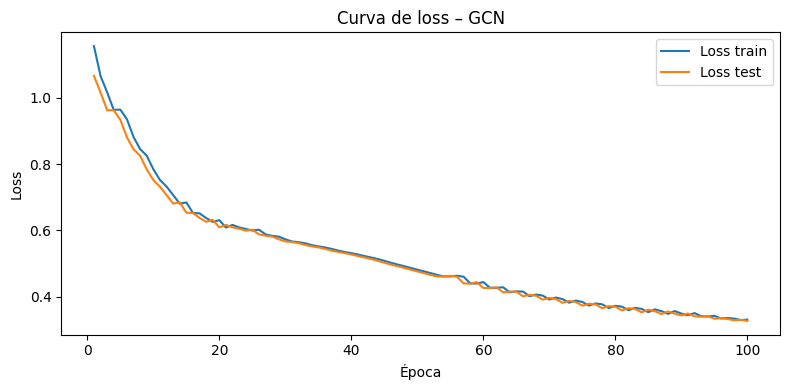

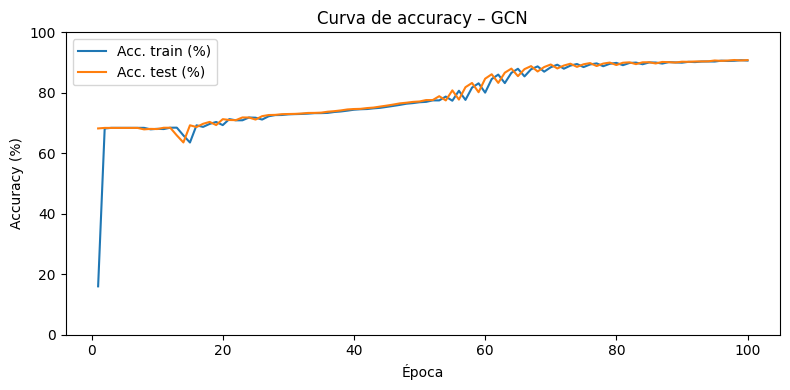


=== Training GraphSAGE (Bilinear) ===
ep01  loss_tr 1.6702 acc_tr 31.10% | loss_te 1.2645 acc_te 65.30%
ep10  loss_tr 0.7456 acc_tr 74.56% | loss_te 0.7354 acc_te 75.04%
ep20  loss_tr 0.6182 acc_tr 78.14% | loss_te 0.6039 acc_te 78.37%
ep30  loss_tr 0.5370 acc_tr 80.31% | loss_te 0.5261 acc_te 80.63%
ep40  loss_tr 0.4759 acc_tr 82.12% | loss_te 0.4678 acc_te 82.28%
ep50  loss_tr 0.4210 acc_tr 85.27% | loss_te 0.4133 acc_te 85.61%
ep60  loss_tr 0.3722 acc_tr 87.56% | loss_te 0.3667 acc_te 87.65%
ep70  loss_tr 0.3388 acc_tr 88.72% | loss_te 0.3351 acc_te 88.73%
ep80  loss_tr 0.3189 acc_tr 89.35% | loss_te 0.3189 acc_te 88.91%
ep90  loss_tr 0.3070 acc_tr 89.68% | loss_te 0.3032 acc_te 89.32%
ep100  loss_tr 0.2941 acc_tr 89.64% | loss_te 0.2925 acc_te 90.00%
Matriz de confusión sin normalizar


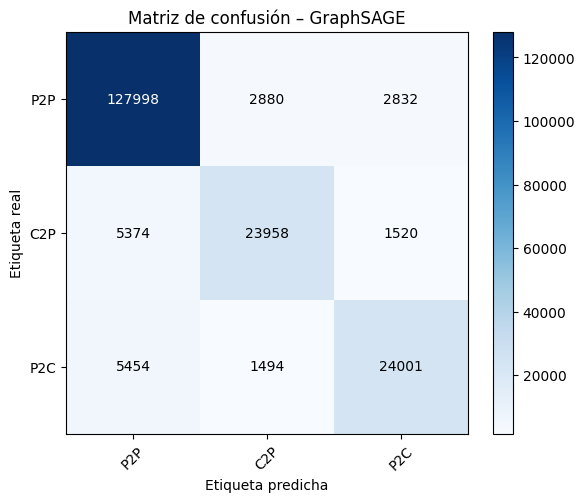

Matriz de confusión normalizada (%)


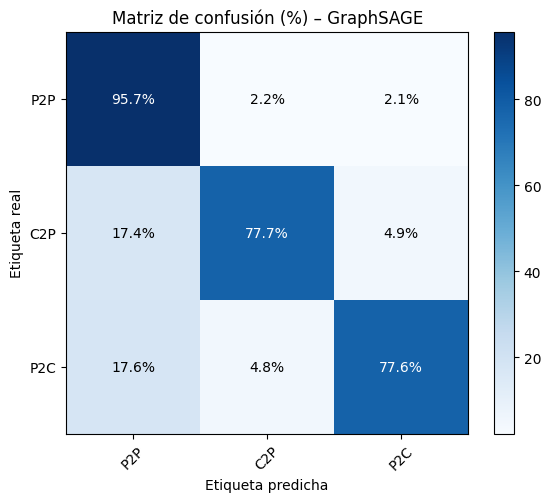

              precision    recall  f1-score   support

           0     0.9220    0.9573    0.9393    133710
           1     0.8456    0.7765    0.8096     30852
           2     0.8465    0.7755    0.8094     30949

    accuracy                         0.9000    195511
   macro avg     0.8714    0.8364    0.8528    195511
weighted avg     0.8980    0.9000    0.8983    195511



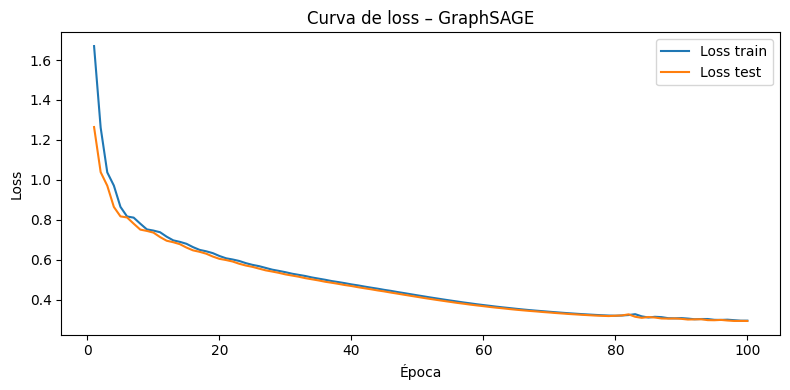

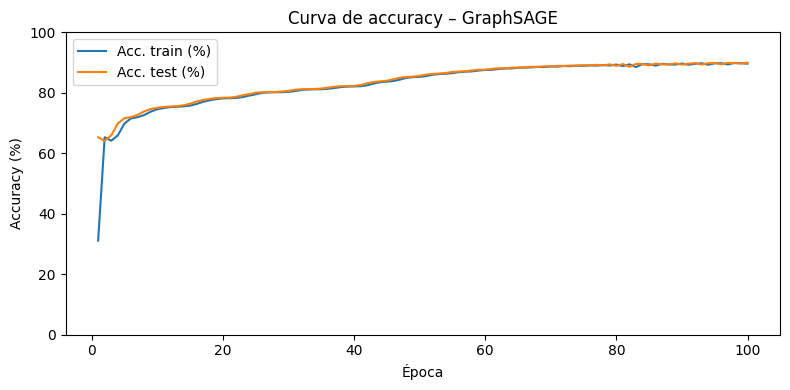


=== Training GAT (Bilinear) ===
ep01  loss_tr 1.1451 acc_tr 15.31% | loss_te 1.0853 acc_te 64.18%
ep10  loss_tr 0.8077 acc_tr 68.66% | loss_te 0.7825 acc_te 69.90%
ep20  loss_tr 0.5838 acc_tr 78.45% | loss_te 0.5562 acc_te 79.02%
ep30  loss_tr 0.4839 acc_tr 80.93% | loss_te 0.4774 acc_te 80.83%
ep40  loss_tr 0.4550 acc_tr 82.05% | loss_te 0.4494 acc_te 82.18%
ep50  loss_tr 0.4355 acc_tr 82.56% | loss_te 0.4330 acc_te 82.84%
ep60  loss_tr 0.4204 acc_tr 83.24% | loss_te 0.4175 acc_te 83.48%
ep70  loss_tr 0.4005 acc_tr 84.66% | loss_te 0.3967 acc_te 84.98%
ep80  loss_tr 0.3734 acc_tr 86.14% | loss_te 0.3690 acc_te 86.40%
ep90  loss_tr 0.3367 acc_tr 87.83% | loss_te 0.3324 acc_te 88.07%
ep100  loss_tr 0.3132 acc_tr 89.04% | loss_te 0.3186 acc_te 88.98%
Matriz de confusión sin normalizar


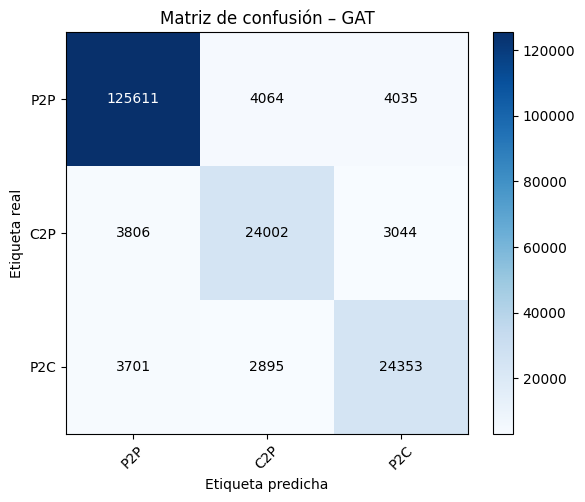

Matriz de confusión normalizada (%)


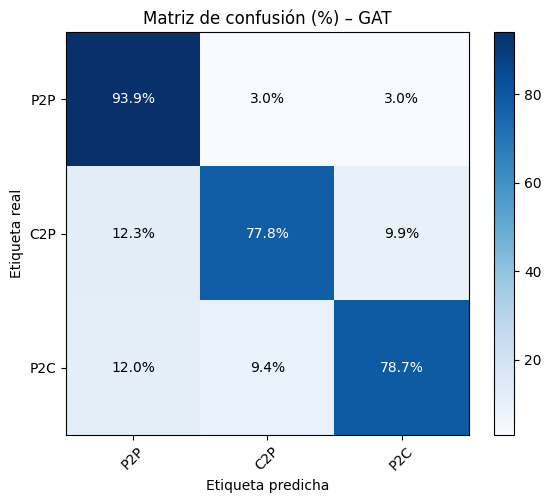

              precision    recall  f1-score   support

           0     0.9436    0.9394    0.9415    133710
           1     0.7752    0.7780    0.7766     30852
           2     0.7748    0.7869    0.7808     30949

    accuracy                         0.8898    195511
   macro avg     0.8312    0.8348    0.8330    195511
weighted avg     0.8903    0.8898    0.8900    195511



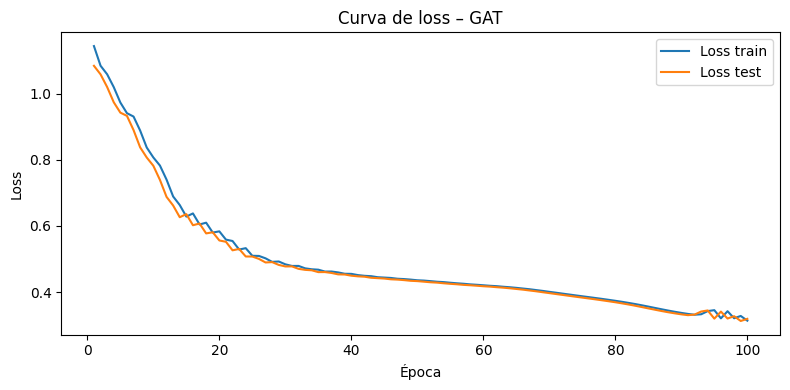

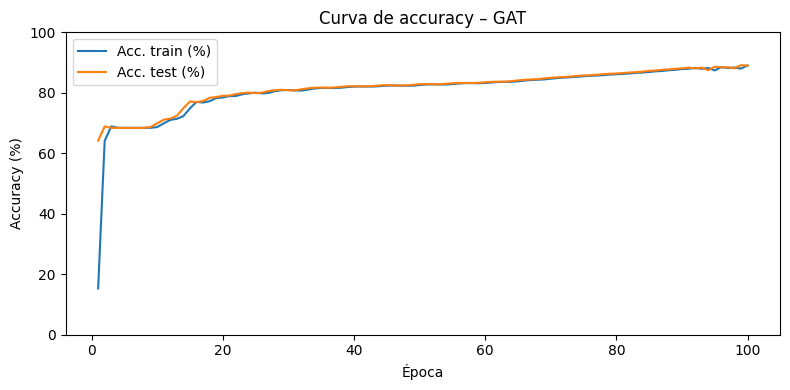

In [8]:
import torch, itertools, torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt

# ─── parámetros básicos ─────────────────────────────────────────────
in_feats      = gnn.dgl_graph.ndata["feat"].shape[1]
hidden_feats  = 32
emb_dim       = 16
n_classes     = 3
epochs        = 100
lr            = 1e-2
device        = "cuda" if torch.cuda.is_available() else "cpu"

# ─── datos y máscaras ───────────────────────────────────────────────
g       = gnn.dgl_graph.to(device)
feat    = g.ndata["feat"].to(device)
labels  = g.edata["Relationship"].long().to(device)

train_m = g.edata["train_mask"].to(device)
test_m  = g.edata["test_mask"].to(device)

# ─── entrenamiento ─────────────────────────────────────────────────
import torch, torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix


for name, Model in models.items():
    print(f"\n=== Training {name} (Bilinear) ===")

    history = {"loss_tr": [], "acc_tr": [], "loss_te": [], "acc_te": []}


    model = Model(in_feats, hidden_feats, emb_dim, out_feats_mlp=n_classes).to(device)
    opt   = torch.optim.Adam(model.parameters(), lr=lr)

    best_loss, patience, wait = 1e9, 8, 0          # early-stopping

    for epoch in range(1, epochs + 1):
        # ---------- train ----------
        model.train()
        h      = model.encode(g, feat)
        logits = model.decodeBilinear(g, h)         # (E, 3)

        loss   = F.cross_entropy(logits[train_m], labels[train_m])
        opt.zero_grad(); loss.backward(); opt.step()

        with torch.no_grad():
            preds_tr = logits[train_m].argmax(1)
            acc_tr   = (preds_tr == labels[train_m]).float().mean().item()

        # ---------- test ----------
        model.eval()
        with torch.no_grad():
            logits_ = model.decodeBilinear(g, model.encode(g, feat))
            loss_te = F.cross_entropy(logits_[test_m], labels[test_m])
            preds_t = logits_[test_m].argmax(1)
            acc_t   = (preds_t == labels[test_m]).float().mean().item()


        # guarda históricos
        history["loss_tr"].append(loss.item())
        history["acc_tr"].append(acc_tr*100)
        history["loss_te"].append(loss_te.item())
        history["acc_te"].append(acc_t*100)

        # early stopping
        if loss_te < best_loss - 1e-4:
            best_loss, wait = loss_te, 0
            best_w = model.state_dict()
        else:
            wait += 1
            if wait >= patience:
                print(f"🛑  Early stop en epoch {epoch}")
                break

        if epoch % 10 == 0 or epoch == 1:
            print(f"ep{epoch:02d}  loss_tr {loss:.4f} acc_tr {acc_tr:.2%} | "
                  f"loss_te {loss_te:.4f} acc_te {acc_t:.2%}")

    # ---------- matriz de confusión final ----------
    model.load_state_dict(best_w)
    with torch.no_grad():
        logits_best = model.decodeBilinear(g, model.encode(g, feat))
        preds_best  = logits_best[test_m].argmax(1).cpu()
        truth       = labels[test_m].cpu()

    cm = confusion_matrix(truth, preds_best)
    plot_confusion_matrix_2(cm, classes=["P2P","C2P","P2C"],
                            normalize=False,
                            title=f"Matriz de confusión – {name}")
    plot_confusion_matrix_2(cm, classes=["P2P","C2P","P2C"],
                            normalize=True,
                            title=f"Matriz de confusión (%) – {name}")

    print(classification_report(truth, preds_best, digits=4))

    # ─── gráficas de Loss y Accuracy ───────────────────────────────────
    import matplotlib.pyplot as plt
    epoch_axis = range(1, len(history["loss_tr"]) + 1)

    plt.figure(figsize=(8,4))
    plt.plot(epoch_axis, history["loss_tr"],  label="Loss train")
    plt.plot(epoch_axis, history["loss_te"],  label="Loss test")
    plt.xlabel("Época"); plt.ylabel("Loss"); plt.title(f"Curva de loss – {name}")
    plt.legend(); plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8,4))
    plt.plot(epoch_axis, history["acc_tr"],  label="Acc. train (%)")
    plt.plot(epoch_axis, history["acc_te"],  label="Acc. test (%)")
    plt.xlabel("Época"); plt.ylabel("Accuracy (%)"); plt.title(f"Curva de accuracy – {name}")
    plt.ylim(0, 100); plt.legend(); plt.tight_layout()
    plt.show()


    # Compute confusion matrix
    # # Guaradar el modelo
    # torch.save(model.state_dict(), f'data/model_emb_{model_name}.pth')

    # # Guardar los embeddings
    # torch.save(h, f"data/embeddings_ribs_DP_{model_name}.pt")



#### Encoder: Bilinar


=== Training GCN (Bilinear) ===
ep01  loss_tr 1.1221 acc_tr 15.14% | loss_te 1.0494 acc_te 68.34%
ep10  loss_tr 0.7852 acc_tr 67.14% | loss_te 0.7304 acc_te 69.08%
ep20  loss_tr 0.5940 acc_tr 70.92% | loss_te 0.5775 acc_te 72.12%
ep30  loss_tr 0.5307 acc_tr 73.67% | loss_te 0.5260 acc_te 73.95%
ep40  loss_tr 0.4664 acc_tr 77.18% | loss_te 0.4619 acc_te 77.18%
ep50  loss_tr 0.4071 acc_tr 86.28% | loss_te 0.4014 acc_te 85.04%
Matriz de confusión sin normalizar


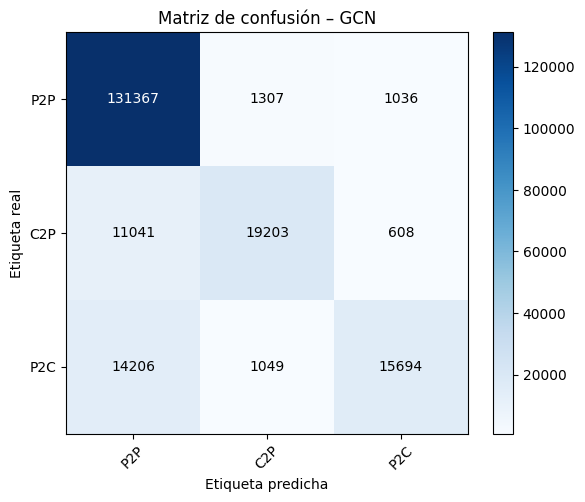

Matriz de confusión normalizada (%)


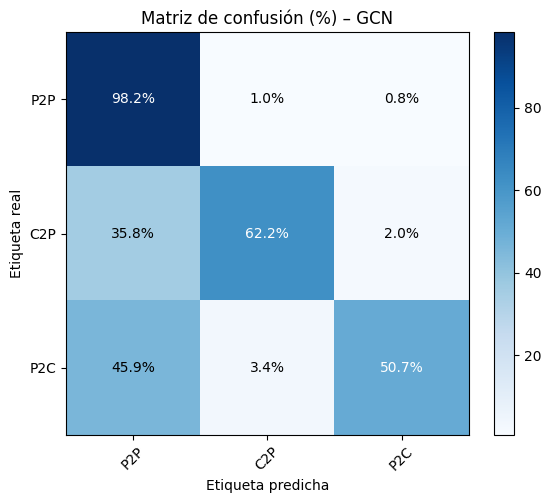

              precision    recall  f1-score   support

           0     0.8388    0.9825    0.9050    133710
           1     0.8907    0.6224    0.7328     30852
           2     0.9052    0.5071    0.6500     30949

    accuracy                         0.8504    195511
   macro avg     0.8782    0.7040    0.7626    195511
weighted avg     0.8575    0.8504    0.8374    195511



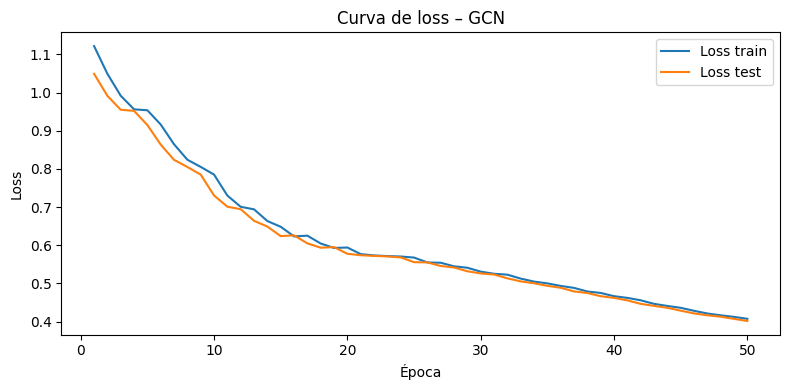

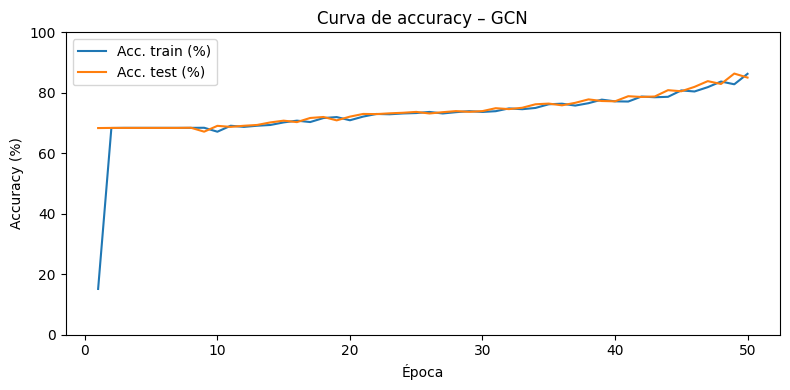


=== Training GraphSAGE (Bilinear) ===
ep01  loss_tr 1.6006 acc_tr 22.49% | loss_te 1.1764 acc_te 65.13%
ep10  loss_tr 0.7028 acc_tr 74.49% | loss_te 0.6826 acc_te 75.53%
ep20  loss_tr 0.5549 acc_tr 78.25% | loss_te 0.5370 acc_te 78.74%
ep30  loss_tr 0.4225 acc_tr 86.75% | loss_te 0.4117 acc_te 87.30%
ep40  loss_tr 0.3633 acc_tr 88.30% | loss_te 0.3557 acc_te 88.47%
ep50  loss_tr 0.3314 acc_tr 88.90% | loss_te 0.3262 acc_te 89.09%
Matriz de confusión sin normalizar


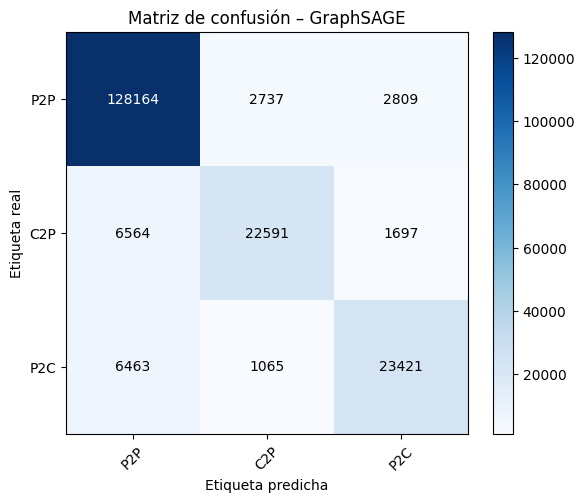

Matriz de confusión normalizada (%)


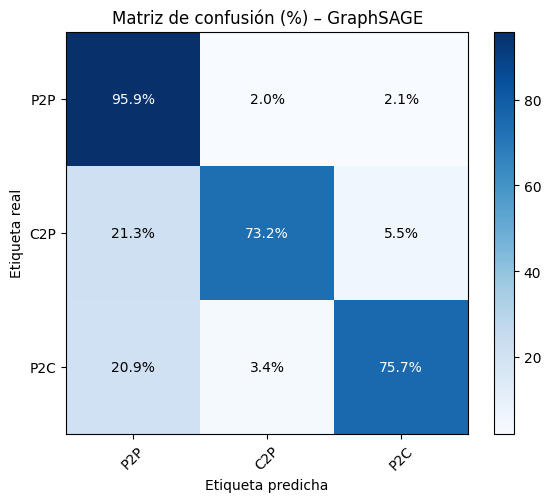

              precision    recall  f1-score   support

           0     0.9077    0.9585    0.9324    133710
           1     0.8559    0.7322    0.7893     30852
           2     0.8387    0.7568    0.7956     30949

    accuracy                         0.8909    195511
   macro avg     0.8674    0.8158    0.8391    195511
weighted avg     0.8886    0.8909    0.8882    195511



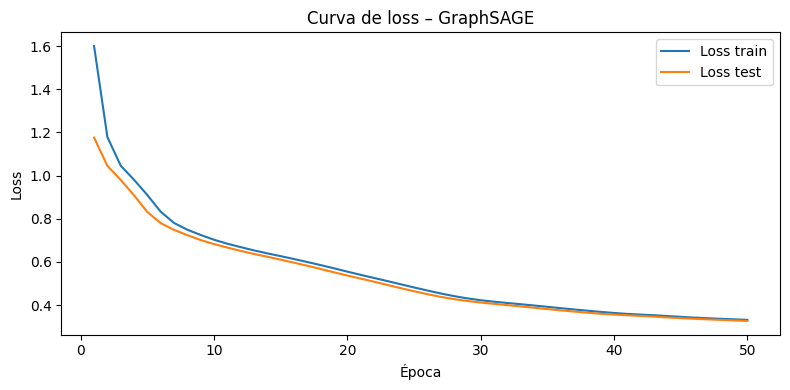

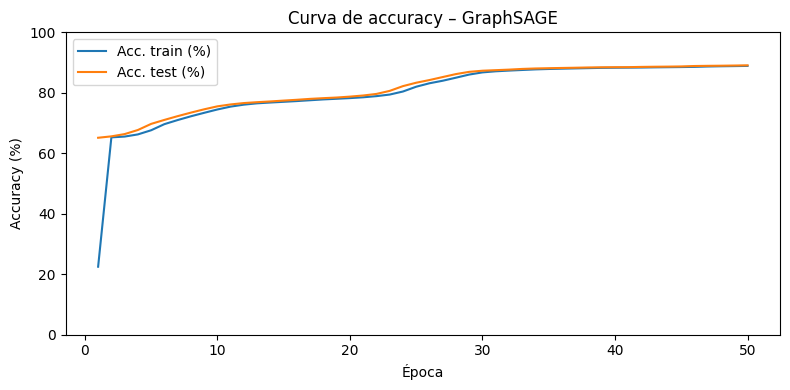


=== Training GAT (Bilinear) ===
ep01  loss_tr 1.1167 acc_tr 68.82% | loss_te 1.0472 acc_te 68.47%
ep10  loss_tr 0.6392 acc_tr 74.66% | loss_te 0.6517 acc_te 76.55%
ep20  loss_tr 0.5337 acc_tr 79.51% | loss_te 0.5280 acc_te 79.34%
ep30  loss_tr 0.4824 acc_tr 81.88% | loss_te 0.4731 acc_te 82.18%
ep40  loss_tr 0.4334 acc_tr 83.01% | loss_te 0.4281 acc_te 83.21%
ep50  loss_tr 0.3913 acc_tr 85.23% | loss_te 0.3850 acc_te 85.65%
Matriz de confusión sin normalizar


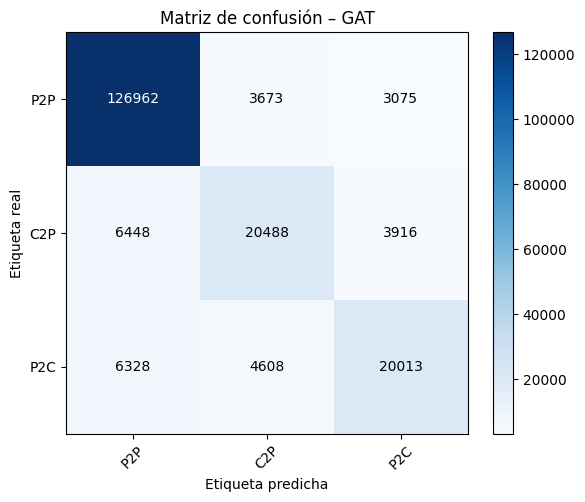

Matriz de confusión normalizada (%)


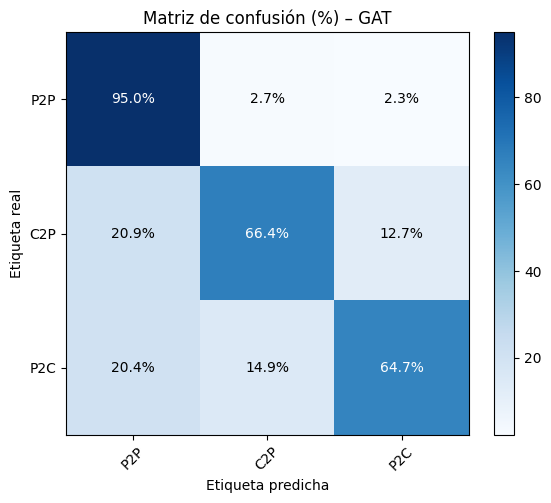

              precision    recall  f1-score   support

           0     0.9086    0.9495    0.9286    133710
           1     0.7122    0.6641    0.6873     30852
           2     0.7411    0.6466    0.6907     30949

    accuracy                         0.8565    195511
   macro avg     0.7873    0.7534    0.7688    195511
weighted avg     0.8511    0.8565    0.8529    195511



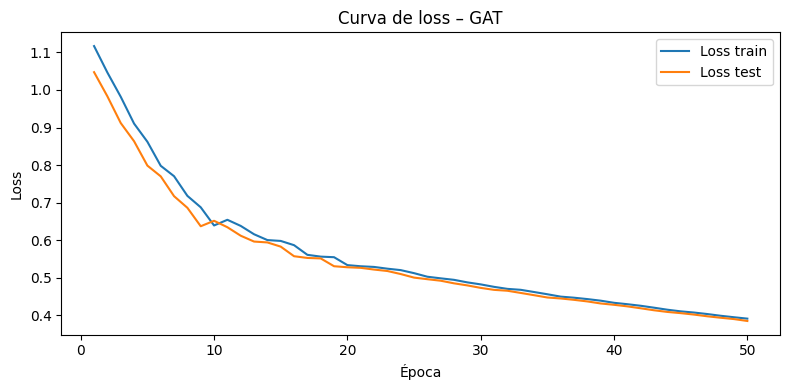

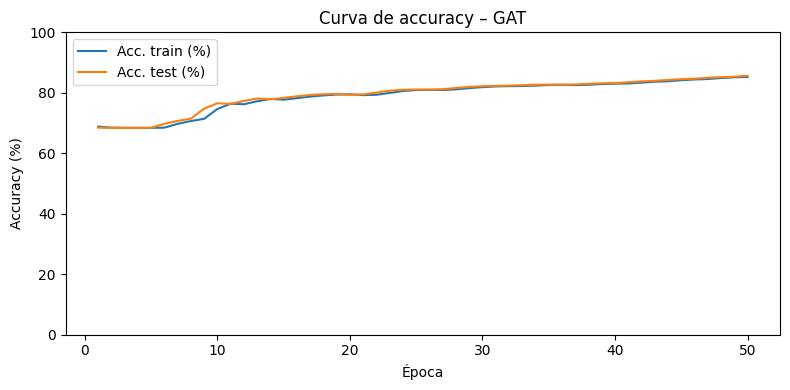

In [7]:
import torch, itertools, torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt

# ─── parámetros básicos ─────────────────────────────────────────────
in_feats      = gnn.dgl_graph.ndata["feat"].shape[1]
hidden_feats  = 32
emb_dim       = 16
n_classes     = 3
epochs        = 50
lr            = 1e-2
device        = "cuda" if torch.cuda.is_available() else "cpu"

# ─── datos y máscaras ───────────────────────────────────────────────
g       = gnn.dgl_graph.to(device)
feat    = g.ndata["feat"].to(device)
labels  = g.edata["Relationship"].long().to(device)

train_m = g.edata["train_mask"].to(device)
test_m  = g.edata["test_mask"].to(device)

# ─── entrenamiento ─────────────────────────────────────────────────
import torch, torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix



for name, Model in models.items():
    print(f"\n=== Training {name} (Bilinear) ===")
    history = {"loss_tr": [], "acc_tr": [], "loss_te": [], "acc_te": []}

    model = Model(in_feats, hidden_feats, emb_dim, out_feats_mlp=n_classes).to(device)
    opt   = torch.optim.Adam(model.parameters(), lr=lr)

    best_loss, patience, wait = 1e9, 8, 0          # early-stopping

    for epoch in range(1, epochs + 1):
        # ---------- train ----------
        model.train()
        h      = model.encode(g, feat)
        logits = model.decodeBilinear(g, h)         # (E, 3)

        loss   = F.cross_entropy(logits[train_m], labels[train_m])
        opt.zero_grad(); loss.backward(); opt.step()

        with torch.no_grad():
            preds_tr = logits[train_m].argmax(1)
            acc_tr   = (preds_tr == labels[train_m]).float().mean().item()

        # ---------- test ----------
        model.eval()
        with torch.no_grad():
            logits_ = model.decodeBilinear(g, model.encode(g, feat))
            loss_te = F.cross_entropy(logits_[test_m], labels[test_m])
            preds_t = logits_[test_m].argmax(1)
            acc_t   = (preds_t == labels[test_m]).float().mean().item()

        # guarda históricos
        history["loss_tr"].append(loss.item())
        history["acc_tr"].append(acc_tr*100)
        history["loss_te"].append(loss_te.item())
        history["acc_te"].append(acc_t*100)

        # early stopping
        if loss_te < best_loss - 1e-4:
            best_loss, wait = loss_te, 0
            best_w = model.state_dict()
        else:
            wait += 1
            if wait >= patience:
                print(f"🛑  Early stop en epoch {epoch}")
                break

        if epoch % 10 == 0 or epoch == 1:
            print(f"ep{epoch:02d}  loss_tr {loss:.4f} acc_tr {acc_tr:.2%} | "
                  f"loss_te {loss_te:.4f} acc_te {acc_t:.2%}")

    # ---------- matriz de confusión final ----------
    model.load_state_dict(best_w)
    with torch.no_grad():
        logits_best = model.decodeBilinear(g, model.encode(g, feat))
        preds_best  = logits_best[test_m].argmax(1).cpu()
        truth       = labels[test_m].cpu()

    cm = confusion_matrix(truth, preds_best)
    plot_confusion_matrix_2(cm, classes=["P2P","C2P","P2C"],
                            normalize=False,
                            title=f"Matriz de confusión – {name}")
    plot_confusion_matrix_2(cm, classes=["P2P","C2P","P2C"],
                            normalize=True,
                            title=f"Matriz de confusión (%) – {name}")

    print(classification_report(truth, preds_best, digits=4))

    # ─── gráficas de Loss y Accuracy ───────────────────────────────────
    import matplotlib.pyplot as plt
    epoch_axis = range(1, len(history["loss_tr"]) + 1)

    plt.figure(figsize=(8,4))
    plt.plot(epoch_axis, history["loss_tr"],  label="Loss train")
    plt.plot(epoch_axis, history["loss_te"],  label="Loss test")
    plt.xlabel("Época"); plt.ylabel("Loss"); plt.title(f"Curva de loss – {name}")
    plt.legend(); plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8,4))
    plt.plot(epoch_axis, history["acc_tr"],  label="Acc. train (%)")
    plt.plot(epoch_axis, history["acc_te"],  label="Acc. test (%)")
    plt.xlabel("Época"); plt.ylabel("Accuracy (%)"); plt.title(f"Curva de accuracy – {name}")
    plt.ylim(0, 100); plt.legend(); plt.tight_layout()
    plt.show()


### Caso 2: Con attr = degre

In [5]:
models = {
    'GCN': GCN,
    'GraphSAGE': GraphSAGE,
    'GAT': GAT,
}

In [ ]:
RELATIONSHIPS_FILE = '/home/valentina/Desktop/GIT/TrabajoTesis/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2'
INTERNETGRAPH_FILE = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024Degree/febrero'

gnn = GNN(debug=True)

# Cargo dataset y etiqueto sgun archivo de relaciones
gnn.load_dataset(
    data_path=INTERNETGRAPH_FILE,  # Grafo internet no etiquetado
    force_reload=True,
    index_graph = 1,  # Indice del grafo a cargar febrero
    simplify=True,            # ⇐ hazlo sólo una vez
    caida_path=RELATIONSHIPS_FILE  # Archivo CAIDA AS Relationships
)

gnn.split_edges_classification(train_size=0.5, seed=42)



[load_dataset] Leyendo CSV …
Done saving data into cached files.
[load_dataset] Grafo Graph(num_nodes=42683, num_edges=157675438,
      ndata_schemes={'feat': Scheme(shape=(2,), dtype=torch.float32)}
      edata_schemes={})
[load_dataset] Simplificando  …
[load_dataset] Etiquetando CAIDA → /home/valentina/Desktop/GIT/TrabajoTesis/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2


Etiquetando CAIDA: 488952it [00:01, 411681.61it/s]


[CAIDA] Añadidas 977288 aristas que faltaban
[CAIDA] Conteo final de etiquetas 0/1/2/-1 → Counter({-1: 699046, 0: 668732, 2: 154411, 1: 154411})
[load_dataset] etiquetas 0/1/2/-1 → Counter({-1: 699046, 0: 668732, 2: 154411, 1: 154411})
[split] train=782042  test=195512
  clases train: {0: 534690, 2: 123676, 1: 123676}


#### Encode : Bilinear


=== Training GCN (Bilinear) ===
ep01  loss_tr 1.1253 acc_tr 13.94% | loss_te 1.0723 acc_te 57.54%
ep10  loss_tr 0.7788 acc_tr 68.44% | loss_te 0.7586 acc_te 68.83%
ep20  loss_tr 0.6311 acc_tr 70.60% | loss_te 0.6224 acc_te 71.42%
ep30  loss_tr 0.5726 acc_tr 72.87% | loss_te 0.5690 acc_te 72.96%
ep40  loss_tr 0.5052 acc_tr 74.15% | loss_te 0.4972 acc_te 74.93%
ep50  loss_tr 0.4324 acc_tr 85.83% | loss_te 0.4249 acc_te 83.58%
ep60  loss_tr 0.3749 acc_tr 90.23% | loss_te 0.3929 acc_te 88.56%
ep70  loss_tr 0.3542 acc_tr 90.21% | loss_te 0.3425 acc_te 90.45%
ep80  loss_tr 0.3309 acc_tr 90.51% | loss_te 0.3212 acc_te 90.87%
ep90  loss_tr 0.3105 acc_tr 90.97% | loss_te 0.3100 acc_te 90.94%
ep100  loss_tr 0.3010 acc_tr 91.08% | loss_te 0.2988 acc_te 91.14%
Matriz de confusión sin normalizar


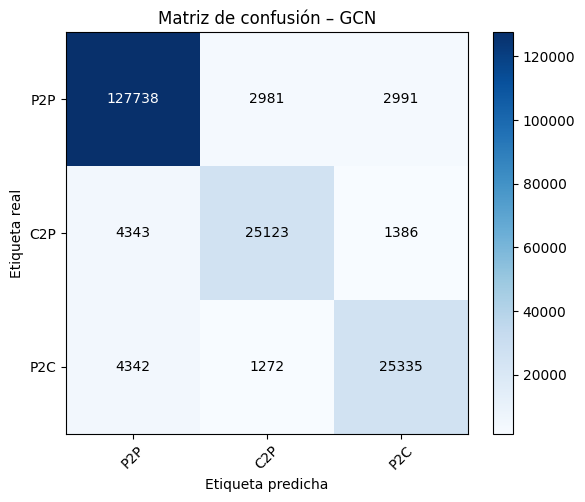

Matriz de confusión normalizada (%)


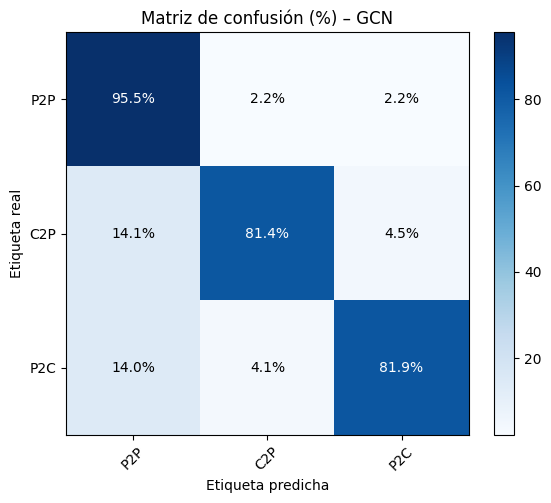

              precision    recall  f1-score   support

           0     0.9363    0.9553    0.9457    133710
           1     0.8552    0.8143    0.8343     30852
           2     0.8527    0.8186    0.8353     30949

    accuracy                         0.9114    195511
   macro avg     0.8814    0.8627    0.8718    195511
weighted avg     0.9103    0.9114    0.9107    195511



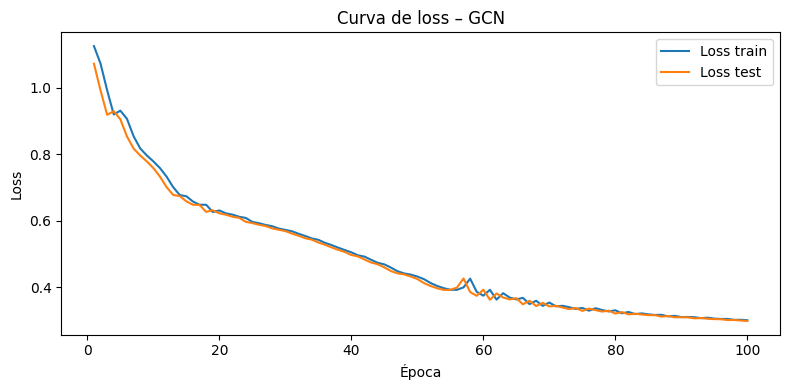

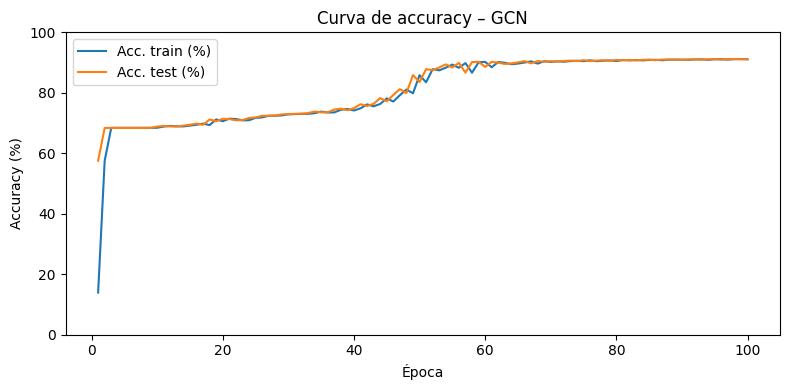


=== Training GraphSAGE (Bilinear) ===
ep01  loss_tr 1.5598 acc_tr 20.17% | loss_te 1.0721 acc_te 63.46%
ep10  loss_tr 0.6916 acc_tr 74.66% | loss_te 0.6710 acc_te 76.08%
ep20  loss_tr 0.5763 acc_tr 79.06% | loss_te 0.5629 acc_te 79.38%
ep30  loss_tr 0.4877 acc_tr 81.32% | loss_te 0.4778 acc_te 81.65%
ep40  loss_tr 0.4180 acc_tr 85.84% | loss_te 0.4086 acc_te 86.27%
ep50  loss_tr 0.3690 acc_tr 88.11% | loss_te 0.3618 acc_te 88.32%
ep60  loss_tr 0.3420 acc_tr 88.74% | loss_te 0.3351 acc_te 88.94%
ep70  loss_tr 0.3205 acc_tr 89.28% | loss_te 0.3145 acc_te 89.43%
ep80  loss_tr 0.3045 acc_tr 89.71% | loss_te 0.2997 acc_te 89.79%
ep90  loss_tr 0.2965 acc_tr 89.67% | loss_te 0.2899 acc_te 90.21%
ep100  loss_tr 0.2828 acc_tr 90.16% | loss_te 0.2802 acc_te 90.17%
Matriz de confusión sin normalizar


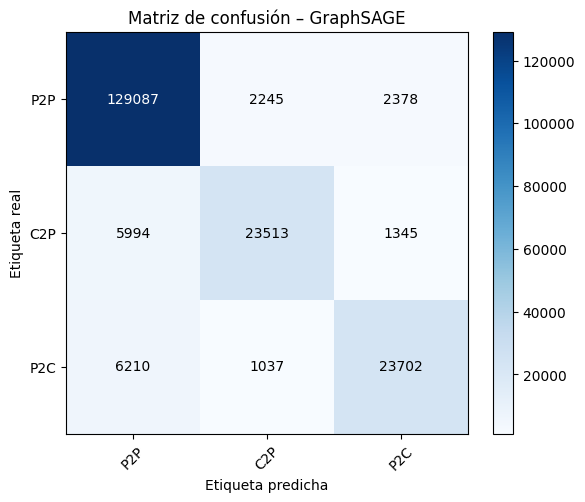

Matriz de confusión normalizada (%)


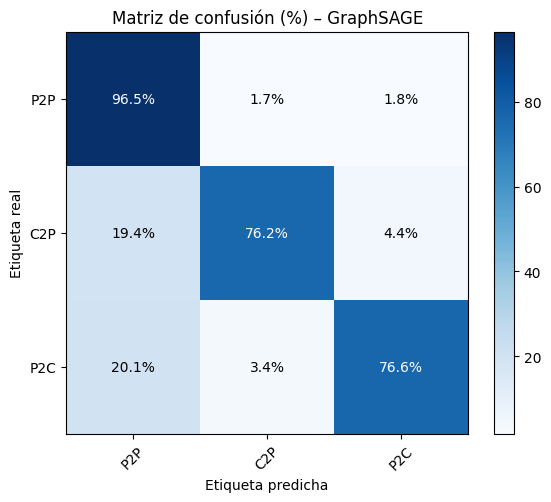

              precision    recall  f1-score   support

           0     0.9136    0.9654    0.9388    133710
           1     0.8775    0.7621    0.8158     30852
           2     0.8642    0.7658    0.8121     30949

    accuracy                         0.9017    195511
   macro avg     0.8851    0.8311    0.8555    195511
weighted avg     0.9001    0.9017    0.8993    195511



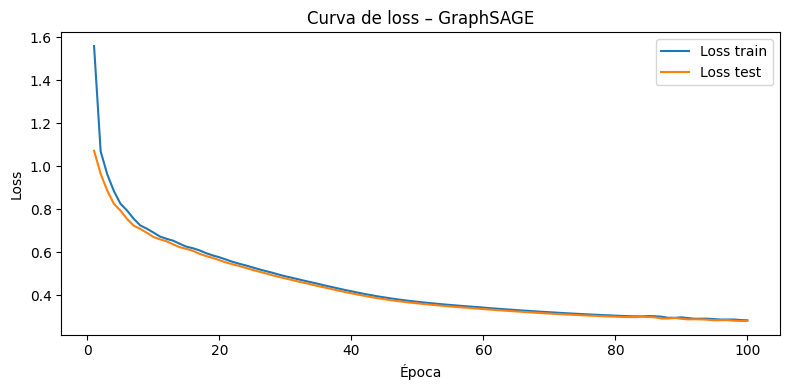

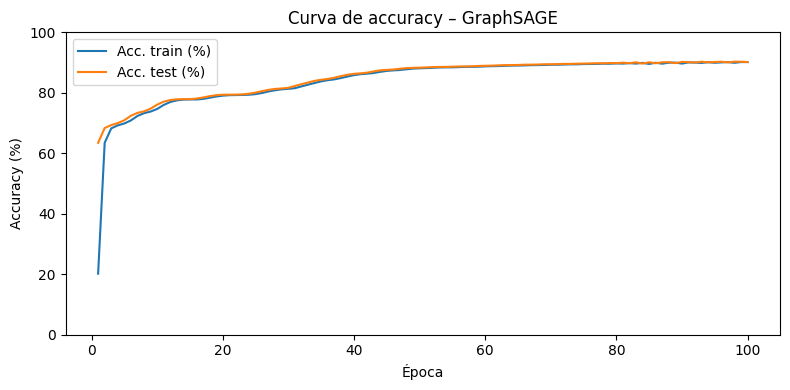


=== Training GAT (Bilinear) ===
ep01  loss_tr 1.1096 acc_tr 14.23% | loss_te 1.0526 acc_te 68.46%
ep10  loss_tr 0.6895 acc_tr 72.11% | loss_te 0.6696 acc_te 73.64%
ep20  loss_tr 0.5428 acc_tr 78.43% | loss_te 0.5274 acc_te 78.93%
ep30  loss_tr 0.4826 acc_tr 81.00% | loss_te 0.4774 acc_te 81.18%
ep40  loss_tr 0.4289 acc_tr 82.41% | loss_te 0.4233 acc_te 82.54%
ep50  loss_tr 0.3814 acc_tr 84.84% | loss_te 0.3761 acc_te 85.25%
ep60  loss_tr 0.3424 acc_tr 87.42% | loss_te 0.3377 acc_te 87.66%
ep70  loss_tr 0.3110 acc_tr 88.92% | loss_te 0.3130 acc_te 88.93%
ep80  loss_tr 0.2973 acc_tr 89.35% | loss_te 0.2926 acc_te 89.58%
ep90  loss_tr 0.2812 acc_tr 89.81% | loss_te 0.2805 acc_te 89.95%
ep100  loss_tr 0.2711 acc_tr 90.18% | loss_te 0.2696 acc_te 90.36%
Matriz de confusión sin normalizar


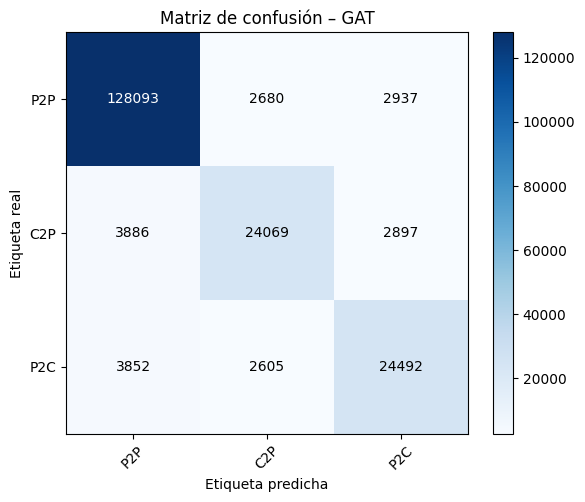

Matriz de confusión normalizada (%)


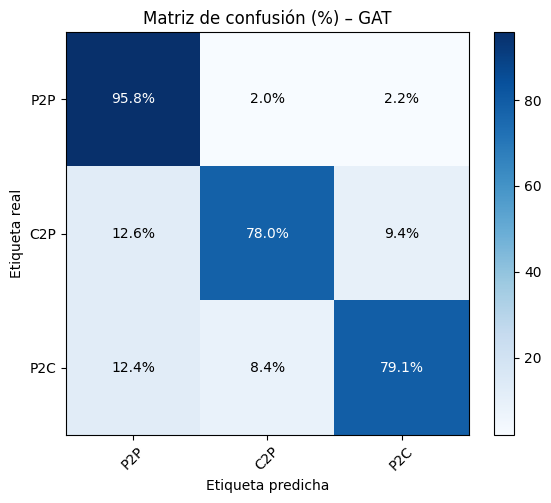

              precision    recall  f1-score   support

           0     0.9430    0.9580    0.9505    133710
           1     0.8200    0.7801    0.7996     30852
           2     0.8076    0.7914    0.7994     30949

    accuracy                         0.9036    195511
   macro avg     0.8569    0.8432    0.8498    195511
weighted avg     0.9022    0.9036    0.9027    195511



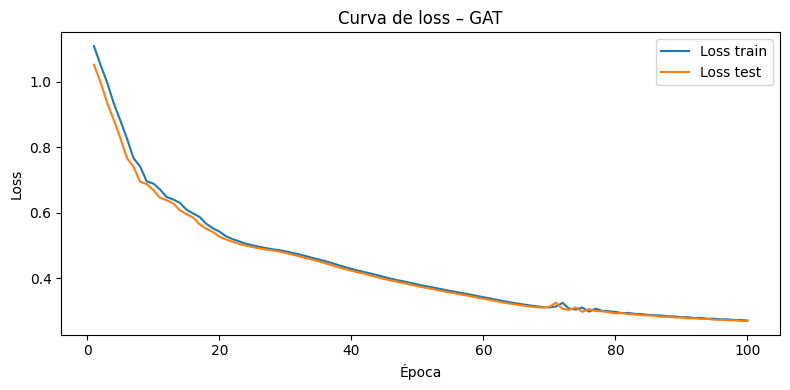

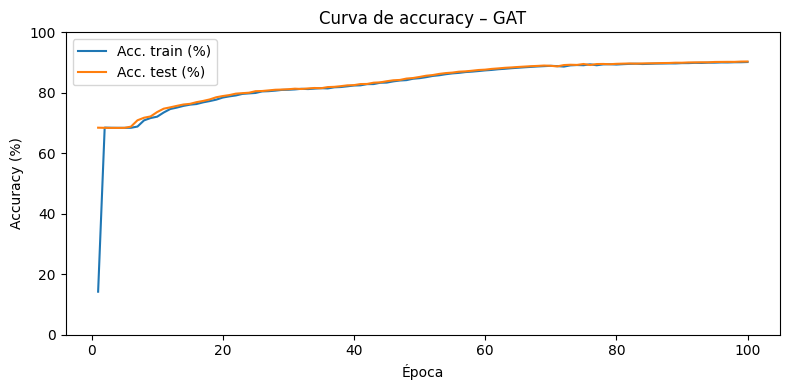

In [9]:
import torch, itertools, torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt

# ─── parámetros básicos ─────────────────────────────────────────────
in_feats      = gnn.dgl_graph.ndata["feat"].shape[1]
hidden_feats  = 32
emb_dim       = 16
n_classes     = 3
epochs        = 100
lr            = 1e-2
device        = "cuda" if torch.cuda.is_available() else "cpu"

# ─── datos y máscaras ───────────────────────────────────────────────
g       = gnn.dgl_graph.to(device)
feat    = g.ndata["feat"].to(device)
labels  = g.edata["Relationship"].long().to(device)

train_m = g.edata["train_mask"].to(device)
test_m  = g.edata["test_mask"].to(device)

# ─── entrenamiento ─────────────────────────────────────────────────
import torch, torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix


for name, Model in models.items():
    print(f"\n=== Training {name} (Bilinear) ===")

    history = {"loss_tr": [], "acc_tr": [], "loss_te": [], "acc_te": []}


    model = Model(in_feats, hidden_feats, emb_dim, out_feats_mlp=n_classes).to(device)
    opt   = torch.optim.Adam(model.parameters(), lr=lr)

    best_loss, patience, wait = 1e9, 8, 0          # early-stopping

    for epoch in range(1, epochs + 1):
        # ---------- train ----------
        model.train()
        h      = model.encode(g, feat)
        logits = model.decodeBilinear(g, h)         # (E, 3)

        loss   = F.cross_entropy(logits[train_m], labels[train_m])
        opt.zero_grad(); loss.backward(); opt.step()

        with torch.no_grad():
            preds_tr = logits[train_m].argmax(1)
            acc_tr   = (preds_tr == labels[train_m]).float().mean().item()

        # ---------- test ----------
        model.eval()
        with torch.no_grad():
            logits_ = model.decodeBilinear(g, model.encode(g, feat))
            loss_te = F.cross_entropy(logits_[test_m], labels[test_m])
            preds_t = logits_[test_m].argmax(1)
            acc_t   = (preds_t == labels[test_m]).float().mean().item()


        # guarda históricos
        history["loss_tr"].append(loss.item())
        history["acc_tr"].append(acc_tr*100)
        history["loss_te"].append(loss_te.item())
        history["acc_te"].append(acc_t*100)

        # early stopping
        if loss_te < best_loss - 1e-4:
            best_loss, wait = loss_te, 0
            best_w = model.state_dict()
        else:
            wait += 1
            if wait >= patience:
                print(f"🛑  Early stop en epoch {epoch}")
                break

        if epoch % 10 == 0 or epoch == 1:
            print(f"ep{epoch:02d}  loss_tr {loss:.4f} acc_tr {acc_tr:.2%} | "
                  f"loss_te {loss_te:.4f} acc_te {acc_t:.2%}")

    # ---------- matriz de confusión final ----------
    model.load_state_dict(best_w)
    with torch.no_grad():
        logits_best = model.decodeBilinear(g, model.encode(g, feat))
        preds_best  = logits_best[test_m].argmax(1).cpu()
        truth       = labels[test_m].cpu()

    cm = confusion_matrix(truth, preds_best)
    plot_confusion_matrix_2(cm, classes=["P2P","C2P","P2C"],
                            normalize=False,
                            title=f"Matriz de confusión – {name}")
    plot_confusion_matrix_2(cm, classes=["P2P","C2P","P2C"],
                            normalize=True,
                            title=f"Matriz de confusión (%) – {name}")

    print(classification_report(truth, preds_best, digits=4))

    # ─── gráficas de Loss y Accuracy ───────────────────────────────────
    import matplotlib.pyplot as plt
    epoch_axis = range(1, len(history["loss_tr"]) + 1)

    plt.figure(figsize=(8,4))
    plt.plot(epoch_axis, history["loss_tr"],  label="Loss train")
    plt.plot(epoch_axis, history["loss_te"],  label="Loss test")
    plt.xlabel("Época"); plt.ylabel("Loss"); plt.title(f"Curva de loss – {name}")
    plt.legend(); plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8,4))
    plt.plot(epoch_axis, history["acc_tr"],  label="Acc. train (%)")
    plt.plot(epoch_axis, history["acc_te"],  label="Acc. test (%)")
    plt.xlabel("Época"); plt.ylabel("Accuracy (%)"); plt.title(f"Curva de accuracy – {name}")
    plt.ylim(0, 100); plt.legend(); plt.tight_layout()
    plt.show()

    # Compute confusion matrix
    # # Guaradar el modelo
    # torch.save(model.state_dict(), f'data/model_emb_{model_name}.pth')

    # # Guardar los embeddings
    # torch.save(h, f"data/embeddings_ribs_DP_{model_name}.pt")


#### Encoder : MLP


=== Training GCN ===
ep01 | loss_tr 1.0462 acc_tr 68.41% | loss_te 0.9860 acc_te 68.39%
ep10 | loss_tr 0.7087 acc_tr 68.32% | loss_te 0.7178 acc_te 65.11%
ep20 | loss_tr 0.6594 acc_tr 67.71% | loss_te 0.6500 acc_te 69.41%
ep30 | loss_tr 0.6353 acc_tr 69.58% | loss_te 0.6319 acc_te 70.10%
ep40 | loss_tr 0.5969 acc_tr 72.24% | loss_te 0.5896 acc_te 72.49%
ep50 | loss_tr 0.5449 acc_tr 75.45% | loss_te 0.5395 acc_te 75.65%
Matriz de confusión sin normalizar


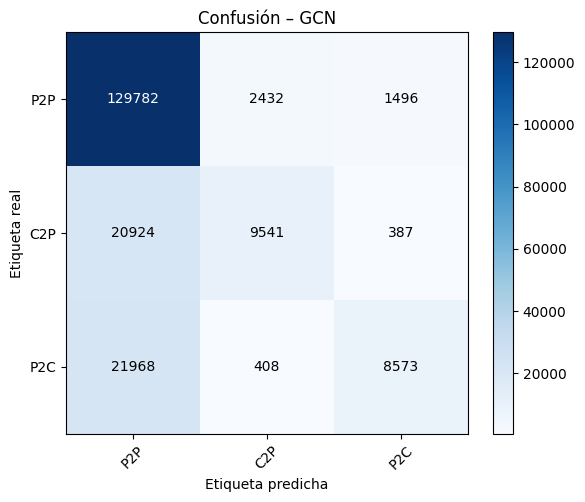

Matriz de confusión normalizada (%)


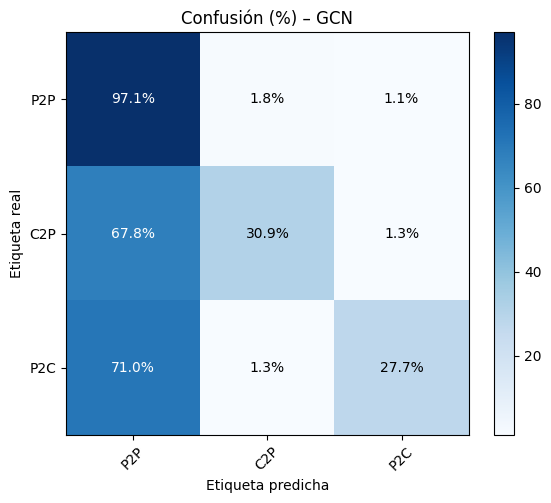

              precision    recall  f1-score   support

           0     0.7516    0.9706    0.8472    133710
           1     0.7706    0.3093    0.4414     30852
           2     0.8199    0.2770    0.4141     30949

    accuracy                         0.7565    195511
   macro avg     0.7807    0.5190    0.5676    195511
weighted avg     0.7654    0.7565    0.7146    195511



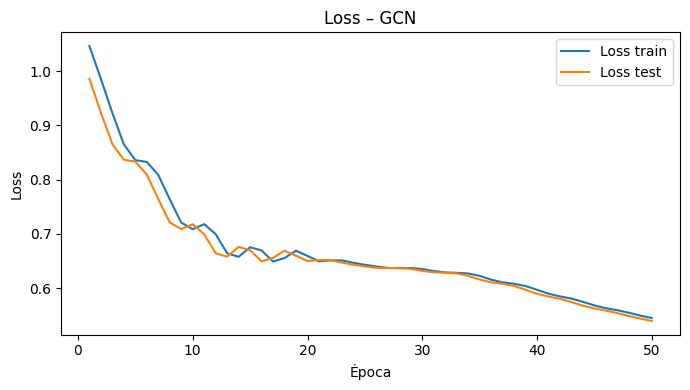

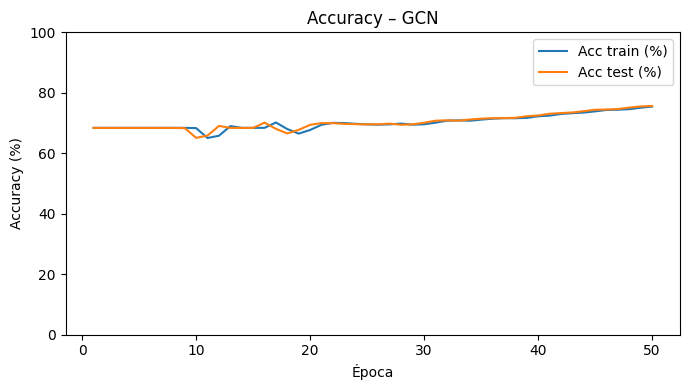


=== Training GraphSAGE ===
ep01 | loss_tr 1.0866 acc_tr 16.23% | loss_te 1.0279 acc_te 67.37%
ep10 | loss_tr 0.7432 acc_tr 72.24% | loss_te 0.7284 acc_te 74.50%
ep20 | loss_tr 0.6339 acc_tr 77.80% | loss_te 0.6168 acc_te 78.03%
ep30 | loss_tr 0.4950 acc_tr 80.03% | loss_te 0.4779 acc_te 80.92%
ep40 | loss_tr 0.3815 acc_tr 87.06% | loss_te 0.3735 acc_te 87.31%
ep50 | loss_tr 0.3367 acc_tr 88.51% | loss_te 0.3309 acc_te 88.70%
Matriz de confusión sin normalizar


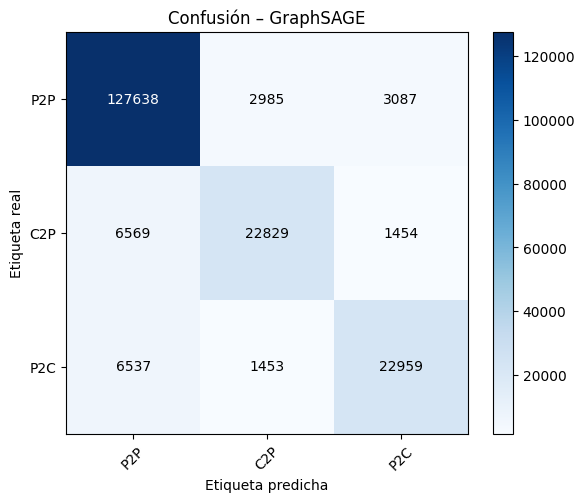

Matriz de confusión normalizada (%)


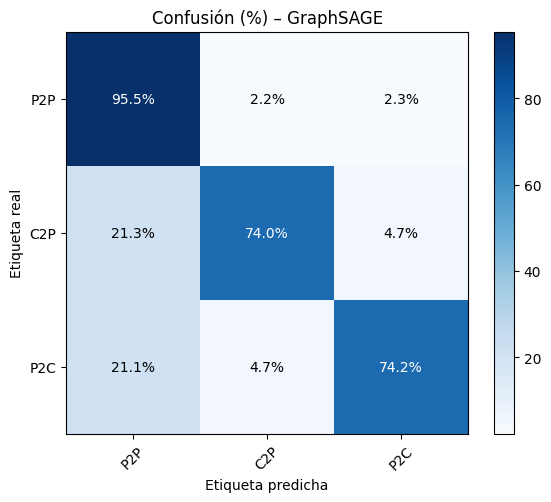

              precision    recall  f1-score   support

           0     0.9069    0.9546    0.9301    133710
           1     0.8372    0.7400    0.7856     30852
           2     0.8349    0.7418    0.7856     30949

    accuracy                         0.8870    195511
   macro avg     0.8597    0.8121    0.8338    195511
weighted avg     0.8845    0.8870    0.8844    195511



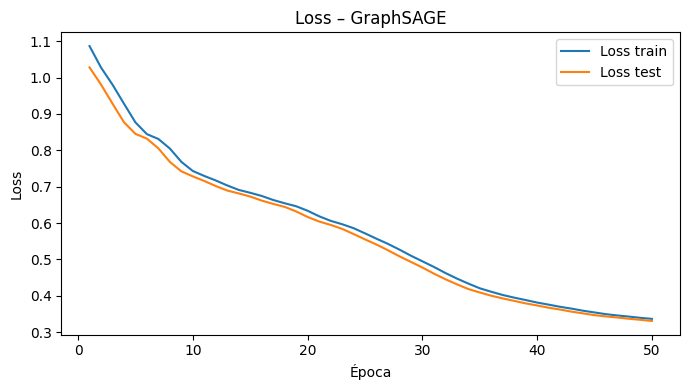

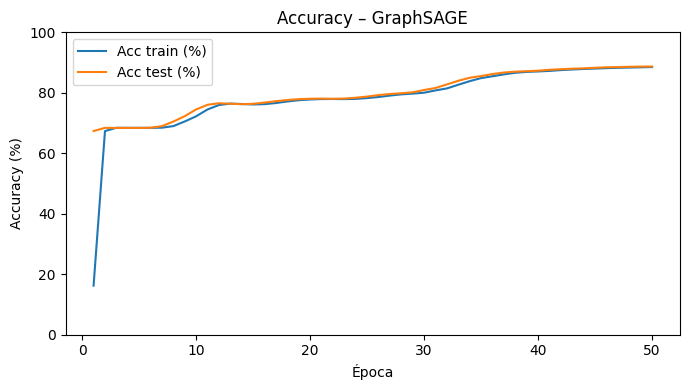


=== Training GAT ===
ep01 | loss_tr 1.2259 acc_tr 15.71% | loss_te 1.1335 acc_te 14.91%
ep10 | loss_tr 0.8153 acc_tr 68.41% | loss_te 0.8094 acc_te 68.39%
ep20 | loss_tr 0.7336 acc_tr 68.73% | loss_te 0.7215 acc_te 68.93%
ep30 | loss_tr 0.6506 acc_tr 70.87% | loss_te 0.6363 acc_te 71.36%
ep40 | loss_tr 0.5238 acc_tr 80.05% | loss_te 0.5150 acc_te 80.08%
ep50 | loss_tr 0.4508 acc_tr 83.02% | loss_te 0.4421 acc_te 83.95%
Matriz de confusión sin normalizar


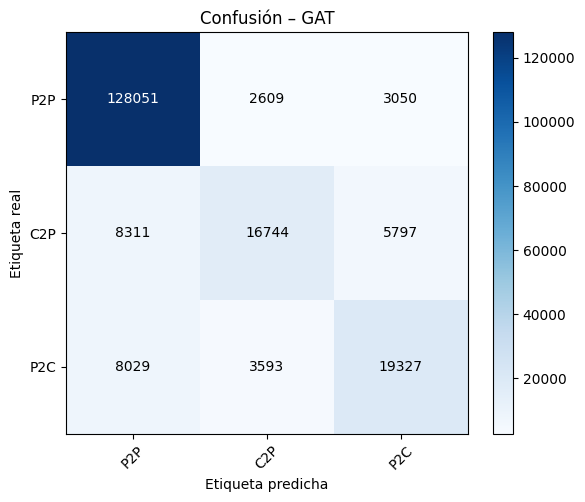

Matriz de confusión normalizada (%)


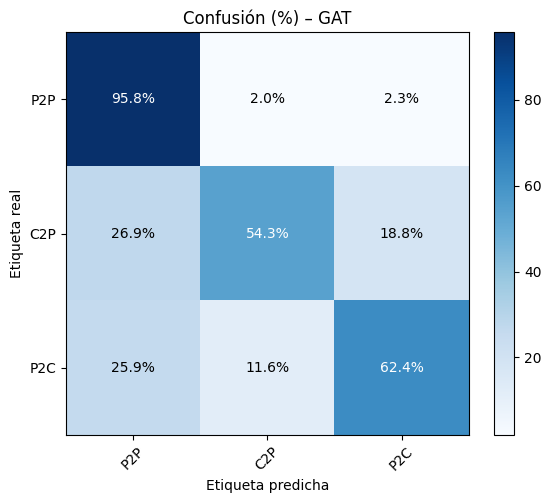

              precision    recall  f1-score   support

           0     0.8868    0.9577    0.9209    133710
           1     0.7297    0.5427    0.6225     30852
           2     0.6860    0.6245    0.6538     30949

    accuracy                         0.8395    195511
   macro avg     0.7675    0.7083    0.7324    195511
weighted avg     0.8302    0.8395    0.8315    195511



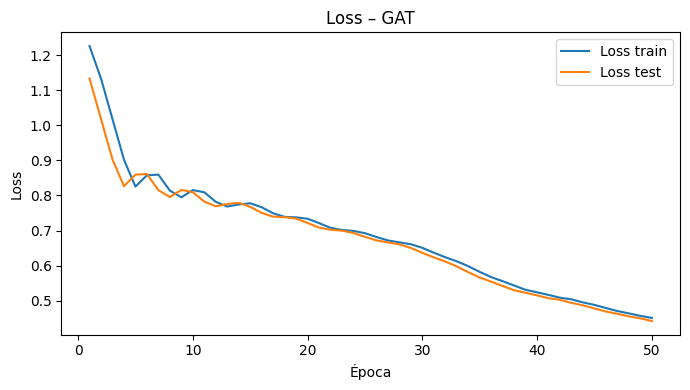

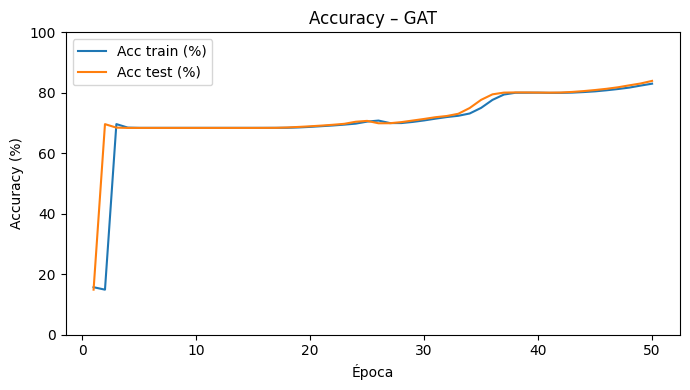

In [10]:
import torch, torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# ─── parámetros globales ────────────────────────────────────────────
in_feats  = gnn.dgl_graph.ndata["feat"].shape[1]
device    = "cuda" if torch.cuda.is_available() else "cpu"
epochs    = 50
lr        = 1e-2
patience  = 8           # early-stopping
n_classes = 3

# ─── datos y máscaras ───────────────────────────────────────────────
g       = gnn.dgl_graph.to(device)
feat    = g.ndata["feat"].to(device)
labels  = g.edata["Relationship"].long().to(device)
train_m = g.edata["train_mask"].to(device)
test_m  = g.edata["test_mask"].to(device)

for name, Model in models.items():
    print(f"\n=== Training {name} ===")

    model = Model(in_feats, 32, 16, out_feats_mlp=n_classes).to(device)
    opt   = torch.optim.Adam(model.parameters() , lr=lr)

    # histórico por modelo
    hist = {"loss_tr": [], "acc_tr": [], "loss_te": [], "acc_te": []}
    best_loss, wait = 1e9, 0

    for ep in range(1, epochs + 1):
        # ---------- train ----------
        model.train()
        h      = model.encode(g, feat)
        logits = model.decodeMLP(g, h)                  # (E, 3)

        loss   = F.cross_entropy(logits[train_m], labels[train_m])
        opt.zero_grad(); loss.backward(); opt.step()

        with torch.no_grad():
            preds_tr = logits[train_m].argmax(1)
            acc_tr   = (preds_tr == labels[train_m]).float().mean().item()

        # ---------- test ----------
        model.eval()
        with torch.no_grad():
            logits_t = model.decodeMLP(g, model.encode(g, feat))
            loss_te  = F.cross_entropy(logits_t[test_m], labels[test_m])
            preds_t  = logits_t[test_m].argmax(1)
            acc_t    = (preds_t == labels[test_m]).float().mean().item()

        # guarda histórico
        hist["loss_tr"].append(loss.item())
        hist["acc_tr"].append(acc_tr * 100)
        hist["loss_te"].append(loss_te.item())
        hist["acc_te"].append(acc_t * 100)

        # early-stopping
        if loss_te < best_loss - 1e-4:
            best_loss, wait = loss_te, 0
            best_w = model.state_dict()
        else:
            wait += 1
            if wait >= patience:
                print(f"🛑  Early stop en época {ep}")
                break

        if ep % 10 == 0 or ep == 1:
            print(f"ep{ep:02d} | loss_tr {loss:.4f} acc_tr {acc_tr:.2%} | "
                  f"loss_te {loss_te:.4f} acc_te {acc_t:.2%}")

    # ---------- evaluación final ----------
    model.load_state_dict(best_w)
    with torch.no_grad():
        logits_best = model.decodeMLP(g, model.encode(g, feat))
        preds_best  = logits_best[test_m].argmax(1).cpu()
        truth       = labels[test_m].cpu()

    cm = confusion_matrix(truth, preds_best)
    plot_confusion_matrix_2(cm, ["P2P","C2P","P2C"], False,
                            title=f"Confusión – {name}")
    plot_confusion_matrix_2(cm, ["P2P","C2P","P2C"], True,
                            title=f"Confusión (%) – {name}")

    print(classification_report(truth, preds_best, digits=4))

    # ---------- curvas de entrenamiento ----------
    epochs_done = range(1, len(hist["loss_tr"]) + 1)

    plt.figure(figsize=(7,4))
    plt.plot(epochs_done, hist["loss_tr"], label="Loss train")
    plt.plot(epochs_done, hist["loss_te"], label="Loss test")
    plt.xlabel("Época"); plt.ylabel("Loss"); plt.title(f"Loss – {name}")
    plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(epochs_done, hist["acc_tr"], label="Acc train (%)")
    plt.plot(epochs_done, hist["acc_te"], label="Acc test (%)")
    plt.xlabel("Época"); plt.ylabel("Accuracy (%)"); plt.ylim(0,100)
    plt.title(f"Accuracy – {name}")
    plt.legend(); plt.tight_layout(); plt.show()



### Caso 3: Con Random Neighbour Sampling

In [5]:
from modules.gnn_models import GCNSampler, GraphSAGESample, GATSample

models = {
    "GCN-Sampler":  GCNSampler,
    "SAGE-Sampler": GraphSAGESample,
    "GAT-Sampler":  GATSample
}


In [ ]:
RELATIONSHIPS_FILE = '/home/valentina/Desktop/GIT/TrabajoTesis/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2'
INTERNETGRAPH_FILE = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024/febrero'

gnn = GNN(debug=True)

# Cargo dataset y etiqueto sgun archivo de relaciones
gnn.load_dataset(
    data_path=INTERNETGRAPH_FILE,  # Grafo internet no etiquetado
    force_reload=True,
    index_graph = 1,  # Indice del grafo a cargar febrero
    simplify=True,            # ⇐ hazlo sólo una vez
    caida_path=RELATIONSHIPS_FILE  # Archivo CAIDA AS Relationships
)

gnn.split_edges_classification(train_size=0.5, seed=42)
# crea máscaras + devuelve eids
train_eids, test_eids = gnn.split_edges_classification(0.8, seed=42, return_eids=True)


[load_dataset] Leyendo CSV …
Done saving data into cached files.
[load_dataset] Grafo Graph(num_nodes=42683, num_edges=157675438,
      ndata_schemes={'feat': Scheme(shape=(68,), dtype=torch.float32)}
      edata_schemes={})
[load_dataset] Simplificando  …
[load_dataset] Etiquetando CAIDA → /home/valentina/Desktop/GIT/TrabajoTesis/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2


Etiquetando CAIDA: 488952it [00:01, 456857.42it/s]


[CAIDA] Añadidas 977288 aristas que faltaban
[CAIDA] Conteo final de etiquetas 0/1/2/-1 → Counter({-1: 699046, 0: 668732, 2: 154411, 1: 154411})
[load_dataset] etiquetas 0/1/2/-1 → Counter({-1: 699046, 0: 668732, 2: 154411, 1: 154411})
[split] train=782042  test=195512
  clases train: {0: 534690, 2: 123676, 1: 123676}
[split] train=782042  test=195512
  clases train: {0: 534690, 2: 123676, 1: 123676}


In [7]:
from collections import Counter
cnt = Counter(gnn.dgl_graph.edata['Relationship'][train_eids].tolist())
print(cnt)   # → algo como {0: 5 × 10⁶, 1: 8 × 10⁵, 2: 8 × 10⁵}


Counter({0: 534690, 2: 123676, 1: 123676})


AQUIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII


In [8]:
train_mask = gnn.dgl_graph.edata['train_mask']
test_mask = gnn.dgl_graph.edata['test_mask']

# Obtener índices de nodos de entrenamiento
train_nids = train_mask.nonzero(as_tuple=True)[0]

# Obtener índices de nodos de prueba
test_nids = test_mask.nonzero(as_tuple=True)[0]

print(f"TRAIN IDX: {train_mask}")
print(f"TEST IDX: {test_mask}")

print(f"TRAIN NIDS: {train_nids}")
print(f"TEST NIDS: {test_nids}")

TRAIN IDX: tensor([False, False, False,  ...,  True,  True,  True])
TEST IDX: tensor([False, False, False,  ..., False, False, False])
TRAIN NIDS: tensor([  25492,   27587,   38938,  ..., 1676597, 1676598, 1676599])
TEST NIDS: tensor([  39963,  141942,  146457,  ..., 1676579, 1676586, 1676587])


In [9]:
# Definir Dataloader y Sampler Training
sampler_train = dgl.dataloading.NeighborSampler([2, 2])


# Transformar el sampler para predicción de aristas
sampler_train = dgl.dataloading.as_edge_prediction_sampler(
    sampler_train, 
    # exclude='reverse_id',  # Excluir aristas inversas
    # reverse_eids=reverse_eids,  # Especificar las aristas inversas
    # negative_sampler=dgl.dataloading.negative_sampler.Uniform(5)  # Sampler negativo con 5 muestras negativas
)

train_dataloader = dgl.dataloading.DataLoader(
    # The following arguments are specific to DGL's DataLoader.
    gnn.dgl_graph,              # The graph
    train_nids,         # The node IDs to iterate over in minibatches
    sampler_train,            # The neighbor sampler
    # The following arguments are inherited from PyTorch DataLoader.
    batch_size=1000,    # Batch size
    shuffle=True,       # Whether to shuffle the nodes for every epoch
    drop_last=False,    # Whether to drop the last incomplete batch
    # num_workers=0       # Number of sampler processes
)



# Definir Dataloader y Sampler Evaluación ------------------------------------------------------------------
sampler_test = dgl.dataloading.NeighborSampler([2,2])


# Transformar el sampler para predicción de aristas
sampler_test = dgl.dataloading.as_edge_prediction_sampler(
    sampler_test, 
    # exclude='reverse_id',  # Excluir aristas inversas
    # reverse_eids=reverse_eids,  # Especificar las aristas inversas
    # negative_sampler=dgl.dataloading.negative_sampler.Uniform(5)  # Sampler negativo con 5 muestras negativas
)

test_dataloader = dgl.dataloading.DataLoader(
    # The following arguments are specific to DGL's DataLoader.
    gnn.dgl_graph,              # The graph
    test_nids,         # The node IDs to iterate over in minibatches
    sampler_test,            # The neighbor sampler
    # The following arguments are inherited from PyTorch DataLoader.
    batch_size=1000,    # Batch size
    shuffle=True,       # Whether to shuffle the nodes for every epoch
    drop_last=False,    # Whether to drop the last incomplete batch
    # num_workers=0       # Number of sampler processes
)

In [10]:
from modules.gnn_models import GCNSampler, GraphSAGESample, GATSample

models = {
    "GCN-Sampler": GCNSampler,
    "SAGE-Sampler": GraphSAGESample,
    "GAT-Sampler": GATSample
}

import tqdm


===== Entrenando GCN-Sampler =====


100%|██████████| 783/783 [00:06<00:00, 127.79it/s]


ep001 | loss_tr 0.7291 acc_tr 70.90% | loss_te 0.7482 acc_te 70.88%


100%|██████████| 783/783 [00:06<00:00, 111.90it/s]


ep005 | loss_tr 0.7002 acc_tr 72.05% | loss_te 0.7007 acc_te 72.04%


100%|██████████| 783/783 [00:09<00:00, 82.82it/s] 


ep010 | loss_tr 0.6954 acc_tr 72.28% | loss_te 0.7292 acc_te 71.82%


100%|██████████| 783/783 [00:06<00:00, 127.20it/s]


ep015 | loss_tr 0.6922 acc_tr 72.45% | loss_te 0.6967 acc_te 72.31%


100%|██████████| 783/783 [00:06<00:00, 127.75it/s]


ep020 | loss_tr 0.6911 acc_tr 72.52% | loss_te 0.6927 acc_te 72.54%


100%|██████████| 783/783 [00:06<00:00, 129.57it/s]


🛑  Early-stop en época 21
              precision    recall  f1-score   support

           0     0.7345    0.9684    0.8354    134042
           1     0.6393    0.1738    0.2734     30735
           2     0.6019    0.2039    0.3046     30735

    accuracy                         0.7233    195512
   macro avg     0.6586    0.4487    0.4711    195512
weighted avg     0.6987    0.7233    0.6636    195512



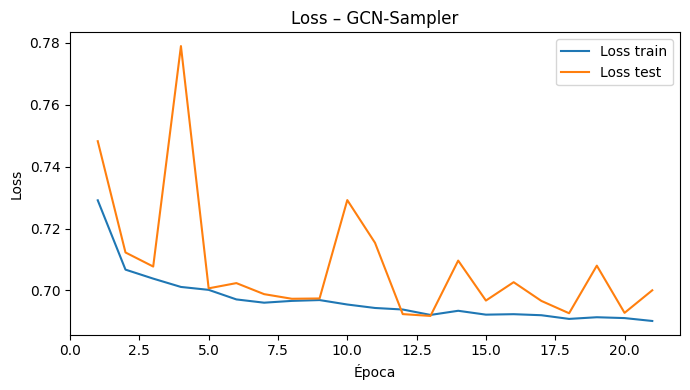

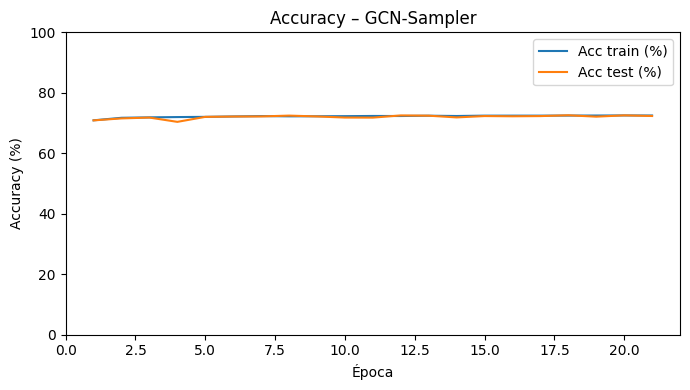

MAE = 0.4081 | R² = -0.1902

===== Entrenando SAGE-Sampler =====


  0%|          | 0/783 [00:00<?, ?it/s]/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/dgl/dataloading/dataloader.py:1144: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(
100%|██████████| 783/783 [00:06<00:00, 126.55it/s]


ep001 | loss_tr 0.7280 acc_tr 71.08% | loss_te 0.7326 acc_te 70.96%


100%|██████████| 783/783 [00:06<00:00, 112.36it/s]


ep005 | loss_tr 0.6983 acc_tr 72.15% | loss_te 0.7014 acc_te 72.24%


100%|██████████| 783/783 [00:06<00:00, 116.48it/s]


ep010 | loss_tr 0.6940 acc_tr 72.30% | loss_te 0.6952 acc_te 72.23%


100%|██████████| 783/783 [00:06<00:00, 127.57it/s]


ep015 | loss_tr 0.6912 acc_tr 72.46% | loss_te 0.6980 acc_te 72.43%


100%|██████████| 783/783 [00:06<00:00, 127.88it/s]


ep020 | loss_tr 0.6921 acc_tr 72.47% | loss_te 0.6900 acc_te 72.52%


100%|██████████| 783/783 [00:06<00:00, 129.87it/s]


🛑  Early-stop en época 21
              precision    recall  f1-score   support

           0     0.7356    0.9712    0.8372    134042
           1     0.6390    0.1711    0.2700     30735
           2     0.6250    0.2097    0.3141     30735

    accuracy                         0.7257    195512
   macro avg     0.6666    0.4507    0.4737    195512
weighted avg     0.7031    0.7257    0.6658    195512



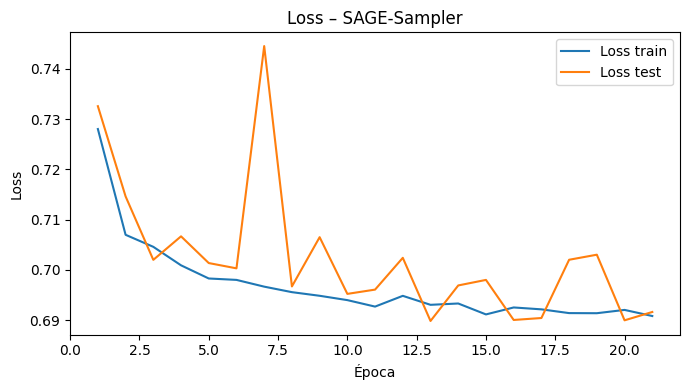

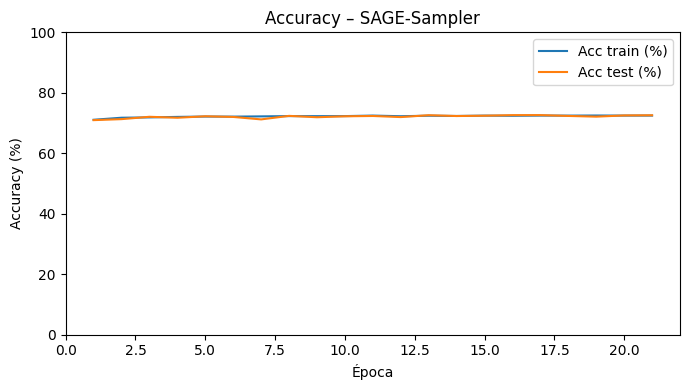

MAE = 0.4031 | R² = -0.1721

===== Entrenando GAT-Sampler =====


  0%|          | 0/783 [00:00<?, ?it/s]/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/dgl/dataloading/dataloader.py:1144: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(
100%|██████████| 783/783 [00:08<00:00, 92.41it/s]


ep001 | loss_tr 0.7644 acc_tr 71.00% | loss_te 0.7424 acc_te 71.84%


100%|██████████| 783/783 [00:08<00:00, 94.22it/s] 


ep005 | loss_tr 0.7291 acc_tr 72.27% | loss_te 0.7331 acc_te 71.98%


100%|██████████| 783/783 [00:08<00:00, 94.93it/s] 


ep010 | loss_tr 0.7261 acc_tr 72.40% | loss_te 0.7297 acc_te 72.32%


100%|██████████| 783/783 [00:09<00:00, 85.55it/s]


ep015 | loss_tr 0.7235 acc_tr 72.52% | loss_te 0.7277 acc_te 72.28%


100%|██████████| 783/783 [00:08<00:00, 95.49it/s] 


ep020 | loss_tr 0.7230 acc_tr 72.50% | loss_te 0.7219 acc_te 72.60%


100%|██████████| 783/783 [00:08<00:00, 88.77it/s]


ep025 | loss_tr 0.7234 acc_tr 72.50% | loss_te 0.7187 acc_te 72.78%


100%|██████████| 783/783 [00:09<00:00, 86.23it/s]


ep030 | loss_tr 0.7225 acc_tr 72.52% | loss_te 0.7205 acc_te 72.70%


100%|██████████| 783/783 [00:09<00:00, 80.61it/s]


ep035 | loss_tr 0.7205 acc_tr 72.68% | loss_te 0.7218 acc_te 72.60%


100%|██████████| 783/783 [00:09<00:00, 80.26it/s] 


🛑  Early-stop en época 40
              precision    recall  f1-score   support

           0     0.7535    0.9466    0.8391    134042
           1     0.5521    0.2644    0.3575     30735
           2     0.5795    0.2339    0.3333     30735

    accuracy                         0.7273    195512
   macro avg     0.6284    0.4816    0.5100    195512
weighted avg     0.6945    0.7273    0.6839    195512



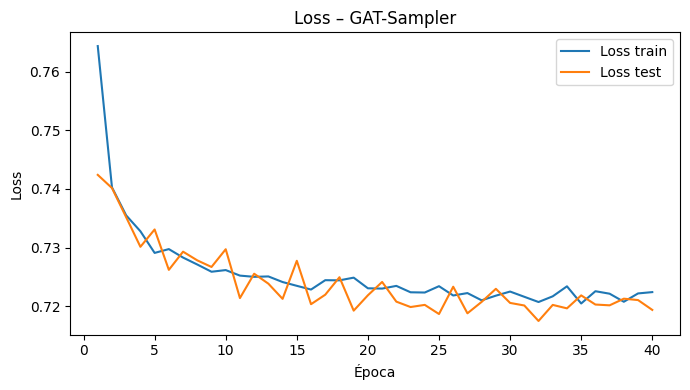

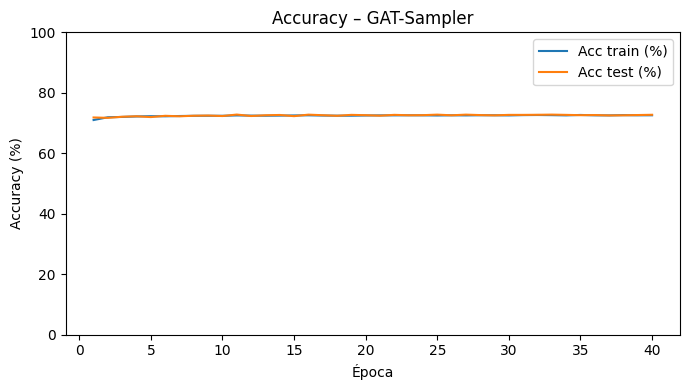

MAE = 0.3960 | R² = -0.1401


In [13]:
import tqdm, torch, torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, classification_report,
    mean_absolute_error, r2_score
)

# ─── hiperparámetros ───────────────────────────────────────────────
in_feats   = g.ndata['feat'].shape[1]
hidden_dim = 64
emb_dim    = 32
n_classes  = 3
epochs     = 50
lr         = 1e-2
patience   = 8
device     = "cuda" if torch.cuda.is_available() else "cpu"

# ─── bucle sobre modelos ───────────────────────────────────────────
for name, Model in models.items():
    print(f"\n===== Entrenando {name} =====")

    model = Model(in_feats, hidden_dim, emb_dim,
                  out_feats_mlp=n_classes).to(device)
    optim = torch.optim.Adam(model.parameters(), lr=lr)

    # almacenamos historial por época
    hist = {"loss_tr": [], "acc_tr": [], "loss_te": [], "acc_te": []}
    best_loss, best_state, wait = 1e9, None, 0         # early-stopping

    # ─── entrenamiento por época ────────────────────────────────
    for ep in range(1, epochs + 1):
        # ---- entrenamiento ------------------------------------
        model.train()
        loss_sum = corr = total = 0

        for input_nodes, output_graph, mfgs in tqdm.tqdm(
                train_dataloader):
            mfgs     = list(mfgs)
            edge_ids = output_graph.edata[dgl.EID].to(device)
            inputs        = mfgs[0].srcdata["feat"].to(device)
            y        = g.edata["Relationship"][edge_ids].long().to(device)

            h       = model.encode(mfgs, inputs)               # (N_batch, emb_dim)
            logits  = model.decodeMLP(output_graph, h)    # (E_batch, 3)

            loss = F.cross_entropy(logits, y)
            optim.zero_grad();  loss.backward();  optim.step()

            # métrica de accuracy en batch
            pred = logits.argmax(1)
            corr += (pred == y).sum().item()
            total += len(y)
            loss_sum += loss.item() * len(y)

        loss_tr = loss_sum / total
        acc_tr  = 100 * corr / total

        # ---- validación ---------------------------------------
        model.eval()
        loss_sum = corr = total = 0
        preds_all, labels_all = [], []

        with torch.no_grad():
            for input_nodes, output_graph, mfgs in test_dataloader:
                mfgs     = list(mfgs)
                edge_ids = output_graph.edata[dgl.EID].to(device)
                inputs   = mfgs[0].srcdata["feat"].to(device)
                y        = g.edata["Relationship"][edge_ids].long().to(device)

                h_val    = model.encode(mfgs, inputs)
                logits = model.decodeMLP(output_graph, h_val)

                loss_sum += F.cross_entropy(logits, y).item() * len(y)
                pred = logits.argmax(1)

                corr  += (pred == y).sum().item()
                total += len(y)

                preds_all.append(pred.cpu())
                labels_all.append(y.cpu())

        loss_te = loss_sum / total
        acc_te  = 100 * corr / total

        # ---- historial + early-stopping -----------------------
        hist["loss_tr"].append(loss_tr);  hist["loss_te"].append(loss_te)
        hist["acc_tr"].append(acc_tr);    hist["acc_te"].append(acc_te)

        if loss_te < best_loss - 1e-4:
            best_loss, wait = loss_te, 0
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
        else:
            wait += 1
            if wait >= patience:
                print(f"🛑  Early-stop en época {ep}")
                break

        if ep % 5 == 0 or ep == 1:
            print(f"ep{ep:03d} | "
                  f"loss_tr {loss_tr:.4f} acc_tr {acc_tr:.2f}% | "
                  f"loss_te {loss_te:.4f} acc_te {acc_te:.2f}%")

    # ─── evaluación final (con mejor modelo) ─────────────────────
    model.load_state_dict(best_state)
    preds = torch.cat(preds_all)
    truth = torch.cat(labels_all)

    cm = confusion_matrix(truth, preds)
    print(classification_report(truth, preds, digits=4))

    # ─── gráficos de historial ──────────────────────────────────
    ep_axis = range(1, len(hist["loss_tr"]) + 1)

    plt.figure(figsize=(7,4))
    plt.plot(ep_axis, hist["loss_tr"], label="Loss train")
    plt.plot(ep_axis, hist["loss_te"], label="Loss test")
    plt.xlabel("Época"); plt.ylabel("Loss"); plt.title(f"Loss – {name}")
    plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(ep_axis, hist["acc_tr"], label="Acc train (%)")
    plt.plot(ep_axis, hist["acc_te"], label="Acc test (%)")
    plt.xlabel("Época"); plt.ylabel("Accuracy (%)"); plt.ylim(0,100)
    plt.title(f"Accuracy – {name}")
    plt.legend(); plt.tight_layout(); plt.show()

    # ─── métricas numéricas tipo MAE / R² (opcional) ─────────────
    mae = mean_absolute_error(truth, preds)
    r2  = r2_score(truth, preds)
    print(f"MAE = {mae:.4f} | R² = {r2:.4f}")


### Caso 4: Crear represetaciones de los nodos desde 0

In [17]:
models = {
    'GCN': GCN,
    'GraphSAGE': GraphSAGE,
    'GAT': GAT,
}

In [18]:
RELATIONSHIPS_FILE = '/home/valentina/Desktop/GIT/TrabajoTesis/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2'
INTERNETGRAPH_FILE = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024/febrero'

gnn = GNN(debug=True)

# Cargo dataset y etiqueto sgun archivo de relaciones
gnn.load_dataset(
    data_path=INTERNETGRAPH_FILE,  # Grafo internet no etiquetado
    force_reload=True,
    index_graph = 1,  # Indice del grafo a cargar febrero
    simplify=True,            # ⇐ hazlo sólo una vez
    caida_path=RELATIONSHIPS_FILE  # Archivo CAIDA AS Relationships
)


# 64 features con poca varianza inicial
gnn.add_random_features(dim=64, std=0.05, seed=42, mode="minmax")


# crea máscaras + devuelve eids
train_eids, test_eids = gnn.split_edges_classification(0.8, seed=42, return_eids=True)

[load_dataset] Leyendo CSV …
Done saving data into cached files.
[load_dataset] Grafo Graph(num_nodes=42683, num_edges=157675438,
      ndata_schemes={'feat': Scheme(shape=(68,), dtype=torch.float32)}
      edata_schemes={})
[load_dataset] Simplificando  …
[load_dataset] Etiquetando CAIDA → /home/valentina/Desktop/GIT/TrabajoTesis/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2


Etiquetando CAIDA: 488952it [00:01, 420053.41it/s]


[CAIDA] Añadidas 977288 aristas que faltaban
[CAIDA] Conteo final de etiquetas 0/1/2/-1 → Counter({-1: 699046, 0: 668732, 2: 154411, 1: 154411})
[load_dataset] etiquetas 0/1/2/-1 → Counter({-1: 699046, 0: 668732, 2: 154411, 1: 154411})
[add_random_features] feat ← (401308, 64)  |  mode=minmax
[split] train=782042  test=195512
  clases train: {0: 534690, 2: 123676, 1: 123676}



=== Training GCN ===
ep01 | loss_tr 1.0555 acc_tr 46.19% | loss_te 0.8712 acc_te 68.56%
ep10 | loss_tr 0.5716 acc_tr 71.34% | loss_te 0.5918 acc_te 70.60%
ep20 | loss_tr 0.5661 acc_tr 70.86% | loss_te 0.5561 acc_te 71.66%
ep30 | loss_tr 0.5526 acc_tr 72.15% | loss_te 0.5457 acc_te 73.36%
ep40 | loss_tr 0.5396 acc_tr 74.47% | loss_te 0.5351 acc_te 74.91%
ep50 | loss_tr 0.5298 acc_tr 77.29% | loss_te 0.5250 acc_te 77.69%
ep60 | loss_tr 0.5203 acc_tr 79.45% | loss_te 0.5159 acc_te 79.80%
ep70 | loss_tr 0.5127 acc_tr 81.18% | loss_te 0.5086 acc_te 81.35%
ep80 | loss_tr 0.5213 acc_tr 80.32% | loss_te 0.5029 acc_te 82.34%
ep90 | loss_tr 0.5003 acc_tr 82.40% | loss_te 0.5004 acc_te 82.12%
ep100 | loss_tr 0.4933 acc_tr 82.89% | loss_te 0.4900 acc_te 82.93%
Matriz de confusión sin normalizar


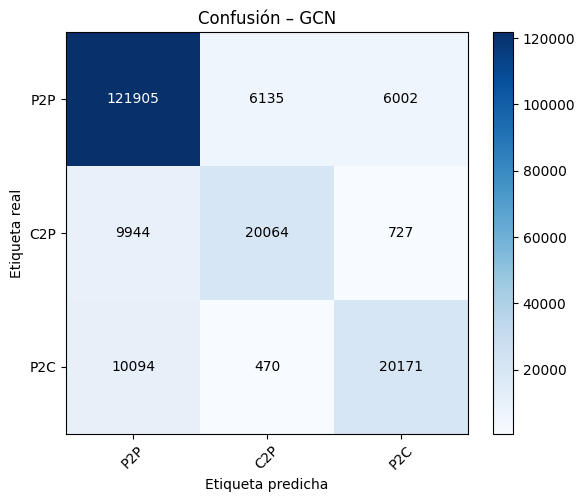

Matriz de confusión normalizada (%)


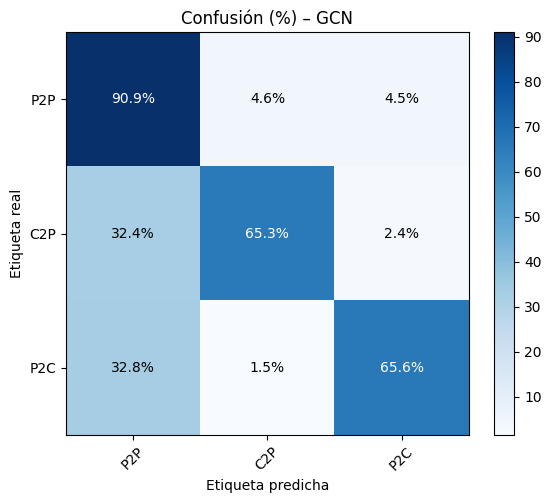

              precision    recall  f1-score   support

           0     0.8588    0.9095    0.8834    134042
           1     0.7523    0.6528    0.6990     30735
           2     0.7499    0.6563    0.7000     30735

    accuracy                         0.8293    195512
   macro avg     0.7870    0.7395    0.7608    195512
weighted avg     0.8250    0.8293    0.8256    195512



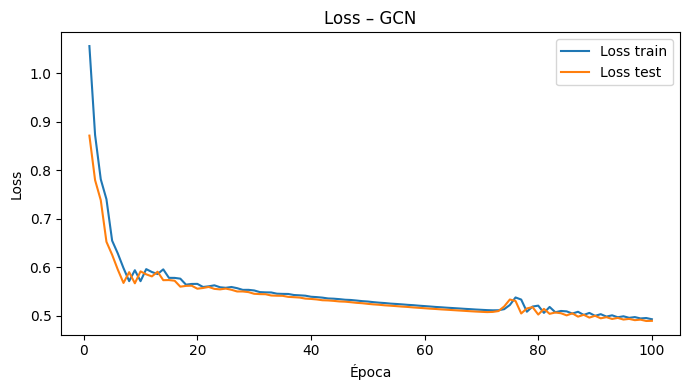

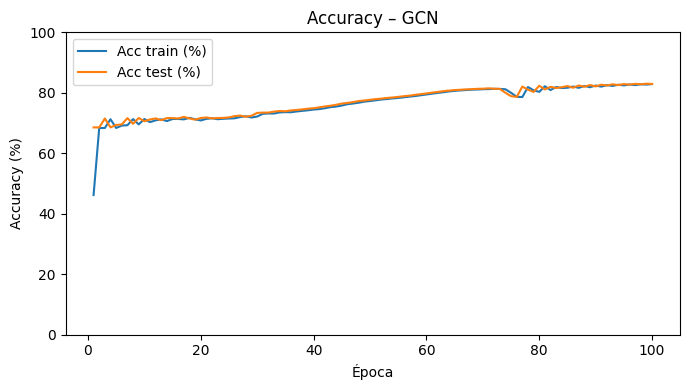


=== Training GraphSAGE ===
ep01 | loss_tr 1.3869 acc_tr 15.81% | loss_te 0.9798 acc_te 68.56%
ep10 | loss_tr 0.8617 acc_tr 68.37% | loss_te 0.8397 acc_te 68.56%
🛑  Early stop en época 16
Matriz de confusión sin normalizar


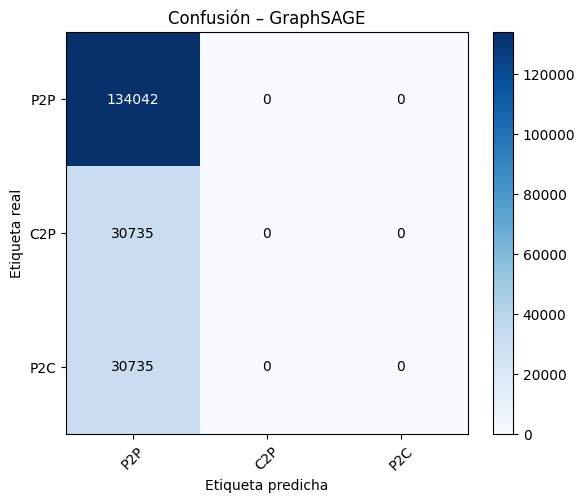

Matriz de confusión normalizada (%)


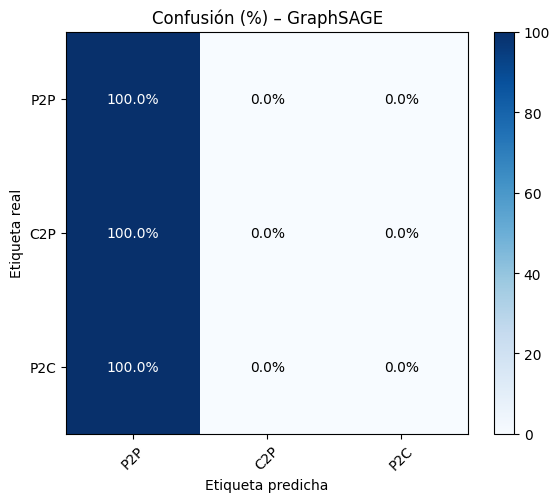

              precision    recall  f1-score   support

           0     0.6856    1.0000    0.8135    134042
           1     0.0000    0.0000    0.0000     30735
           2     0.0000    0.0000    0.0000     30735

    accuracy                         0.6856    195512
   macro avg     0.2285    0.3333    0.2712    195512
weighted avg     0.4700    0.6856    0.5577    195512



/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

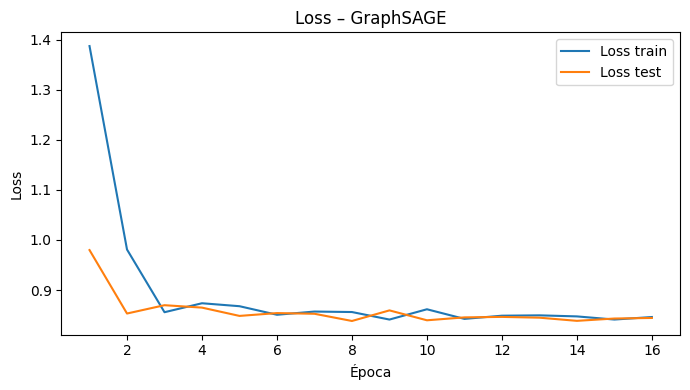

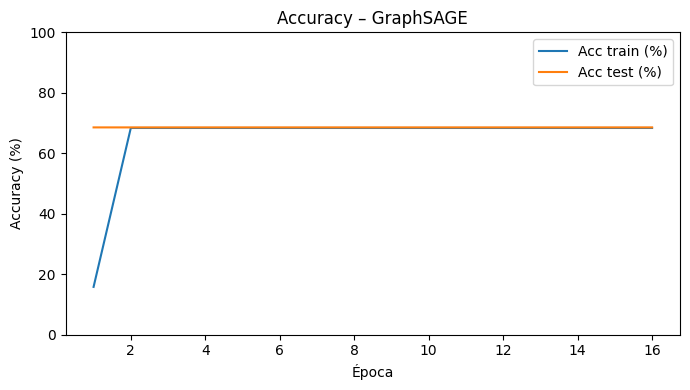


=== Training GAT ===
ep01 | loss_tr 0.9792 acc_tr 68.37% | loss_te 0.8436 acc_te 68.56%
🛑  Early stop en época 9
Matriz de confusión sin normalizar


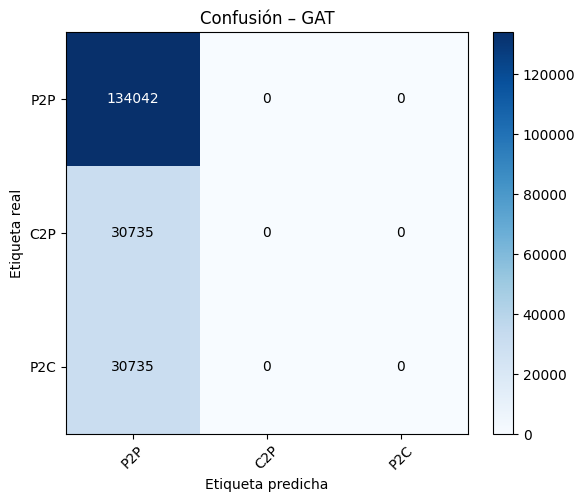

Matriz de confusión normalizada (%)


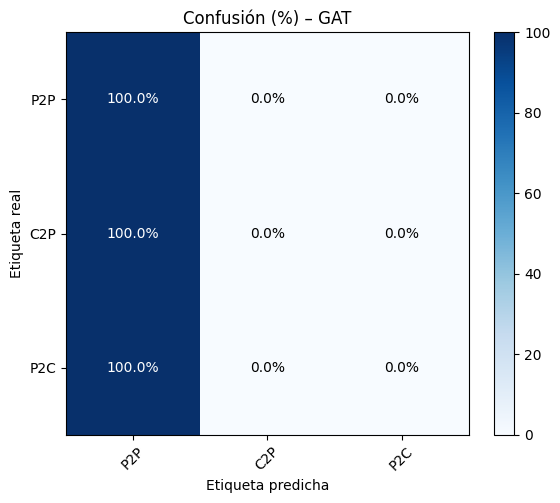

/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

              precision    recall  f1-score   support

           0     0.6856    1.0000    0.8135    134042
           1     0.0000    0.0000    0.0000     30735
           2     0.0000    0.0000    0.0000     30735

    accuracy                         0.6856    195512
   macro avg     0.2285    0.3333    0.2712    195512
weighted avg     0.4700    0.6856    0.5577    195512



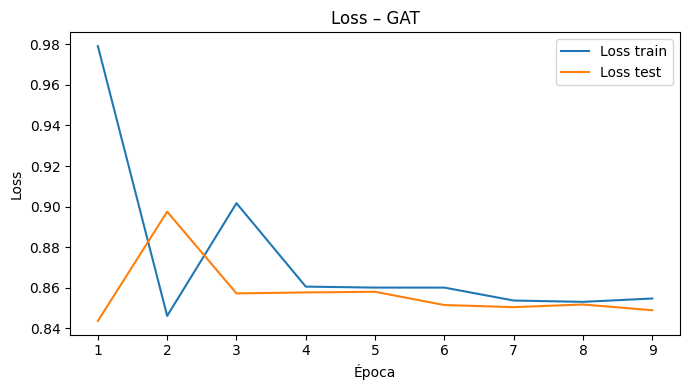

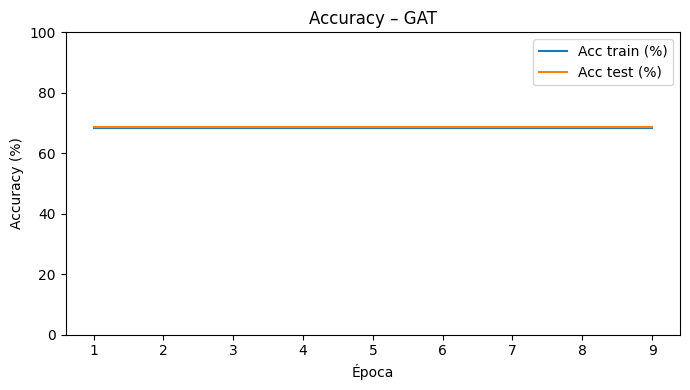

In [20]:
import torch, torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# ─── parámetros globales ────────────────────────────────────────────
in_feats  = gnn.dgl_graph.ndata["feat"].shape[1]
device    = "cuda" if torch.cuda.is_available() else "cpu"
epochs    = 100
lr        = 1e-2
patience  = 8           # early-stopping
n_classes = 3

# ─── datos y máscaras ───────────────────────────────────────────────
g       = gnn.dgl_graph.to(device)
feat    = g.ndata["feat"].to(device)
labels  = g.edata["Relationship"].long().to(device)
train_m = g.edata["train_mask"].to(device)
test_m  = g.edata["test_mask"].to(device)

for name, Model in models.items():
    print(f"\n=== Training {name} ===")

    model = Model(in_feats, 32, 16, out_feats_mlp=n_classes).to(device)
    opt   = torch.optim.Adam(model.parameters() , lr=lr)

    # histórico por modelo
    hist = {"loss_tr": [], "acc_tr": [], "loss_te": [], "acc_te": []}
    best_loss, wait = 1e9, 0

    for ep in range(1, epochs + 1):
        # ---------- train ----------
        model.train()
        h      = model.encode(g, feat)
        logits = model.decodeMLP(g, h)                  # (E, 3)

        loss   = F.cross_entropy(logits[train_m], labels[train_m])
        opt.zero_grad(); loss.backward(); opt.step()

        with torch.no_grad():
            preds_tr = logits[train_m].argmax(1)
            acc_tr   = (preds_tr == labels[train_m]).float().mean().item()

        # ---------- test ----------
        model.eval()
        with torch.no_grad():
            logits_t = model.decodeMLP(g, model.encode(g, feat))
            loss_te  = F.cross_entropy(logits_t[test_m], labels[test_m])
            preds_t  = logits_t[test_m].argmax(1)
            acc_t    = (preds_t == labels[test_m]).float().mean().item()

        # guarda histórico
        hist["loss_tr"].append(loss.item())
        hist["acc_tr"].append(acc_tr * 100)
        hist["loss_te"].append(loss_te.item())
        hist["acc_te"].append(acc_t * 100)

        # early-stopping
        if loss_te < best_loss - 1e-4:
            best_loss, wait = loss_te, 0
            best_w = model.state_dict()
        else:
            wait += 1
            if wait >= patience:
                print(f"🛑  Early stop en época {ep}")
                break

        if ep % 10 == 0 or ep == 1:
            print(f"ep{ep:02d} | loss_tr {loss:.4f} acc_tr {acc_tr:.2%} | "
                  f"loss_te {loss_te:.4f} acc_te {acc_t:.2%}")

    # ---------- evaluación final ----------
    model.load_state_dict(best_w)
    with torch.no_grad():
        logits_best = model.decodeMLP(g, model.encode(g, feat))
        preds_best  = logits_best[test_m].argmax(1).cpu()
        truth       = labels[test_m].cpu()

    cm = confusion_matrix(truth, preds_best)
    plot_confusion_matrix_2(cm, ["P2P","C2P","P2C"], False,
                            title=f"Confusión – {name}")
    plot_confusion_matrix_2(cm, ["P2P","C2P","P2C"], True,
                            title=f"Confusión (%) – {name}")

    print(classification_report(truth, preds_best, digits=4))

    # ---------- curvas de entrenamiento ----------
    epochs_done = range(1, len(hist["loss_tr"]) + 1)

    plt.figure(figsize=(7,4))
    plt.plot(epochs_done, hist["loss_tr"], label="Loss train")
    plt.plot(epochs_done, hist["loss_te"], label="Loss test")
    plt.xlabel("Época"); plt.ylabel("Loss"); plt.title(f"Loss – {name}")
    plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(epochs_done, hist["acc_tr"], label="Acc train (%)")
    plt.plot(epochs_done, hist["acc_te"], label="Acc test (%)")
    plt.xlabel("Época"); plt.ylabel("Accuracy (%)"); plt.ylim(0,100)
    plt.title(f"Accuracy – {name}")
    plt.legend(); plt.tight_layout(); plt.show()


Posibles arreglos:
Diferencia de arquitectura.

    GCN usa la matriz de adyacencia simétrica → capta información global
    rápidamente aun con features aleatorios.

    GraphSAGE (mean) y GAT agregan solamente vecinos; al inicio todos
    los nodos tienen casi el mismo vector aleatorio normalizado
    ⇒ el primer paso de agregación produce embeddings muy parecidos en todas
    partes ⇒ el gradiente se vuelve más pequeño que en GCN y cuesta salir del
    mínimo “todo-P2P”.

Falta de self-loop en SAGE y GAT.
Al no sumar la propia característica el “mensaje” inicial puede diluirse
aún más. (GCN lo incorpora por defecto en tu código).

Función de pérdida sin ponderar.
F.cross_entropy default = ponderación uniforme → la clase mayoritaria
domina.


=== GCN ===
ep001 | loss_tr 1.2035 acc_tr 24.87% | loss_te 1.1261 acc_te 21.95%
ep020 | loss_tr 0.8470 acc_tr 42.45% | loss_te 0.9405 acc_te 23.15%
ep040 | loss_tr 0.7880 acc_tr 49.98% | loss_te 0.8532 acc_te 33.10%
ep060 | loss_tr 0.7410 acc_tr 79.70% | loss_te 0.7597 acc_te 89.50%
ep080 | loss_tr 0.6733 acc_tr 78.57% | loss_te 0.6523 acc_te 89.24%
ep100 | loss_tr 0.6011 acc_tr 78.62% | loss_te 0.5324 acc_te 88.60%
ep120 | loss_tr 0.5416 acc_tr 79.46% | loss_te 0.4480 acc_te 88.68%
Matriz de confusión sin normalizar


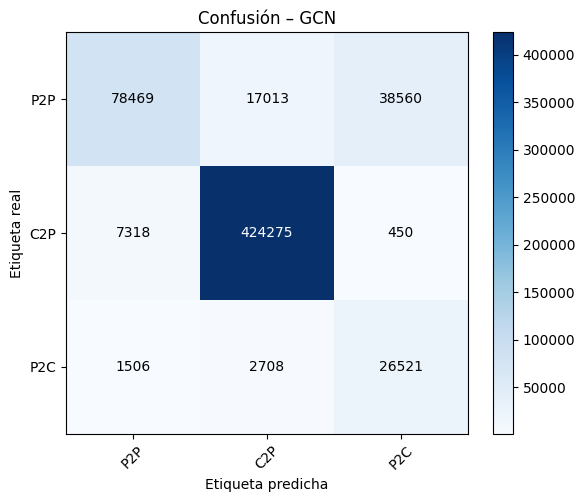

Matriz de confusión normalizada (%)


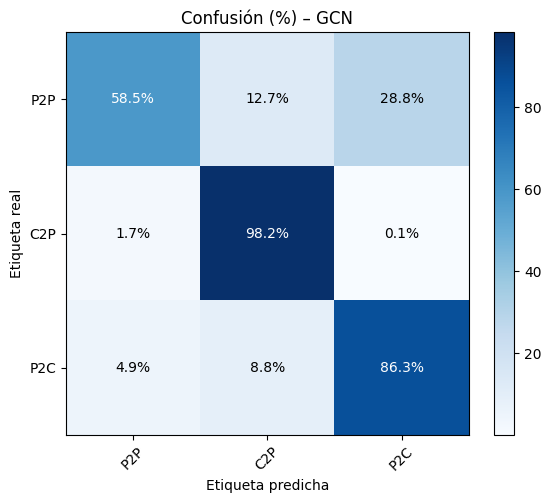

              precision    recall  f1-score   support

           0     0.8989    0.5854    0.7091    134042
           1     0.9556    0.9820    0.9686    432043
           2     0.4047    0.8629    0.5510     30735

    accuracy                         0.8868    596820
   macro avg     0.7531    0.8101    0.7429    596820
weighted avg     0.9145    0.8868    0.8888    596820



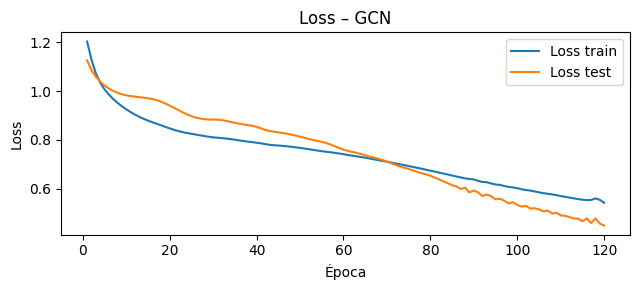

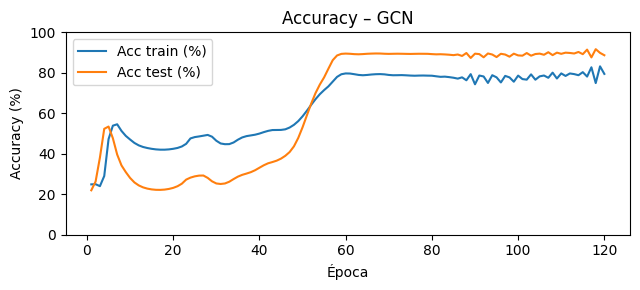


=== GraphSAGE ===
ep001 | loss_tr 1.1186 acc_tr 44.20% | loss_te 1.0720 acc_te 50.81%
🛑  Early-stop en época 11
Matriz de confusión sin normalizar


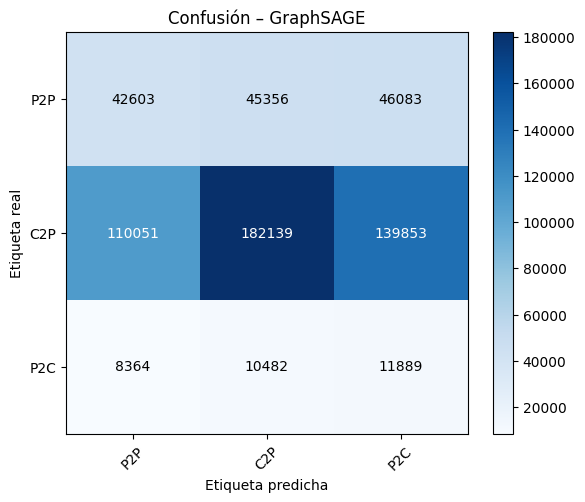

Matriz de confusión normalizada (%)


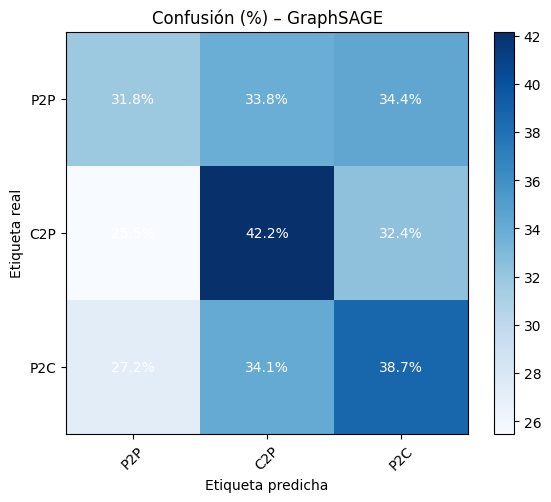

              precision    recall  f1-score   support

           0     0.2646    0.3178    0.2888    134042
           1     0.7654    0.4216    0.5437    432043
           2     0.0601    0.3868    0.1040     30735

    accuracy                         0.3965    596820
   macro avg     0.3633    0.3754    0.3122    596820
weighted avg     0.6166    0.3965    0.4638    596820



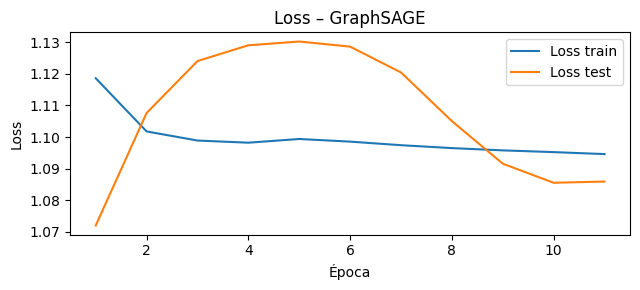

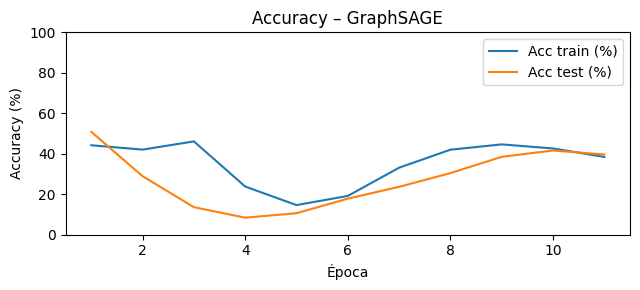


=== GAT ===
ep001 | loss_tr 1.1376 acc_tr 44.36% | loss_te 1.0267 acc_te 71.88%
🛑  Early-stop en época 11
Matriz de confusión sin normalizar


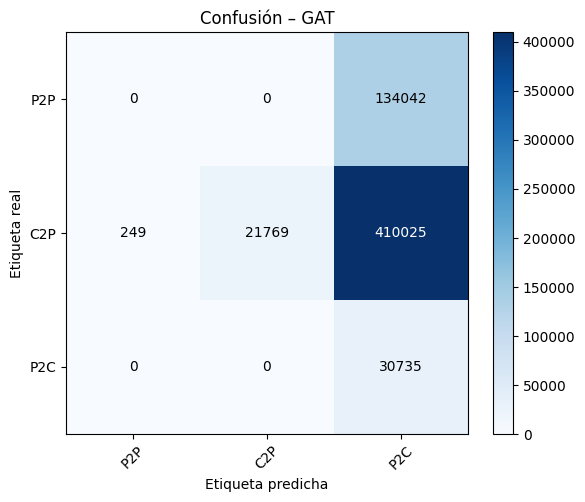

Matriz de confusión normalizada (%)


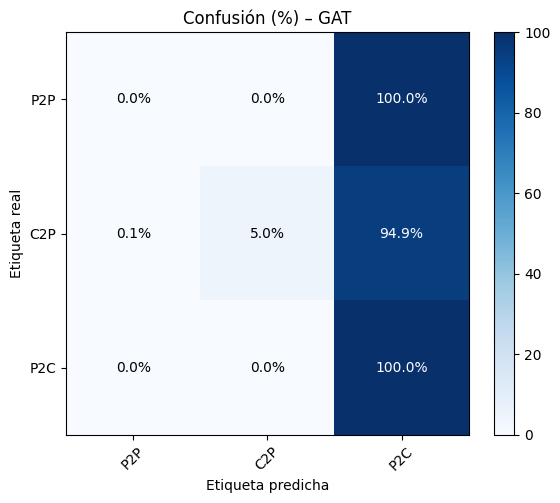

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000    134042
           1     1.0000    0.0504    0.0959    432043
           2     0.0535    1.0000    0.1015     30735

    accuracy                         0.0880    596820
   macro avg     0.3512    0.3501    0.0658    596820
weighted avg     0.7267    0.0880    0.0747    596820



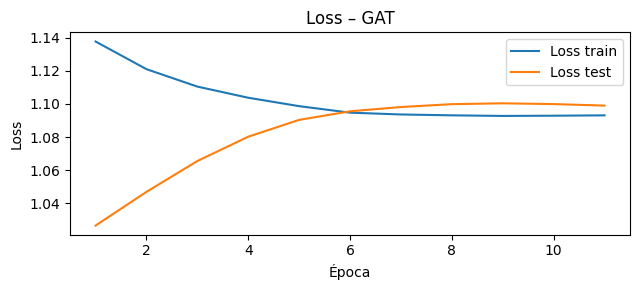

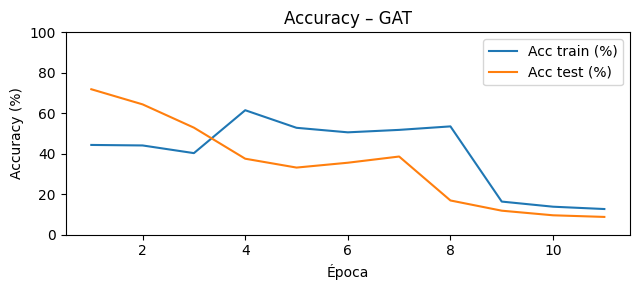

In [22]:
# version arreglada por chatgpt

import torch, torch.nn.functional as F
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# ─── configuración general ─────────────────────────────────────────
device   = "cuda" if torch.cuda.is_available() else "cpu"
g        = gnn.dgl_graph
g = dgl.add_self_loop(g)
g = g.to(device)

x        = g.ndata['feat'].to(device)
y        = g.edata['Relationship'].long().to(device)
tr, te   = g.edata['train_mask'], g.edata['test_mask']

# pesos inversos al nº de ejemplos por clase (0,1,2)
cnt      = Counter(y[tr].tolist())
w_cls    = torch.tensor([1/cnt[i] for i in range(3)], device=device, dtype=torch.float)

epochs   = 120
lr       = 1e-3          # algo más bajo ayuda a SAGE/GAT
patience = 10

# ─── entrenamiento por cada arquitectura ───────────────────────────
for name, Model in models.items():          # GCN, GraphSAGE, GAT …
    print(f"\n=== {name} ===")
    model = Model(x.shape[1], 64, 32, out_feats_mlp=3).to(device)
    opt   = torch.optim.Adam(model.parameters(), lr=lr)

    hist  = {'ltr':[], 'lte':[], 'atr':[], 'ate':[]}
    best_loss, wait, best_w = 1e9, 0, None

    for ep in range(1, epochs + 1):
        # -------- train --------
        model.train()
        logits = model.decodeMLP(g, model.encode(g, x))
        loss   = F.cross_entropy(logits[tr], y[tr], weight=w_cls)

        opt.zero_grad(); loss.backward(); opt.step()

        with torch.no_grad():
            pred_tr = logits[tr].argmax(1)
            acc_tr  = (pred_tr == y[tr]).float().mean().item()*100

        # -------- test ---------
        model.eval()
        with torch.no_grad():
            logits_t = model.decodeMLP(g, model.encode(g, x))
            loss_te  = F.cross_entropy(logits_t[te], y[te], weight=w_cls)
            pred_te  = logits_t[te].argmax(1)
            acc_te   = (pred_te == y[te]).float().mean().item()*100

        # -------- histórico ----
        hist['ltr'].append(loss.item()) ; hist['lte'].append(loss_te.item())
        hist['atr'].append(acc_tr)       ; hist['ate'].append(acc_te)

        # -------- early-stop ----
        if loss_te < best_loss - 1e-4:
            best_loss, wait, best_w = loss_te, 0, {k:v.cpu() for k,v in model.state_dict().items()}
        else:
            wait += 1
            if wait >= patience:
                print(f"🛑  Early-stop en época {ep}")
                break

        if ep % 20 == 0 or ep == 1:
            print(f"ep{ep:03d} | loss_tr {loss:.4f} acc_tr {acc_tr:5.2f}% | "
                  f"loss_te {loss_te:.4f} acc_te {acc_te:5.2f}%")

    # ─── evaluación final ───────────────────────────────────────────
    model.load_state_dict(best_w, strict=False)
    with torch.no_grad():
        logits_best = model.decodeMLP(g, model.encode(g, x))
        preds_best  = logits_best[te].argmax(1).cpu()
        truth       = y[te].cpu()

    # matriz de confusión
    cm = confusion_matrix(truth, preds_best)
    plot_confusion_matrix_2(cm, ["P2P","C2P","P2C"], False,
                            title=f"Confusión – {name}")
    plot_confusion_matrix_2(cm, ["P2P","C2P","P2C"], True,
                            title=f"Confusión (%) – {name}")
    print(classification_report(truth, preds_best, digits=4))

    # curvas
    ep_axis = range(1, len(hist['ltr'])+1)
    plt.figure(figsize=(6.5,3))
    plt.plot(ep_axis, hist['ltr'], label='Loss train')
    plt.plot(ep_axis, hist['lte'], label='Loss test')
    plt.xlabel('Época'); plt.ylabel('Loss'); plt.title(f'Loss – {name}')
    plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(6.5,3))
    plt.plot(ep_axis, hist['atr'], label='Acc train (%)')
    plt.plot(ep_axis, hist['ate'], label='Acc test (%)')
    plt.xlabel('Época'); plt.ylabel('Accuracy (%)'); plt.ylim(0,100)
    plt.title(f'Accuracy – {name}')
    plt.legend(); plt.tight_layout(); plt.show()


### Caso 5: Utilizando metodo de sampling Cluster batch normalization

parte el grafo en K clusters disjuntos y cada
mini-batch es todo un cluster (no un bloque‐vecinos).

|                              | NeighborSampler (antes)                      | ClusterGCNSampler (ahora)                                                                 |
| ---------------------------- | -------------------------------------------- | ----------------------------------------------------------------------------------------- |
| lo que devuelve `DataLoader` | `(input_nodes, pair_graph, blocks)`          | **un único subgrafo** `subg`                                                              |
| cómo llamo al `encode`       | `model.encode(blocks, x)` (lista de bloques) | `model.encode([subg], x)` **o** `model.encode(subg, x)` si tu `encode` acepta un DGLGraph |


In [4]:
from modules.gnn_models import GCNSampler, GraphSAGESample, GATSample

models = {
    "GCN-Sampler":  GCNSampler,
    "SAGE-Sampler": GraphSAGESample,
    "GAT-Sampler":  GATSample
}


In [5]:
RELATIONSHIPS_FILE = '/home/valentina/Desktop/GIT/TrabajoTesis/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2'
INTERNETGRAPH_FILE = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024/febrero'

gnn = GNN(debug=True)

# Cargo dataset y etiqueto sgun archivo de relaciones
gnn.load_dataset(
    data_path=INTERNETGRAPH_FILE,  # Grafo internet no etiquetado
    force_reload=True,
    index_graph = 1,  # Indice del grafo a cargar febrero
    simplify=True,            # ⇐ hazlo sólo una vez
    caida_path=RELATIONSHIPS_FILE  # Archivo CAIDA AS Relationships
)

gnn.split_edges_classification(train_size=0.5, seed=42)


[load_dataset] Leyendo CSV …
Done saving data into cached files.
[load_dataset] Grafo Graph(num_nodes=42683, num_edges=157675438,
      ndata_schemes={'feat': Scheme(shape=(68,), dtype=torch.float32)}
      edata_schemes={})
[load_dataset] Simplificando  …
[load_dataset] Etiquetando CAIDA → /home/valentina/Desktop/GIT/TrabajoTesis/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2


Etiquetando CAIDA: 488952it [00:01, 459126.28it/s]


[CAIDA] Añadidas 977288 aristas que faltaban
[CAIDA] Conteo final de etiquetas 0/1/2/-1 → Counter({-1: 699046, 0: 668732, 2: 154411, 1: 154411})
[load_dataset] etiquetas 0/1/2/-1 → Counter({-1: 699046, 0: 668732, 2: 154411, 1: 154411})
[split] train=488776  test=488778
  clases train: {0: 334418, 2: 77179, 1: 77179}


In [29]:

num_parts = 1000                         # ajusta tamaño de cluster
device    = "cuda" if torch.cuda.is_available() else "cpu"

# ① sampler
sampler = dgl.dataloading.ClusterGCNSampler(
            g, num_parts,
            prefetch_ndata=['feat'],
            prefetch_edata=['Relationship', 'train_mask', 'test_mask'])

# ② índices de clusters = 0 … (num_parts-1)
cluster_ids = torch.arange(num_parts)

# ③ DataLoader de entrenamiento  (shufle = True)
train_loader = dgl.dataloading.DataLoader(
        g, cluster_ids, sampler,
        batch_size=1, shuffle=True, drop_last=False, device=device)

# ④ DataLoader de test             (sin barajar)
test_loader  = dgl.dataloading.DataLoader(
        g, cluster_ids, sampler,
        batch_size=1, shuffle=False, drop_last=False, device=device)


Cada iteración entrega subg, un subgrafo que contiene todos los
nodos y aristas de un cluster.

In [26]:
from tqdm.auto import tqdm
import torch.nn.functional as F

# ─── parámetros globales ────────────────────────────────────────────
in_feats  = gnn.dgl_graph.ndata["feat"].shape[1]
device    = "cuda" if torch.cuda.is_available() else "cpu"
epochs    = 1
lr        = 1e-2
patience  = 8           # early-stopping
n_classes = 3

# ─── datos y máscaras ───────────────────────────────────────────────
g       = gnn.dgl_graph.to(device)
feat    = g.ndata["feat"].to(device)
labels  = g.edata["Relationship"].long().to(device)
train_m = g.edata["train_mask"].to(device)
test_m  = g.edata["test_mask"].to(device)

for name, Model in models.items():
    print(f"\n=== Training {name} ===")

    model = Model(in_feats, 32, 16, out_feats_mlp=n_classes).to(device)
    opt   = torch.optim.Adam(model.parameters() , lr=lr)

    # histórico por modelo
    hist = {"loss_tr": [], "acc_tr": [], "loss_te": [], "acc_te": []}
    best_loss, wait = 1e9, 0

    for ep in range(1, epochs+1):

        # ---------- TRAIN ---------------------------------------------
        model.train()
        loss_sum = corr = tot = 0

        pbar = tqdm(train_loader, total=len(train_loader),
                    desc=f"Epoch {ep:03d}", leave=True)

        for subg in pbar:                     # <- ¡solo un objeto!
            subg = subg.to(device)
            x    = subg.ndata['feat'].float()
            y    = subg.edata['Relationship'].long()
            m    = subg.edata['train_mask'].bool()

            h      = model.encode([subg], x)          # o encode(subg, x)
            logits = model.decodeMLP(subg, h)         # (E_cluster, 3)

            loss = F.cross_entropy(logits[m], y[m])

            optim.zero_grad()
            loss.backward()
            optim.step()

            # métricas
            loss_sum += loss.item() * m.sum().item()
            pred      = logits[m].argmax(1)
            corr     += (pred == y[m]).sum().item()
            tot      += m.sum().item()

        loss_tr = loss_sum / tot
        acc_tr  = 100 * corr / tot

        # ---------- TEST ----------------------------------------------
        model.eval()
        loss_sum = corr = tot = 0
        preds_all, truth_all = [], []

        with torch.no_grad():
            for subg in test_loader:
                subg = subg.to(device)
                x    = subg.ndata['feat'].float()
                y    = subg.edata['Relationship'].long()
                m    = subg.edata['test_mask'].bool()

                h      = model.encode([subg], x)
                logits = model.decodeMLP(subg, h)

                loss_sum += F.cross_entropy(logits[m], y[m]).item() * m.sum().item()
                pred      = logits[m].argmax(1)

                corr += (pred == y[m]).sum().item()
                tot  += m.sum().item()

                preds_all.append(pred.cpu())
                truth_all.append(y[m].cpu())

        loss_te = loss_sum / tot
        acc_te  = 100 * corr / tot

        print(f"ep{ep:03d} | loss_tr {loss_tr:.4f} acc_tr {acc_tr:.2f}% | "
            f"loss_te {loss_te:.4f} acc_te {acc_te:.2f}%")



=== Training GCN-Sampler ===


Epoch 001: 100%|██████████| 1000/1000 [00:02<00:00, 342.85it/s]


ep001 | loss_tr nan acc_tr 32.65% | loss_te nan acc_te 32.30%

=== Training SAGE-Sampler ===


Epoch 001: 100%|██████████| 1000/1000 [00:02<00:00, 358.19it/s]


ep001 | loss_tr nan acc_tr 32.96% | loss_te nan acc_te 32.70%

=== Training GAT-Sampler ===


Epoch 001: 100%|██████████| 1000/1000 [00:03<00:00, 280.95it/s]


ep001 | loss_tr nan acc_tr 34.07% | loss_te nan acc_te 34.61%


In [30]:
from tqdm.auto import tqdm
import torch.nn.functional as F

# ─── parámetros globales ────────────────────────────────────────────
in_feats  = gnn.dgl_graph.ndata["feat"].shape[1]
device    = "cuda" if torch.cuda.is_available() else "cpu"
epochs    = 1
lr        = 1e-2
patience  = 8           # early-stopping
n_classes = 3

# ─── datos y máscaras ───────────────────────────────────────────────
g       = gnn.dgl_graph.to(device)
feat    = g.ndata["feat"].to(device)
labels  = g.edata["Relationship"].long().to(device)
train_m = g.edata["train_mask"].to(device)
test_m  = g.edata["test_mask"].to(device)

for name, Model in models.items():
    print(f"\n=== Training {name} ===")

    model = Model(in_feats, 32, 16, out_feats_mlp=n_classes).to(device)
    opt   = torch.optim.Adam(model.parameters() , lr=lr)

    # histórico por modelo
    hist = {"loss_tr": [], "acc_tr": [], "loss_te": [], "acc_te": []}
    best_loss, wait = 1e9, 0

    for ep in range(1, epochs+1):

        # ---------- TRAIN ---------------------------------------------
        model.train()
        loss_sum = corr = tot = 0

        pbar = tqdm(train_loader, total=len(train_loader),
                    desc=f"Epoch {ep:03d}", leave=True)

        for subg in pbar:                     # <- ¡solo un objeto!
            subg = subg.to(device)
            x    = subg.ndata['feat'].float()
            y    = subg.edata['Relationship'].long()
            m    = subg.edata['train_mask'].bool()

            h      = model.encode([subg], x)          # o encode(subg, x)
            logits = model.decodeMLP(subg, h)         # (E_cluster, 3)

            loss = F.cross_entropy(logits[m], y[m])

            optim.zero_grad()
            loss.backward()
            optim.step()

            # métricas
            loss_sum += loss.item() * m.sum().item()
            pred      = logits[m].argmax(1)
            corr     += (pred == y[m]).sum().item()
            tot      += m.sum().item()

        loss_tr = loss_sum / tot
        acc_tr  = 100 * corr / tot

        # ---------- TEST ----------------------------------------------
        model.eval()
        loss_sum = corr = tot = 0
        preds_all, truth_all = [], []

        with torch.no_grad():
            for subg in test_loader:
                subg = subg.to(device)
                x    = subg.ndata['feat'].float()
                y    = subg.edata['Relationship'].long()
                m    = subg.edata['test_mask'].bool()

                h      = model.encode([subg], x)
                logits = model.decodeMLP(subg, h)

                loss_sum += F.cross_entropy(logits[m], y[m]).item() * m.sum().item()
                pred      = logits[m].argmax(1)

                corr += (pred == y[m]).sum().item()
                tot  += m.sum().item()

                preds_all.append(pred.cpu())
                truth_all.append(y[m].cpu())

        loss_te = loss_sum / tot
        acc_te  = 100 * corr / tot

        print(f"ep{ep:03d} | loss_tr {loss_tr:.4f} acc_tr {acc_tr:.2f}% | "
            f"loss_te {loss_te:.4f} acc_te {acc_te:.2f}%")


=== Training GCN-Sampler ===


Epoch 001: 100%|██████████| 1000/1000 [00:02<00:00, 342.55it/s]


KeyboardInterrupt: 

In [31]:
# # --------- 1. dataloaders con ClusterGCN ---------------------------
# num_parts = 150                       # o el nº de clusters que prefieras
# sampler   = dgl.dataloading.ClusterGCNSampler(g, num_parts)

# train_loader = torch.utils.data.DataLoader(
#     sampler, batch_size=1, shuffle=True, drop_last=False)

# test_loader  = torch.utils.data.DataLoader(
#     sampler, batch_size=1, shuffle=False, drop_last=False)

# --------- 2. hiperparámetros --------------------------------------
in_feats  = g.ndata['feat'].shape[1]
epochs    = 50
lr        = 1e-2
patience  = 8
device    = "cuda" if torch.cuda.is_available() else "cpu"
n_cls     = 3

# --------- 3. entrenamiento sobre cada modelo ----------------------
for model_name, Model in models.items():
    print(f"\n=== Training {model_name} ===")

    model = Model(in_feats, 64, 32, out_feats_mlp=n_cls).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    hist = {"loss_tr": [], "acc_tr": [], "loss_te": [], "acc_te": []}
    best_loss, best_state, wait = 1e9, None, 0             # early stop

    for epoch in range(1, epochs + 1):
        # ─────────────── TRAIN ──────────────────────────────
        model.train()
        loss_sum = corr = tot = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch:03}")
        
        for subg in pbar:                     # subg = un cluster (grafo)
            subg = subg.to(device)
            x = subg.ndata["feat"].float()
            y = subg.edata["Relationship"].long()
            m = subg.edata["train_mask"].bool()

            h      = model.encode(subg, x)          # encode espera grafo
            logits = model.decodeMLP(subg, h)       # (E_cluster, 3)
            loss   = F.cross_entropy(logits[m], y[m])

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_sum += loss.item() * m.sum().item()
            pred      = logits[m].argmax(1)
            corr     += (pred == y[m]).sum().item()
            tot      += m.sum().item()

        loss_tr = loss_sum / tot
        acc_tr  = 100 * corr / tot

        # ─────────────── TEST ───────────────────────────────
        model.eval()
        loss_sum = corr = tot = 0
        preds_all, truth_all = [], []

        with torch.no_grad():
            for subg in test_loader:
                subg = subg.to(device)
                x = subg.ndata["feat"].float()
                y = subg.edata["Relationship"].long()
                m = subg.edata["test_mask"].bool()

                h      = model.encode(subg, x)
                logits = model.decodeMLP(subg, h)

                loss_sum += F.cross_entropy(logits[m], y[m]).item() * m.sum().item()
                pred = logits[m].argmax(1)

                corr += (pred == y[m]).sum().item()
                tot  += m.sum().item()

                preds_all.append(pred.cpu())
                truth_all.append(y[m].cpu())

        loss_te = loss_sum / tot
        acc_te  = 100 * corr / tot

        # ─────────────── historial & early stop ─────────────
        hist["loss_tr"].append(loss_tr);  hist["loss_te"].append(loss_te)
        hist["acc_tr"].append(acc_tr);    hist["acc_te"].append(acc_te)

        if loss_te < best_loss - 1e-4:
            best_loss, wait = loss_te, 0
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
        else:
            wait += 1
            if wait >= patience:
                print(f"🛑  Early-stop en época {epoch}")
                break

        if epoch % 5 == 0 or epoch == 1:
            print(f"ep{epoch:03d} | "
                  f"loss_tr {loss_tr:.4f} acc_tr {acc_tr:.2f}% | "
                  f"loss_te {loss_te:.4f} acc_te {acc_te:.2f}%")

    # ───────────── evaluación final ────────────────────────
    model.load_state_dict(best_state)
    preds  = torch.cat(preds_all)
    truth  = torch.cat(truth_all)

    cm = confusion_matrix(truth, preds)
    plot_confusion_matrix_2(cm, ["P2P", "C2P", "P2C"], False,
                            title=f"Confusión – {model_name}")
    plot_confusion_matrix_2(cm, ["P2P", "C2P", "P2C"], True,
                            title=f"Confusión (%) – {model_name}")
    print(classification_report(truth, preds, digits=4))

    # ───────────── curvas loss / acc ───────────────────────
    ep_axis = range(1, len(hist["loss_tr"]) + 1)

    plt.figure(figsize=(7,4))
    plt.plot(ep_axis, hist["loss_tr"], label="Loss train")
    plt.plot(ep_axis, hist["loss_te"], label="Loss test")
    plt.xlabel("Época"); plt.ylabel("Loss"); plt.title(f"Loss – {model_name}")
    plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(ep_axis, hist["acc_tr"], label="Acc train (%)")
    plt.plot(ep_axis, hist["acc_te"], label="Acc test (%)")
    plt.xlabel("Época"); plt.ylabel("Accuracy (%)"); plt.ylim(0, 100)
    plt.title(f"Accuracy – {model_name}")
    plt.legend(); plt.tight_layout(); plt.show()



=== Training GCN-Sampler ===


ep001 | loss_tr nan acc_tr 62.64% | loss_te nan acc_te 62.49%


ep005 | loss_tr nan acc_tr 62.83% | loss_te nan acc_te 62.42%


🛑  Early-stop en época 8


TypeError: Expected state_dict to be dict-like, got <class 'NoneType'>.


===== Entrenando GCN-Sampler =====


ep001 | loss_tr nan acc_tr 62.61% | loss_te nan acc_te 62.48%


ep005 | loss_tr nan acc_tr 63.02% | loss_te nan acc_te 62.28%


🛑  Early-stop en época 8
Matriz de confusión sin normalizar


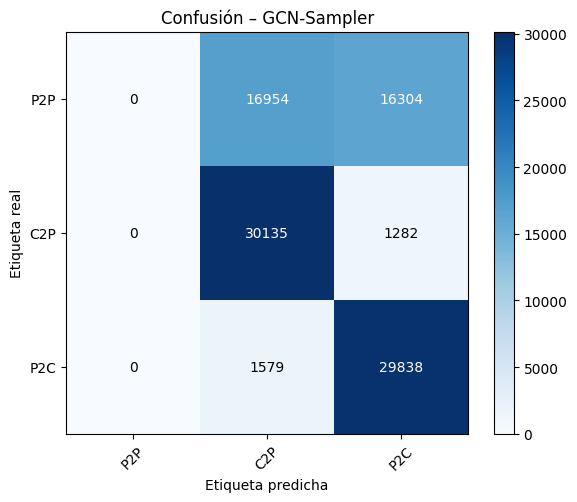

Matriz de confusión normalizada (%)


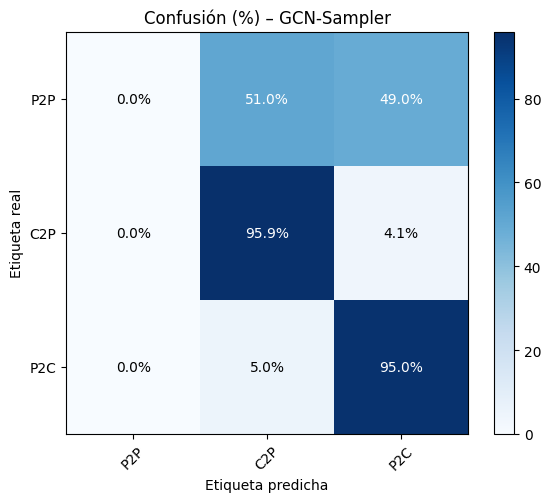

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000     33258
           1     0.6192    0.9592    0.7526     31417
           2     0.6292    0.9497    0.7569     31417

    accuracy                         0.6241     96092
   macro avg     0.4161    0.6363    0.5032     96092
weighted avg     0.4082    0.6241    0.4935     96092



/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

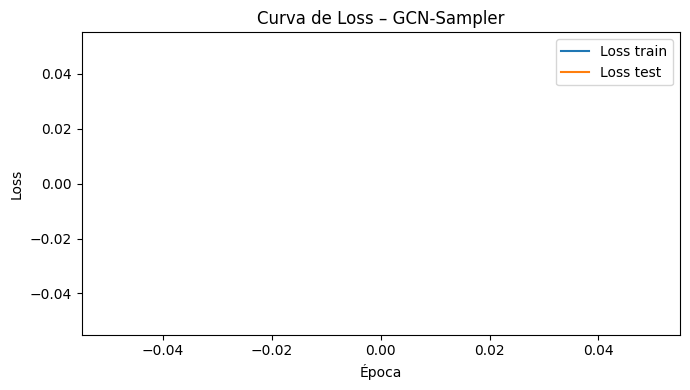

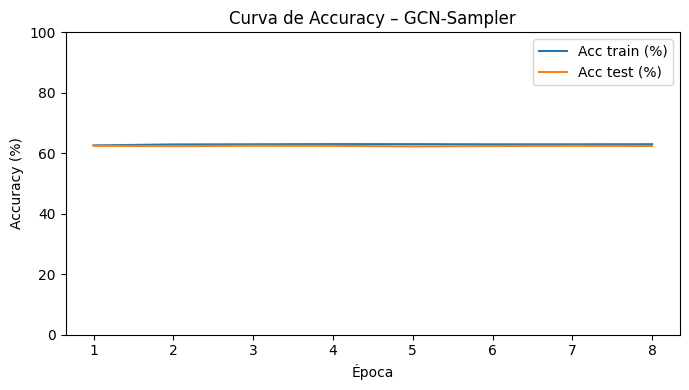


===== Entrenando SAGE-Sampler =====


Epoch 001:   0%|          | 0/1000 [00:00<?, ?it/s]/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/dgl/dataloading/dataloader.py:1144: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(
/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/dgl/core.py:82: DGLWarning: The input graph for the user-defined edge function does not contain valid edges
  dgl_warning(


ep001 | loss_tr nan acc_tr 62.19% | loss_te nan acc_te 62.15%


ep005 | loss_tr nan acc_tr 62.90% | loss_te nan acc_te 62.39%


🛑  Early-stop en época 8
Matriz de confusión sin normalizar


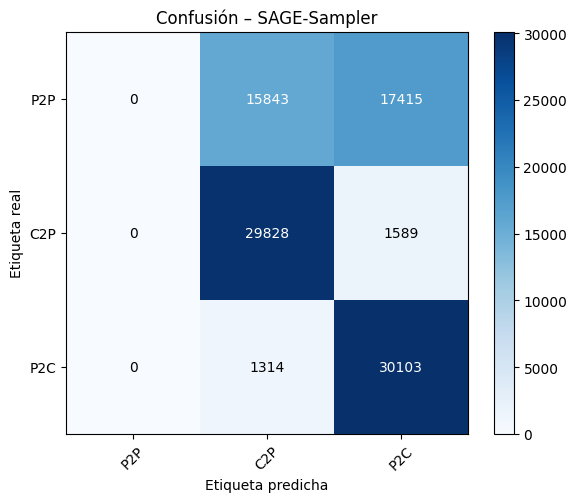

Matriz de confusión normalizada (%)


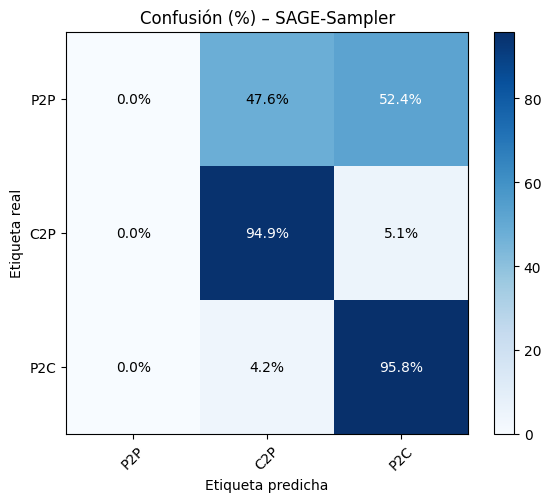

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000     33258
           1     0.6348    0.9494    0.7609     31417
           2     0.6130    0.9582    0.7477     31417

    accuracy                         0.6237     96092
   macro avg     0.4159    0.6359    0.5029     96092
weighted avg     0.4080    0.6237    0.4932     96092



/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

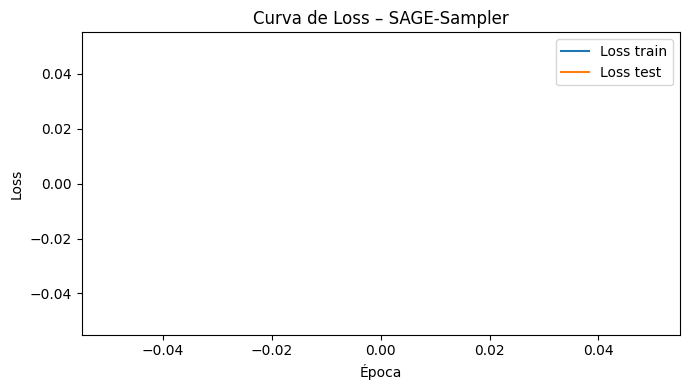

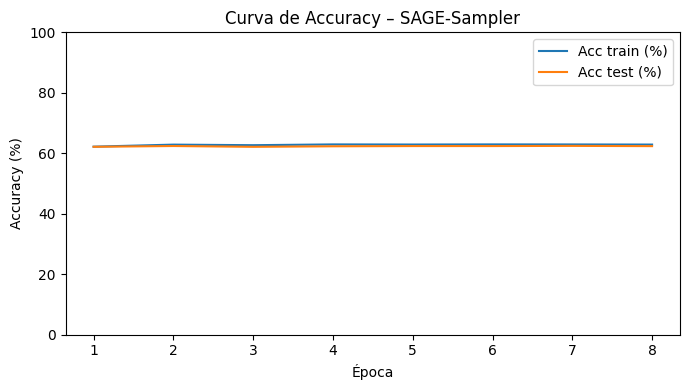


===== Entrenando GAT-Sampler =====


Epoch 001:   0%|          | 0/1000 [00:00<?, ?it/s]/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/dgl/dataloading/dataloader.py:1144: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(
/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/dgl/core.py:82: DGLWarning: The input graph for the user-defined edge function does not contain valid edges
  dgl_warning(


ep001 | loss_tr nan acc_tr 46.72% | loss_te nan acc_te 57.17%


ep005 | loss_tr nan acc_tr 59.90% | loss_te nan acc_te 66.38%


🛑  Early-stop en época 8
Matriz de confusión sin normalizar


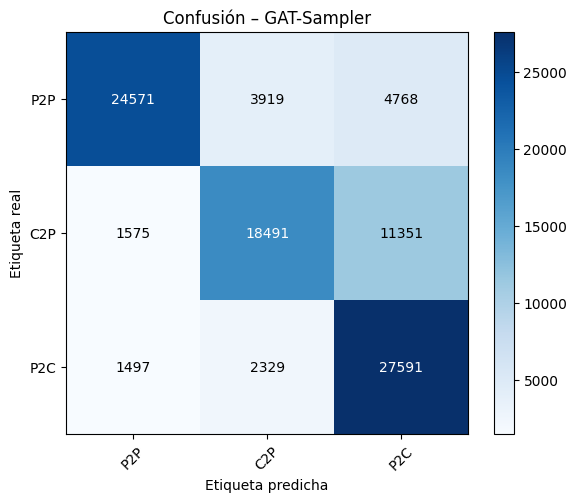

Matriz de confusión normalizada (%)


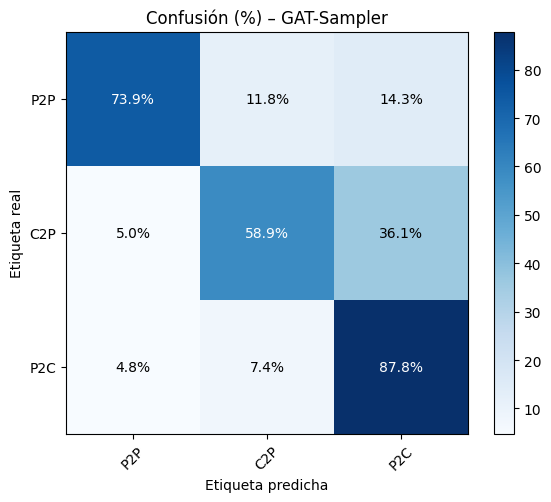

              precision    recall  f1-score   support

           0     0.8889    0.7388    0.8069     33258
           1     0.7474    0.5886    0.6586     31417
           2     0.6312    0.8782    0.7345     31417

    accuracy                         0.7353     96092
   macro avg     0.7558    0.7352    0.7333     96092
weighted avg     0.7584    0.7353    0.7347     96092



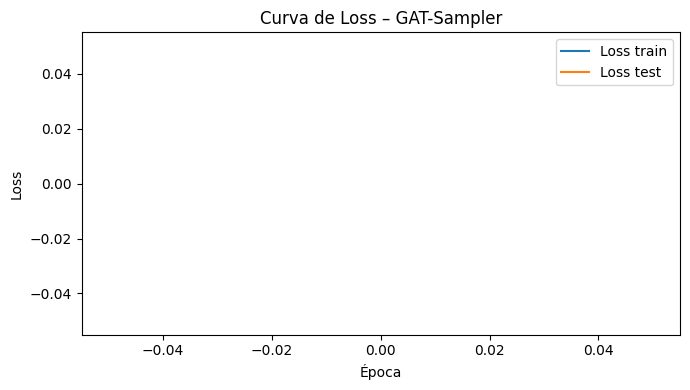

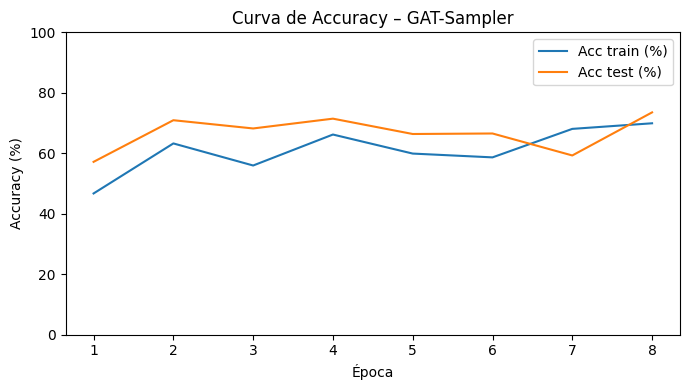

In [33]:
from tqdm.auto import tqdm
import torch, torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# ─── hiper-parámetros ──────────────────────────────────────────────
in_feats  = gnn.dgl_graph.ndata['feat'].shape[1]
device    = "cuda" if torch.cuda.is_available() else "cpu"
epochs    = 50
lr        = 1e-2
patience  = 8               # early-stopping
n_classes = 3

# ─── loop sobre modelos ────────────────────────────────────────────
for name, Model in models.items():
    print(f"\n===== Entrenando {name} =====")

    model = Model(in_feats, 64, 32, out_feats_mlp=n_classes).to(device)
    optim = torch.optim.Adam(model.parameters(), lr=lr)

    # historial
    hist = {"loss_tr": [], "acc_tr": [], "loss_te": [], "acc_te": []}
    best_loss, best_state, wait = 1e9, None, 0

    for epoch in range(1, epochs + 1):

        # ── TRAIN ───────────────────────────────────────────────────
        model.train()
        loss_sum = corr = tot = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch:03d}", leave=False)
        for subg in pbar:                    # subg = grafo de un cluster
            subg = subg.to(device)
            x    = subg.ndata['feat'].float()
            y    = subg.edata['Relationship'].long()
            m    = subg.edata['train_mask'].bool()

            h      = model.encode(subg, x)          # <- nota: grafo completo
            logits = model.decodeMLP(subg, h)       # (E_cluster, 3)

            loss = F.cross_entropy(logits[m], y[m])

            optim.zero_grad()
            loss.backward()
            optim.step()

            # métrica batch
            loss_sum += loss.item() * m.sum().item()
            pred      = logits[m].argmax(1)
            corr     += (pred == y[m]).sum().item()
            tot      += m.sum().item()

        loss_tr = loss_sum / tot
        acc_tr  = 100 * corr / tot

        # ── TEST ────────────────────────────────────────────────────
        model.eval()
        loss_sum = corr = tot = 0
        preds_all, truth_all = [], []

        with torch.no_grad():
            for subg in test_loader:
                subg = subg.to(device)
                x    = subg.ndata['feat'].float()
                y    = subg.edata['Relationship'].long()
                m    = subg.edata['test_mask'].bool()

                h      = model.encode(subg, x)
                logits = model.decodeMLP(subg, h)

                loss_sum += F.cross_entropy(logits[m], y[m]).item() * m.sum().item()
                pred      = logits[m].argmax(1)

                corr += (pred == y[m]).sum().item()
                tot  += m.sum().item()
                preds_all.append(pred.cpu())
                truth_all.append(y[m].cpu())

        loss_te = loss_sum / tot
        acc_te  = 100 * corr / tot

        # ── historial + early-stopping ─────────────────────────────
        hist['loss_tr'].append(loss_tr);  hist['loss_te'].append(loss_te)
        hist['acc_tr'].append(acc_tr);    hist['acc_te'].append(acc_te)

        if loss_te < best_loss - 1e-4:
            best_loss, wait = loss_te, 0
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
        else:
            wait += 1
            if wait >= patience:
                print(f"🛑  Early-stop en época {epoch}")
                break

        if epoch % 5 == 0 or epoch == 1:
            print(f"ep{epoch:03d} | "
                  f"loss_tr {loss_tr:.4f} acc_tr {acc_tr:.2f}% | "
                  f"loss_te {loss_te:.4f} acc_te {acc_te:.2f}%")

    # ─── evaluación final ──────────────────────────────────────────
    if best_state is None:                      # por si nunca mejoró
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}
    model.load_state_dict(best_state)

    preds = torch.cat(preds_all)
    truth = torch.cat(truth_all)

    cm = confusion_matrix(truth, preds)
    plot_confusion_matrix_2(cm, ["P2P", "C2P", "P2C"],
                            normalize=False, title=f"Confusión – {name}")
    plot_confusion_matrix_2(cm, ["P2P", "C2P", "P2C"],
                            normalize=True,  title=f"Confusión (%) – {name}")
    print(classification_report(truth, preds, digits=4))

    # ─── gráficos de historial ─────────────────────────────────────
    ep_axis = range(1, len(hist['loss_tr']) + 1)

    plt.figure(figsize=(7,4))
    plt.plot(ep_axis, hist['loss_tr'], label="Loss train")
    plt.plot(ep_axis, hist['loss_te'], label="Loss test")
    plt.xlabel("Época"); plt.ylabel("Loss")
    plt.title(f"Curva de Loss – {name}")
    plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(ep_axis, hist['acc_tr'], label="Acc train (%)")
    plt.plot(ep_axis, hist['acc_te'], label="Acc test (%)")
    plt.xlabel("Época"); plt.ylabel("Accuracy (%)"); plt.ylim(0,100)
    plt.title(f"Curva de Accuracy – {name}")
    plt.legend(); plt.tight_layout(); plt.show()


In [34]:
from collections import Counter
tot = Counter(); tr = Counter(); te = Counter()

for sg in train_loader:             # lo que ve el encoder
    y = sg.edata['Relationship'][ sg.edata['train_mask'] ].tolist()
    tr.update(y)
for sg in test_loader:
    y = sg.edata['Relationship'][ sg.edata['test_mask'] ].tolist()
    te.update(y)

tot.update( g.edata['Relationship'].tolist() )

print("GLOBAL :", tot)
print("TRAIN  :", tr)
print("TEST   :", te)


/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/dgl/dataloading/dataloader.py:1144: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(


GLOBAL : Counter({-1: 699046, 0: 668732, 2: 154411, 1: 154411})
TRAIN  : Counter({0: 32702, 1: 31636, 2: 31636})
TEST   : Counter({0: 33258, 2: 31417, 1: 31417})
